# Bibliotecas

In [1]:
## Pandas 
import pandas as pd
import numpy as np
import seaborn as sns # Alternativa pra gerar gráficos
import matplotlib.pyplot as plot
from dfply import *
from pandas.tseries.offsets import DateOffset
from math import sqrt


##Visualização data frame pandas sem truncamento
#pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
#pd.set_option('display.width', None)
#pd.set_option('display.max_colwidth', None)

# permite a vizualição de números flutuantes com duas casas decimais
pd.set_option('display.float_format', '{:.2f}'.format)

# Contratos Carnê

In [ ]:
# Base Carnê
# Apenas um arquivo
caminho= r"C:\Users\fernando.monteiro\deep-torch-example\KAB\Behavior_KAB\saida_carne_202507.csv"
df_carne = pd.read_csv(
    caminho,
    sep=";"
)

# Ajustando os tipos dos campos
df_carne["data"]=pd.to_datetime(df_carne["data"])
df_carne["id_agente"]=df_carne["id_agente"].astype("category")
df_carne["conceito"]=df_carne["conceito"].astype("category")
df_carne["conceito"] = df_carne["conceito"].astype(str).str.strip()
df_carne["anomes"]=df_carne["anomes"].astype("category")
df_carne["flag_renegociacao"]=df_carne["flag_renegociacao"].astype("category")
df_carne["anomes_new"]=pd.to_datetime(df_carne["anomes_new"])
df_carne["data_vencimento_prox_parcela"]=pd.to_datetime(df_carne["data_vencimento_prox_parcela"])
df_carne["data_vencimento_ultima_parcela"]=pd.to_datetime(df_carne["data_vencimento_ultima_parcela"])
df_carne["ParcelaDataPagto"]=pd.to_datetime(df_carne["ParcelaDataPagto"])

# % de nulos por linha
df_carne["%_nulos"] = df_carne.isna().sum(axis=1) / df_carne.shape[1] * 100

# Excluindo linhas
to_exclude = [
    "033 VENDAS ATACADO",
    "009 SAQUE EMERGENCIAL",
    "029 RENEGOCIACAO SAQUE EMER (AG19)",
    "019 RENEGOCIACAO SAQUE EMERGENCIAL"
]
df_carne = df_carne[
    ~df_carne["id_agente"].isin(to_exclude) &
    (df_carne["%_nulos"] <= 50)
].drop(columns=["%_nulos","anomes_new","cpf_contrato_nparc","CPF","Contrato","ParcelaNumero"])  

# Categorização 'Produto'
condicoes = [
    df_carne["id_agente"] == "005 KREDILIG (CP)",
    df_carne["id_agente"].isin([
       "001 CREDIARIO",
       "044 SEGURO - KREDILIG (CDC)",
       "004 KREDILIG (CDC)"
    ]),
    df_carne["id_agente"].isin([
        "015 RENEGOCIACAO CP",
        "025 RENEGOCIACAO CP (AG 15)"
    ]),
    df_carne["id_agente"].isin([
        "011 RENEGOCIACAO CREDIARIO",
        "021 RENEGOCIACAO CREDIARIO (AG 11)",        
        "014 RENEGOCIACAO CDC",
        "024 RENEGOCIACAO CDC (AG 14)",
    ])
]

prod = ["EMPRESTIMO", "FINANCIAMENTO", "RENEG_EMPRESTIMO","RENEG_FINANCIAMENTO"]
df_carne["Produto"] = np.select(condicoes, prod, default="SEM_CLASSIFICACAO")
df_carne["Produto"]=df_carne["Produto"].astype("category")

for var in ["taxajuros", "cet", "qtd_parcelas_pagas", "dias_carencia"]:
    df_carne[var] = df_carne[var].clip(lower=0) # negativos são substituídos por zero

df_carne["principal_total"] = np.where(df_carne["principal_total"] > 0,
                                  df_carne["principal_total"],
                                  df_carne["valor_pago"]) # substituir valores negativos pelo valor pago

# criando indicadoras
df_carne["ind_reneg"] = (df_carne["flag_renegociacao"] == "SIM").astype(int) # Indicador numérico de contratos de Renegociação
df_carne["valor_da_parcela_aberto"] = np.where(df_carne["saldo_contabil"] > 0, df_carne["valor_parcela"], 0)# Variável contém apenas os valores das parcelas mensais em aberto
df_carne["valor_principal_total_aberto"] = np.where(df_carne["saldo_contabil"] > 0, df_carne["principal_total"], 0)# Variável possui apenas o valor total principal aberto
df_carne["valor_pago_nr"] = np.where(df_carne["flag_renegociacao"] == "NAO", df_carne["valor_pago"], 0)
df_carne["valor_principal_total_reneg"] = np.where(df_carne["flag_renegociacao"] == "SIM", df_carne["principal_total"], 0)
df_carne["valor_principal_total_nr"] = np.where(df_carne["flag_renegociacao"] == "NAO", df_carne["principal_total"], 0)
df_carne["valor_entrada_nr"] = np.where(df_carne["flag_renegociacao"] == "NAO", df_carne["valor_entrada"], 0)
df_carne["qtd_parcelas_pagas_nr"] = np.where(df_carne["flag_renegociacao"] == "NAO", df_carne["qtd_parcelas_pagas"], 0)
df_carne["base_carne"] = 1


#df_carne["ind_seguro"] = (df_carne["Produto"] == "SEGURO").astype(int) # indicador se é um contrato de seguro
#df_carne["valor_seguro"] = np.where(df_carne["Produto"] == "SEGURO", df_carne["principal_total"], 0) # valore do seguro

# info
#df_carne.info()
#df_carne.head()

### Validação ùltima data de pagamento

In [23]:
df_carne["CPF_digitos"] = (
    df_carne["cpf_cnpj"]
    .astype(float)   # garante que é número
    .astype(int)     # remove casas decimais
    .astype(str)     # transforma em string
)
df_carne["Qtd_digitos"] = df_carne["CPF_digitos"].str.len()

In [24]:
valid=df_carne[(df_carne["ParcelaDataPagto"].isna())& (df_carne["qtd_parcelas_pagas"]>0)& (df_carne["Qtd_digitos"]<=11)]

In [25]:
valid.anomes.value_counts()

anomes
2025/07    892
2025/02      6
Name: count, dtype: int64

In [26]:
valid.sample(n=5, random_state=42)

,cpf_cnpj,id_contrato,anomes,conceito,id_financeira,data,id_agente,dias_carencia,taxajuros,cet,saldo_contabil,dias_maior_atraso,dias_maior_atraso_aberto,media_atraso,qtd_parcelas,qtd_parcelas_abertas,qtd_parcelas_pagas,valor_entrada,valor_pago,valor_pago_atraso,valor_parcela,data_vencimento_prox_parcela,data_vencimento_ultima_parcela,principal_total,servicos_financeiros,flag_renegociacao,creditos_a_vencer,creditos_vencidos,ParcelaDataPagto,Produto,ind_reneg,valor_da_parcela_aberto,valor_principal_total_aberto,valor_pago_nr,valor_principal_total_reneg,valor_principal_total_nr,valor_entrada_nr,qtd_parcelas_pagas_nr,base_carne,CPF_digitos,Qtd_digitos
239124,9277288930.00,10506732009.00,2025/07,4,NaN,2025-06-12,001 CREDIARIO,30,4.52,4.52,2035.00,0,0,0.00,12,11,1,0.00,367.20,0.00,185.00,2025-08-12,2026-06-12,1678.00,0.00,NAO,2035.00,0.00,NaT,FINANCIAMENTO,0,185.00,1678.00,367.20,0.00,1678.00,0.00,1,1,9277288930,10
465576,3691950.00,140988046.00,2025/07,20,NaN,2023-09-22,001 CREDIARIO,0,2.67,2.67,0.00,0,0,0.00,1,0,1,300.00,607.00,0.00,307.00,NaT,2023-10-22,299.00,0.00,NAO,0.00,0.00,NaT,FINANCIAMENTO,0,0.00,0.00,607.00,0.00,299.00,300.00,1,1,3691950,7
235519,6442247201.00,12711580001.00,2025/07,1,NaN,2025-06-20,001 CREDIARIO,30,6.26,6.26,675.00,1,0,1.00,10,9,1,0.00,150.00,0.00,75.00,2025-08-20,2026-04-20,542.50,54.50,NAO,675.00,0.00,NaT,FINANCIAMENTO,0,75.00,542.50,150.00,0.00,542.50,0.00,1,1,6442247201,10
634110,409365033.00,110036000000.00,2025/02,99,NaN,2024-03-15,001 CREDIARIO,31,0.00,0.00,0.00,0,0,NaN,10,0,10,0.00,299.00,0.00,29.90,NaT,2025-01-15,299.00,0.00,NAO,0.00,0.00,NaT,FINANCIAMENTO,0,0.00,0.00,299.00,0.00,299.00,0.00,10,1,409365033,9
31255,73014273953.00,10607005032.00,2025/07,10,3671203.00,2025-02-20,005 KREDILIG (CP),45,10.21,11.05,862.95,13,0,13.00,9,5,4,0.00,868.24,12.01,172.59,2025-08-06,2025-12-06,934.08,49.99,NAO,862.95,0.00,NaT,EMPRESTIMO,0,172.59,934.08,868.24,0.00,934.08,0.00,4,1,73014273953,11


In [27]:
# Antecipação
df_carne[["cpf_cnpj","id_contrato","dias_maior_atraso","ind_reneg","qtd_parcelas","qtd_parcelas_pagas","ParcelaDataPagto","valor_pago","principal_total","valor_pago_atraso","valor_parcela","servicos_financeiros", "data_vencimento_prox_parcela","data_vencimento_ultima_parcela"]].sample(n=5, random_state=42)

,cpf_cnpj,id_contrato,dias_maior_atraso,ind_reneg,qtd_parcelas,qtd_parcelas_pagas,ParcelaDataPagto,valor_pago,principal_total,valor_pago_atraso,valor_parcela,servicos_financeiros,data_vencimento_prox_parcela,data_vencimento_ultima_parcela
305619,70285403915.00,2549243041.00,0,0,6,6,2024-05-09,1406.50,1048.00,0.00,237.00,0.00,NaT,2024-05-16
333114,5067253916.00,1210503059.00,0,0,2,2,2025-05-09,155.10,150.09,0.00,78.00,21.09,NaT,2025-05-13
371156,57773874972.00,10393855060.00,6,0,5,5,2025-04-29,382.75,269.52,4.50,78.00,0.00,NaT,2025-05-05
547230,3241958930.00,2609796025.00,64,0,24,1,2025-06-02,59.60,848.12,0.00,60.00,124.84,2025-07-06,2027-05-06
516703,3668912947.00,5677029028.00,56,0,36,11,2025-06-24,1656.50,2575.70,86.50,157.00,0.00,2025-07-17,2027-07-17


In [28]:
df_carne[df_carne["dias_maior_atraso"]>0][["cpf_cnpj","id_contrato","dias_maior_atraso","ind_reneg","qtd_parcelas","qtd_parcelas_pagas","ParcelaDataPagto","valor_pago","principal_total","valor_pago_atraso","valor_parcela","servicos_financeiros", "data_vencimento_prox_parcela","data_vencimento_ultima_parcela"]].sample(n=5)

,cpf_cnpj,id_contrato,dias_maior_atraso,ind_reneg,qtd_parcelas,qtd_parcelas_pagas,ParcelaDataPagto,valor_pago,principal_total,valor_pago_atraso,valor_parcela,servicos_financeiros,data_vencimento_prox_parcela,data_vencimento_ultima_parcela
569534,13757034988.00,12643130001.00,42,0,12,3,2025-04-30,474.00,1269.37,0.00,166.00,242.85,2025-06-19,2026-02-19
105885,9701330900.00,10619385102.00,265,1,9,9,2023-05-29,2025.80,1684.75,14.80,201.00,0.00,NaT,2023-03-06
508354,81184140944.00,227531053.00,22,0,12,12,2024-08-30,2195.70,1359.78,78.95,185.00,211.78,NaT,2024-12-18
495950,24883557391.00,455589028.00,2,0,11,11,2024-08-09,846.60,768.99,0.00,77.00,69.99,NaT,2024-08-08
457390,48360562920.00,2986313003.00,154,0,36,36,2025-04-17,5554.47,2163.25,6.98,158.76,79.99,NaT,2025-05-11


In [29]:
df_carne[df_carne["cpf_cnpj"]==11096400000000]

,cpf_cnpj,id_contrato,anomes,conceito,id_financeira,data,id_agente,dias_carencia,taxajuros,cet,saldo_contabil,dias_maior_atraso,dias_maior_atraso_aberto,media_atraso,qtd_parcelas,qtd_parcelas_abertas,qtd_parcelas_pagas,valor_entrada,valor_pago,valor_pago_atraso,valor_parcela,data_vencimento_prox_parcela,data_vencimento_ultima_parcela,principal_total,servicos_financeiros,flag_renegociacao,creditos_a_vencer,creditos_vencidos,ParcelaDataPagto,Produto,ind_reneg,valor_da_parcela_aberto,valor_principal_total_aberto,valor_pago_nr,valor_principal_total_reneg,valor_principal_total_nr,valor_entrada_nr,qtd_parcelas_pagas_nr,base_carne,CPF_digitos,Qtd_digitos
16267,11096400000000.00,11047634167.00,2025/02,20,NaN,2022-07-05,001 CREDIARIO,40,0.00,0.00,0.00,2,0,2.00,1,0,1,0.00,1299.00,0.00,1299.00,NaT,2022-08-14,1299.00,0.00,NAO,0.00,0.00,NaT,FINANCIAMENTO,0,0.00,0.00,1299.00,0.00,1299.00,0.00,1,1,11096400000000,14
34043,11096400000000.00,11761501005.00,2025/02,20,NaN,2022-04-11,001 CREDIARIO,39,0.00,0.00,0.00,16,0,4.00,10,0,10,0.00,16131.79,101.79,1603.00,NaT,2023-02-20,16030.00,0.00,NAO,0.00,0.00,NaT,FINANCIAMENTO,0,0.00,0.00,16131.79,0.00,16030.00,0.00,10,1,11096400000000,14
34465,11096400000000.00,11047634254.00,2025/02,20,NaN,2024-03-06,001 CREDIARIO,35,0.00,0.00,0.00,27,0,27.00,3,0,3,0.00,10899.99,0.08,3633.33,NaT,2024-06-10,10899.99,0.00,NAO,0.00,0.00,NaT,FINANCIAMENTO,0,0.00,0.00,10899.99,0.00,10899.99,0.00,3,1,11096400000000,14
36942,11096400000000.00,11047634242.00,2025/02,20,NaN,2023-11-23,001 CREDIARIO,30,0.00,0.00,0.00,0,0,NaN,1,0,1,0.00,699.00,0.00,699.00,NaT,2023-12-23,699.00,0.00,NAO,0.00,0.00,NaT,FINANCIAMENTO,0,0.00,0.00,699.00,0.00,699.00,0.00,1,1,11096400000000,14
37856,11096400000000.00,11761501015.00,2025/02,20,NaN,2023-02-08,001 CREDIARIO,38,0.00,0.00,0.00,3,0,3.00,1,0,1,0.00,999.00,0.00,999.00,NaT,2023-03-18,999.00,0.00,NAO,0.00,0.00,NaT,FINANCIAMENTO,0,0.00,0.00,999.00,0.00,999.00,0.00,1,1,11096400000000,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549961,11096400000000.00,11761501034.00,2025/02,20,NaN,2023-12-18,001 CREDIARIO,38,0.00,0.00,0.00,0,0,NaN,1,0,1,0.00,119.00,0.00,119.00,NaT,2024-01-25,119.00,0.00,NAO,0.00,0.00,NaT,FINANCIAMENTO,0,0.00,0.00,119.00,0.00,119.00,0.00,1,1,11096400000000,14
612488,11096400000000.00,11047634180.00,2025/02,20,NaN,2022-09-08,001 CREDIARIO,37,0.00,0.00,0.00,3,0,3.00,1,0,1,0.00,699.00,0.00,699.00,NaT,2022-10-15,699.00,0.00,NAO,0.00,0.00,NaT,FINANCIAMENTO,0,0.00,0.00,699.00,0.00,699.00,0.00,1,1,11096400000000,14
622368,11096400000000.00,11761501023.00,2025/02,20,NaN,2023-08-10,001 CREDIARIO,40,0.00,0.00,0.00,0,0,NaN,1,0,1,0.00,899.00,0.00,899.00,NaT,2023-09-19,899.00,0.00,NAO,0.00,0.00,NaT,FINANCIAMENTO,0,0.00,0.00,899.00,0.00,899.00,0.00,1,1,11096400000000,14
631229,11096400000000.00,11047634186.00,2025/02,20,NaN,2022-11-17,001 CREDIARIO,39,0.00,0.00,0.00,1,0,1.00,1,0,1,0.00,1799.00,0.00,1799.00,NaT,2022-12-26,1799.00,0.00,NAO,0.00,0.00,NaT,FINANCIAMENTO,0,0.00,0.00,1799.00,0.00,1799.00,0.00,1,1,11096400000000,14


# Contratos Cartão

In [30]:
## Base cartões 
# Apenas um arquivo
caminho_cartao= r"C:\Users\fernando.monteiro\deep-torch-example\KAB\Behavior_KAB\saidacartao_202507.csv"
df_cartao = pd.read_csv(
    caminho_cartao,
    sep=";"
)
df_cartao["ANO_MES_MOVIMENTO"]=df_cartao["ANO_MES_MOVIMENTO"].astype("category")
df_cartao["FLAG_RENEGOCIACAO"]=df_cartao["FLAG_RENEGOCIACAO"].astype("category")
df_cartao["TIPO_OPERACAO"]=df_cartao["TIPO_OPERACAO"].astype("category")
df_cartao["TIPO_ACORDO"]=df_cartao["TIPO_ACORDO"].astype("category")

# % de nulos por linha
df_cartao["%_nulos"] = df_cartao.isna().sum(axis=1) / df_cartao.shape[1] * 100

# Excluindo linhas
df_cartao = df_cartao[df_cartao["%_nulos"] <= 50].drop(columns=["%_nulos"])

# colunas de datas
df_cartao["DATA_CONTRATO"] = pd.to_datetime(df_cartao["DATA_CONTRATO"], errors="coerce")
df_cartao["DATA_VENCIMENTO_PROX_PARCELA"] = pd.to_datetime(df_cartao["DATA_VENCIMENTO_PROX_PARCELA"], errors="coerce")
df_cartao["DATA_VENCIMENTO_ULTIMA_PARCELA"] = pd.to_datetime(df_cartao["DATA_VENCIMENTO_ULTIMA_PARCELA"], errors="coerce")
df_cartao["DATA_ULTIMO_PAGAMENTO"] = pd.to_datetime(df_cartao["DATA_ULTIMO_PAGAMENTO"], errors="coerce")
df_cartao["DATA_MOVIMENTO"] = pd.to_datetime(df_cartao["DATA_MOVIMENTO"], errors="coerce")

#df_cartao=df_cartao[df_cartao["DATA_CONTRATO"] <= df_cartao["DATA_MOVIMENTO"]]
#df_cartao=df_cartao[df_cartao["DATA_ULTIMO_PAGAMENTO"] <= df_cartao["DATA_MOVIMENTO"]]


# Categorização 'Produto'
condicoes = [
    df_cartao["TIPO_OPERACAO"] == "EMPRESTIMO",
    df_cartao["TIPO_OPERACAO"].isin(["FINANCIAMENTO", "AVISTA"]),
    df_cartao["TIPO_OPERACAO"].isin(["ACORDO", "ROTATIVO"])
]

prod = ["EMPRESTIMO", "FINANCIAMENTO", "RENEG_EMPRESTIMO"]
df_cartao["Produto"] = np.select(condicoes, prod, default="SEM CLASSIFICACAO")
df_cartao["Produto"]=df_cartao["Produto"].astype("category")

for var in ["TAXA_JUROS", "CET", "QTD_PARCELAS_PAGAS", "DIAS_CARENCIA"]:
    df_cartao[var] = df_cartao[var].clip(lower=0) # negativos são substituídos por zero

df_cartao["PRINCIPAL_TOTAL"] = np.where(df_cartao["PRINCIPAL_TOTAL"] > 0,
                                  df_cartao["PRINCIPAL_TOTAL"],
                                  df_cartao["VALOR_PAGO"]) # substituir valores negativos pelo valor pago

# criando indicadoras
df_cartao["ind_reneg"] = (df_cartao["FLAG_RENEGOCIACAO"] == "SIM").astype(int) # Indicador numérico de contratos de Renegociação
df_cartao["valor_da_parcela_aberto"] = np.where(df_cartao["SALDO_CONTABIL"] > 0, df_cartao["VALOR_PARCELA"], 0)# Variável contém apenas os valores das parcelas mensais em aberto
df_cartao["valor_principal_total_aberto"] = np.where(df_cartao["SALDO_CONTABIL"] > 0, df_cartao["PRINCIPAL_TOTAL"], 0)# Variável possui apenas o valor total principal aberto
df_cartao["valor_pago_nr"] = np.where(df_cartao["FLAG_RENEGOCIACAO"] == "NAO", df_cartao["VALOR_PAGO"], 0)
df_cartao["valor_principal_total_reneg"] = np.where(df_cartao["FLAG_RENEGOCIACAO"] == "SIM", df_cartao["PRINCIPAL_TOTAL"], 0)
df_cartao["valor_principal_total_nr"] = np.where(df_cartao["FLAG_RENEGOCIACAO"] == "NAO", df_cartao["PRINCIPAL_TOTAL"], 0)
df_cartao["ind_tipo_acordo"] =  (df_cartao["TIPO_ACORDO"] == "I").astype(int)
df_cartao["ind_rotativo"] =  (df_cartao["MODALIDADE"] == 5).astype(int)
df_cartao["qtd_parcelas_pagas_nr"] = np.where(df_cartao["FLAG_RENEGOCIACAO"] == "NAO", df_cartao["QTD_PARCELAS_PAGAS"], 0)


df_cartao["base_cartao"] = 1

# Drop das colunas valores vencidos e a vencer
df_cartao = df_cartao.drop(columns=["Unnamed: 29"], errors="ignore")

# info
#df_cartao.info()
#df_cartao.head()

### Variável Antecipacao e último pagamento

In [35]:
df_cartao[(df_cartao["DATA_ULTIMO_PAGAMENTO"].isna())].sample(n=5, random_state=42)

,CPF_CNPJ,NUMERO_CONTRATO,ANO_MES_MOVIMENTO,DATA_MOVIMENTO,DATA_CONTRATO,MODALIDADE,TIPO_ACORDO,DIAS_CARENCIA,TAXA_JUROS,CET,SALDO_CONTABIL,DIAS_MAIOR_ATRASO_ABERTO,DIAS_MAIOR_ATRASO,MEDIA_ATRASO,QTD_PARCELAS,QTD_PARCELAS_ABERTAS,QTD_PARCELAS_PAGAS,VALOR_PAGO,DATA_ULTIMO_PAGAMENTO,JUROS_PAGOS_ATRASO,VALOR_PARCELA,DATA_VENCIMENTO_PROX_PARCELA,DATA_VENCIMENTO_ULTIMA_PARCELA,VALOR_CALCULADO,VALOR_DESCONTO,PRINCIPAL_TOTAL,VALOR_FINANCIADO,TIPO_OPERACAO,FLAG_RENEGOCIACAO,creditos_a_vencer,creditos_vencidos,Produto,ind_reneg,valor_da_parcela_aberto,valor_principal_total_aberto,valor_pago_nr,valor_principal_total_reneg,valor_principal_total_nr,ind_tipo_acordo,ind_rotativo,qtd_parcelas_pagas_nr,base_cartao
292168,1660886929.00,3163379.00,2025-07,2025-07-31,2025-07-23,2,NaN,54,0.00,2.83,5508.00,0,0,0.00,12,12,0,0.00,NaT,0.00,459.00,2025-09-15,2026-08-15,0.00,0.00,5508.00,5508.00,FINANCIAMENTO,NAO,5508.00,0.00,FINANCIAMENTO,0,459.00,5508.00,0.00,0.00,5508.00,0,0,0,1
909600,3272810064.00,2622811.00,2025-07,2025-07-31,2023-07-25,1,NaN,21,0.00,0.00,30.00,716,0,0.00,1,1,0,0.00,NaT,0.00,30.00,2023-08-15,2023-08-15,0.00,0.00,30.00,30.00,AVISTA,NAO,0.00,30.00,FINANCIAMENTO,0,30.00,30.00,0.00,0.00,30.00,0,0,0,1
846081,60037985051.00,2886761.00,2025-07,2025-07-31,2024-06-24,1,NaN,28,0.00,0.00,20.00,374,0,0.00,1,1,0,0.00,NaT,0.00,20.00,2024-07-22,2024-07-22,0.00,0.00,20.00,20.00,AVISTA,NAO,0.00,20.00,FINANCIAMENTO,0,20.00,20.00,0.00,0.00,20.00,0,0,0,1
215378,49847196800.00,2960766.00,2025-07,2025-07-31,2024-09-18,3,NaN,44,12.99,13.38,161.22,272,0,0.00,6,6,0,0.00,NaT,0.00,26.87,2024-11-01,2025-04-01,0.00,0.00,100.00,161.22,EMPRESTIMO,NAO,0.00,161.22,EMPRESTIMO,0,26.87,100.00,0.00,0.00,100.00,0,0,0,1
383906,55040381972.00,2412127.00,2025-07,2025-07-31,2022-12-05,3,NaN,36,8.50,8.81,829.20,933,0,0.00,20,20,0,0.00,NaT,0.00,41.46,2023-01-10,2024-08-10,0.00,0.00,375.00,829.20,EMPRESTIMO,NAO,0.00,829.20,EMPRESTIMO,0,41.46,375.00,0.00,0.00,375.00,0,0,0,1


In [36]:
df_cartao[(df_cartao["DATA_ULTIMO_PAGAMENTO"].isna()) & (df_cartao["QTD_PARCELAS_PAGAS"]>0)]

,CPF_CNPJ,NUMERO_CONTRATO,ANO_MES_MOVIMENTO,DATA_MOVIMENTO,DATA_CONTRATO,MODALIDADE,TIPO_ACORDO,DIAS_CARENCIA,TAXA_JUROS,CET,SALDO_CONTABIL,DIAS_MAIOR_ATRASO_ABERTO,DIAS_MAIOR_ATRASO,MEDIA_ATRASO,QTD_PARCELAS,QTD_PARCELAS_ABERTAS,QTD_PARCELAS_PAGAS,VALOR_PAGO,DATA_ULTIMO_PAGAMENTO,JUROS_PAGOS_ATRASO,VALOR_PARCELA,DATA_VENCIMENTO_PROX_PARCELA,DATA_VENCIMENTO_ULTIMA_PARCELA,VALOR_CALCULADO,VALOR_DESCONTO,PRINCIPAL_TOTAL,VALOR_FINANCIADO,TIPO_OPERACAO,FLAG_RENEGOCIACAO,creditos_a_vencer,creditos_vencidos,Produto,ind_reneg,valor_da_parcela_aberto,valor_principal_total_aberto,valor_pago_nr,valor_principal_total_reneg,valor_principal_total_nr,ind_tipo_acordo,ind_rotativo,qtd_parcelas_pagas_nr,base_cartao
499695,94671982900.00,3157413.00,2025-07,2025-07-31,2025-07-11,3,NaN,35,12.99,13.28,931.62,0,0,0.00,6,5,1,0.00,NaT,0.00,155.27,2025-09-15,2026-01-15,0.00,0.00,600.00,931.62,EMPRESTIMO,NAO,931.62,0.00,EMPRESTIMO,0,155.27,600.00,0.00,0.00,600.00,0,0,1,1


In [37]:
# Média de atraso por cliente
Avg_DIAS_MAIOR_ATRASO = df_cartao.groupby("CPF_CNPJ").agg({
            "DIAS_MAIOR_ATRASO": "mean", 
        })
Avg_DIAS_MAIOR_ATRASO=Avg_DIAS_MAIOR_ATRASO.reset_index()
Avg_DIAS_MAIOR_ATRASO=Avg_DIAS_MAIOR_ATRASO.rename(columns={"DIAS_MAIOR_ATRASO": "avg_DIAS_MAIOR_ATRASO"})

# Somatorio dos contratos do tipo acordo 'I' por cliente
Sum_Ind_Tipo_acordo_I = df_cartao.groupby("CPF_CNPJ").agg({
            "ind_tipo_acordo": "sum", 
        })
Sum_Ind_Tipo_acordo_I=Sum_Ind_Tipo_acordo_I.reset_index()
Sum_Ind_Tipo_acordo_I=Sum_Ind_Tipo_acordo_I.rename(columns={"ind_tipo_acordo": "sum_Ind_Tipo_acordo_I"})


# Somatorio dos contratos do tipo rotativo por cliente
Sum_Ind_rotativo = df_cartao.groupby("CPF_CNPJ").agg({
            "ind_rotativo": "sum", 
        })

Sum_Ind_rotativo=Sum_Ind_rotativo.reset_index()
Sum_Ind_rotativo=Sum_Ind_rotativo.rename(columns={"ind_rotativo": "sum_Ind_rotativo"})

joins = [
        Avg_DIAS_MAIOR_ATRASO, Sum_Ind_Tipo_acordo_I,Sum_Ind_rotativo
    ]

for join_df in joins:
    df_cartao = df_cartao.merge(join_df, on="CPF_CNPJ", how="left")

# Diferença em dias entre a data do vencimento da próxima parcela ou data da ultima parcela e a data do último pagamento 
df_cartao["Diff_data_pag_ult_parc"]=np.where(df_cartao["SALDO_CONTABIL"] > 0, (
    df_cartao["DATA_VENCIMENTO_PROX_PARCELA"] - df_cartao["DATA_ULTIMO_PAGAMENTO"]
).dt.days, (df_cartao["DATA_VENCIMENTO_ULTIMA_PARCELA"] - df_cartao["DATA_ULTIMO_PAGAMENTO"]
).dt.days)

In [38]:
df_cartao

,CPF_CNPJ,NUMERO_CONTRATO,ANO_MES_MOVIMENTO,DATA_MOVIMENTO,DATA_CONTRATO,MODALIDADE,TIPO_ACORDO,DIAS_CARENCIA,TAXA_JUROS,CET,SALDO_CONTABIL,DIAS_MAIOR_ATRASO_ABERTO,DIAS_MAIOR_ATRASO,MEDIA_ATRASO,QTD_PARCELAS,QTD_PARCELAS_ABERTAS,QTD_PARCELAS_PAGAS,VALOR_PAGO,DATA_ULTIMO_PAGAMENTO,JUROS_PAGOS_ATRASO,VALOR_PARCELA,DATA_VENCIMENTO_PROX_PARCELA,DATA_VENCIMENTO_ULTIMA_PARCELA,VALOR_CALCULADO,VALOR_DESCONTO,PRINCIPAL_TOTAL,VALOR_FINANCIADO,TIPO_OPERACAO,FLAG_RENEGOCIACAO,creditos_a_vencer,creditos_vencidos,Produto,ind_reneg,valor_da_parcela_aberto,valor_principal_total_aberto,valor_pago_nr,valor_principal_total_reneg,valor_principal_total_nr,ind_tipo_acordo,ind_rotativo,qtd_parcelas_pagas_nr,base_cartao,avg_DIAS_MAIOR_ATRASO,sum_Ind_Tipo_acordo_I,sum_Ind_rotativo,Diff_data_pag_ult_parc
0,4609333295.00,293920.00,2025-07,2025-07-31,2023-07-21,4,F,0,2.99,3.29,1833.30,721,0,0.00,10,9,1,175.00,2023-07-20,0.00,203.70,2023-08-10,2024-04-10,2077.72,340.47,1737.25,1833.30,ACORDO,SIM,0.00,1833.30,RENEG_EMPRESTIMO,1,203.70,1737.25,0.00,1737.25,0.00,0,0,0,1,67.20,0,1,21.00
1,6930871966.00,2589541.00,2025-07,2025-07-31,2023-06-15,2,NaN,56,0.00,0.00,0.00,0,17,8.00,4,0,4,79.00,2023-11-13,0.00,19.75,NaT,2023-11-10,0.00,0.00,79.00,79.00,FINANCIAMENTO,NAO,0.00,0.00,FINANCIAMENTO,0,0.00,0.00,79.00,0.00,79.00,0,0,4,1,12.43,0,0,-3.00
2,2346810983.00,2700012.00,2025-07,2025-07-31,2023-10-30,3,NaN,72,3.30,3.50,0.00,0,12,5.00,18,0,18,2628.00,2025-06-07,0.00,146.00,NaT,2025-06-10,0.00,0.00,1827.76,2628.00,FINANCIAMENTO,NAO,0.00,0.00,FINANCIAMENTO,0,0.00,0.00,2628.00,0.00,1827.76,0,0,18,1,5.25,1,0,3.00
3,11870247914.00,346419.00,2025-07,2025-07-31,2024-01-11,4,I,24,0.00,0.00,0.00,0,0,0.00,1,0,1,1984.00,2024-01-11,0.00,1984.00,NaT,2024-02-04,2249.30,0.00,2249.30,1984.00,ACORDO,SIM,0.00,0.00,RENEG_EMPRESTIMO,1,0.00,0.00,0.00,2249.30,0.00,1,0,0,1,31.00,1,0,24.00
4,61181323991.00,2669962.00,2025-07,2025-07-31,2023-09-19,2,NaN,52,0.00,4.05,0.00,0,1,1.00,18,0,18,1422.00,2025-04-07,0.00,79.00,NaT,2025-04-10,0.00,0.00,1422.00,1422.00,FINANCIAMENTO,NAO,0.00,0.00,FINANCIAMENTO,0,0.00,0.00,1422.00,0.00,1422.00,0,0,18,1,1.60,1,0,3.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
980681,60162511949.00,2220919.00,2025-07,2025-07-31,2022-07-09,2,NaN,49,0.00,6.07,0.00,0,0,0.00,11,0,11,1364.00,2023-06-22,0.00,124.00,NaT,2023-06-27,0.00,0.00,1364.00,1364.00,FINANCIAMENTO,NAO,0.00,0.00,FINANCIAMENTO,0,0.00,0.00,1364.00,0.00,1364.00,0,0,11,1,0.00,0,0,5.00
980682,53605470149.00,2392797.00,2025-07,2025-07-31,2022-11-21,3,NaN,50,12.50,12.89,0.00,0,0,0.00,2,0,2,130.06,2023-02-07,0.00,65.03,NaT,2023-02-10,0.00,0.00,100.00,130.06,EMPRESTIMO,NAO,0.00,0.00,EMPRESTIMO,0,0.00,0.00,130.06,0.00,100.00,0,0,2,1,1.40,0,0,3.00
980683,34317040930.00,203760.00,2025-07,2025-07-31,2022-08-10,4,R,31,7.99,8.31,0.00,0,39,24.00,2,0,2,865.74,2022-10-19,0.00,432.87,NaT,2022-10-10,766.59,0.00,766.59,865.74,ACORDO,SIM,0.00,0.00,RENEG_EMPRESTIMO,1,0.00,0.00,0.00,766.59,0.00,0,0,0,1,39.00,0,0,-9.00
980684,9822764863.00,3032967.00,2025-07,2025-07-31,2024-12-18,2,NaN,54,0.00,2.92,0.00,0,2,1.00,7,0,7,840.00,2025-08-11,0.00,120.00,NaT,2025-08-10,0.00,0.00,840.00,840.00,FINANCIAMENTO,NAO,0.00,0.00,FINANCIAMENTO,0,0.00,0.00,840.00,0.00,840.00,0,0,7,1,2.60,0,0,-1.00


In [39]:
df_cartao[df_cartao["CPF_CNPJ"]==4506925904]

,CPF_CNPJ,NUMERO_CONTRATO,ANO_MES_MOVIMENTO,DATA_MOVIMENTO,DATA_CONTRATO,MODALIDADE,TIPO_ACORDO,DIAS_CARENCIA,TAXA_JUROS,CET,SALDO_CONTABIL,DIAS_MAIOR_ATRASO_ABERTO,DIAS_MAIOR_ATRASO,MEDIA_ATRASO,QTD_PARCELAS,QTD_PARCELAS_ABERTAS,QTD_PARCELAS_PAGAS,VALOR_PAGO,DATA_ULTIMO_PAGAMENTO,JUROS_PAGOS_ATRASO,VALOR_PARCELA,DATA_VENCIMENTO_PROX_PARCELA,DATA_VENCIMENTO_ULTIMA_PARCELA,VALOR_CALCULADO,VALOR_DESCONTO,PRINCIPAL_TOTAL,VALOR_FINANCIADO,TIPO_OPERACAO,FLAG_RENEGOCIACAO,creditos_a_vencer,creditos_vencidos,Produto,ind_reneg,valor_da_parcela_aberto,valor_principal_total_aberto,valor_pago_nr,valor_principal_total_reneg,valor_principal_total_nr,ind_tipo_acordo,ind_rotativo,qtd_parcelas_pagas_nr,base_cartao,avg_DIAS_MAIOR_ATRASO,sum_Ind_Tipo_acordo_I,sum_Ind_rotativo,Diff_data_pag_ult_parc
685592,4506925904.00,407758.00,2025-07,2025-07-31,2024-07-19,4,I,0,0.00,0.00,0.00,0,0,0.00,1,0,1,1776.62,2024-07-19,0.00,1776.62,NaT,2024-07-19,3318.27,1603.67,1714.60,1776.62,ACORDO,SIM,0.00,0.00,RENEG_EMPRESTIMO,1,0.00,0.00,0.00,1714.60,0.00,1,0,0,1,0.00,1,0,0.00


In [40]:
df_cartao_antecipacao=df_cartao[(df_cartao["avg_DIAS_MAIOR_ATRASO"]<=15) & (df_cartao["Diff_data_pag_ult_parc"]>=0) & (df_cartao["sum_Ind_Tipo_acordo_I"]>0) & (df_cartao["sum_Ind_rotativo"]==0) ]

In [41]:
df_cartao_antecipacao

,CPF_CNPJ,NUMERO_CONTRATO,ANO_MES_MOVIMENTO,DATA_MOVIMENTO,DATA_CONTRATO,MODALIDADE,TIPO_ACORDO,DIAS_CARENCIA,TAXA_JUROS,CET,SALDO_CONTABIL,DIAS_MAIOR_ATRASO_ABERTO,DIAS_MAIOR_ATRASO,MEDIA_ATRASO,QTD_PARCELAS,QTD_PARCELAS_ABERTAS,QTD_PARCELAS_PAGAS,VALOR_PAGO,DATA_ULTIMO_PAGAMENTO,JUROS_PAGOS_ATRASO,VALOR_PARCELA,DATA_VENCIMENTO_PROX_PARCELA,DATA_VENCIMENTO_ULTIMA_PARCELA,VALOR_CALCULADO,VALOR_DESCONTO,PRINCIPAL_TOTAL,VALOR_FINANCIADO,TIPO_OPERACAO,FLAG_RENEGOCIACAO,creditos_a_vencer,creditos_vencidos,Produto,ind_reneg,valor_da_parcela_aberto,valor_principal_total_aberto,valor_pago_nr,valor_principal_total_reneg,valor_principal_total_nr,ind_tipo_acordo,ind_rotativo,qtd_parcelas_pagas_nr,base_cartao,avg_DIAS_MAIOR_ATRASO,sum_Ind_Tipo_acordo_I,sum_Ind_rotativo,Diff_data_pag_ult_parc
2,2346810983.00,2700012.00,2025-07,2025-07-31,2023-10-30,3,NaN,72,3.30,3.50,0.00,0,12,5.00,18,0,18,2628.00,2025-06-07,0.00,146.00,NaT,2025-06-10,0.00,0.00,1827.76,2628.00,FINANCIAMENTO,NAO,0.00,0.00,FINANCIAMENTO,0,0.00,0.00,2628.00,0.00,1827.76,0,0,18,1,5.25,1,0,3.00
4,61181323991.00,2669962.00,2025-07,2025-07-31,2023-09-19,2,NaN,52,0.00,4.05,0.00,0,1,1.00,18,0,18,1422.00,2025-04-07,0.00,79.00,NaT,2025-04-10,0.00,0.00,1422.00,1422.00,FINANCIAMENTO,NAO,0.00,0.00,FINANCIAMENTO,0,0.00,0.00,1422.00,0.00,1422.00,0,0,18,1,1.60,1,0,3.00
18,1898209936.00,427706.00,2025-07,2025-07-31,2024-09-17,4,I,0,0.00,0.00,0.00,0,0,0.00,1,0,1,95.29,2024-09-16,0.00,95.29,NaT,2024-09-17,93.00,0.00,93.00,95.29,ACORDO,SIM,0.00,0.00,RENEG_EMPRESTIMO,1,0.00,0.00,0.00,93.00,0.00,1,0,0,1,8.00,2,0,1.00
45,15677524115.00,2831597.00,2025-07,2025-07-31,2024-04-16,3,NaN,90,9.50,9.82,0.00,0,0,0.00,12,0,12,2121.72,2024-06-06,0.00,176.81,NaT,2025-06-15,0.00,0.00,1000.00,2121.72,EMPRESTIMO,NAO,0.00,0.00,EMPRESTIMO,0,0.00,0.00,2121.72,0.00,1000.00,0,0,12,1,0.00,1,0,374.00
59,740077937.00,292362.00,2025-07,2025-07-31,2023-07-12,4,I,2,0.00,0.00,0.00,0,0,0.00,1,0,1,966.00,2023-07-11,0.00,966.00,NaT,2023-07-14,966.00,0.00,966.00,966.00,ACORDO,SIM,0.00,0.00,RENEG_EMPRESTIMO,1,0.00,0.00,0.00,966.00,0.00,1,0,0,1,0.00,1,0,3.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
980640,4444576901.00,2589358.00,2025-07,2025-07-31,2023-06-15,2,NaN,47,0.00,0.06,0.00,0,12,9.00,10,0,10,2549.00,2024-04-26,0.00,254.90,NaT,2024-05-01,0.00,0.00,2549.00,2549.00,FINANCIAMENTO,NAO,0.00,0.00,FINANCIAMENTO,0,0.00,0.00,2549.00,0.00,2549.00,0,0,10,1,6.50,1,0,5.00
980642,76744558900.00,349629.00,2025-07,2025-07-31,2024-01-29,4,I,1,0.00,0.00,0.00,0,0,0.00,1,0,1,3500.00,2024-01-29,0.00,3500.00,NaT,2024-01-30,11539.91,8039.91,3500.00,3500.00,ACORDO,SIM,0.00,0.00,RENEG_EMPRESTIMO,1,0.00,0.00,0.00,3500.00,0.00,1,0,0,1,0.00,1,0,1.00
980659,9583749966.00,2498989.00,2025-07,2025-07-31,2023-02-27,2,NaN,47,0.00,0.01,0.00,0,0,0.00,10,0,10,1740.00,2024-01-09,0.00,174.00,NaT,2024-01-15,0.00,0.00,1740.00,1740.00,FINANCIAMENTO,NAO,0.00,0.00,FINANCIAMENTO,0,0.00,0.00,1740.00,0.00,1740.00,0,0,10,1,0.00,1,0,6.00
980664,10936037989.00,3104423.00,2025-07,2025-07-31,2025-04-10,2,NaN,30,0.00,4.50,4102.00,0,3,3.00,18,14,4,1172.00,2025-08-13,0.00,293.00,2025-09-10,2026-10-10,0.00,0.00,5274.00,5274.00,FINANCIAMENTO,NAO,4102.00,0.00,FINANCIAMENTO,0,293.00,5274.00,1172.00,0.00,5274.00,0,0,4,1,1.00,1,0,28.00


In [42]:
# Qtd de contratos com potencial de antecipação
qtd_cartao_antecipacao = df_cartao_antecipacao[df_cartao_antecipacao["TIPO_ACORDO"]=="I"].groupby("CPF_CNPJ").agg({
            "NUMERO_CONTRATO": "count", 
        })

In [43]:
qtd_cartao_antecipacao

,NUMERO_CONTRATO
CPF_CNPJ,
3813908.00,1
4034902.00,1
4093917.00,1
4538978.00,1
4646940.00,2
...,...
99954800930.00,2
99963612091.00,1
99978334904.00,3


In [44]:
# Qtd de contratos com potencial de antecipação
qtd_cartao_antecipacao = df_cartao_antecipacao.groupby("CPF_CNPJ").agg({
            "NUMERO_CONTRATO": "count", 
        })
qtd_cartao_antecipacao=qtd_cartao_antecipacao.reset_index()
qtd_cartao_antecipacao=qtd_cartao_antecipacao.rename(columns={"NUMERO_CONTRATO": "qtd_cartao_antecipacao"})

In [45]:
qtd_cartao_antecipacao

,CPF_CNPJ,qtd_cartao_antecipacao
0,3813908.00,2
1,4034902.00,4
2,4093917.00,2
3,4538978.00,2
4,4646940.00,4
...,...,...
22107,99954800930.00,4
22108,99963612091.00,1
22109,99978334904.00,6
22110,99986833949.00,1


In [46]:
#qtd_cartao_antecipacao.sample(50, random_state=2025).to_excel("qtd_cartao_antecipacao.xlsx")

# CARTAO - Base Cadastro

In [47]:
## Base Cadastro
caminho_cliente= "C:/Users/fernando.monteiro/OneDrive - BHS/KAB/Base Behavior/Base Cartões/BASEBEHAVIORCLIENTES_2025-07-31.csv"
df_cad = pd.read_csv(
    caminho_cliente,
    encoding="latin1",
    sep=";"
)

# colunas numéricas
col_numerica=[
        "IDADE",
        "RENDA_DIGITADA",
        "RENDA_VALIDA",
        "TEMPO_RELACIONAMENTO_KREDILIG",
        #"TEMPO_INATIVIDADE_KREDILIG",
        "TEMPO_INATIVIDADE_CONTA_CARTAO",
        "TEMPO_INATIVIDADE_CONTA_CARNE",
        "SCORE",
        "LIMITE_TOTAL",
        "LIMITE_A_VISTA",
        "LIMITE_SAQUE",
        "LIMITE_MENSAL",
        "LIMITE_TOTAL_UTILIZADO",
        "LIMITE_A_VISTA_UTILIZADO",
        "LIMITE_SAQUE_UTILIZADO",
        "LIMITE_MENSAL_UTILIZADO",
        "LIMITE_TOTAL_DISPONIVEL",
        "LIMITE_A_VISTA_DISPONIVEL",
        "LIMITE_SAQUE_DISPONIVEL",
        "LIMITE_MENSAL_DISPONIVEL"]

for col in col_numerica:
    df_cad[col] = (
        df_cad[col]
        .astype(str)
        .str.replace(".", "", regex=False)
        .str.replace(",", ".", regex=False)
        .astype(float)
        .replace({np.nan: None})
    )
    
# % de nulos por linha
df_cad["%_nulos"] = df_cad.isna().sum(axis=1) / df_cad.shape[1] * 100

# Excluindo linhas
df_cad = df_cad[df_cad["%_nulos"] <= 50].drop(columns=["NOME","TIPO_PESSOA","CARGO","REGIONAL","%_nulos","Unnamed: 49"])

# Nacionalidade
# Remover espaços em branco e categorizar nacionalidade
df_cad['NACIONALIDADE'] = df_cad['NACIONALIDADE'].str.strip()
df_cad['UF_NASCIMENTO'] = df_cad['UF_NASCIMENTO'].str.strip()
df_cad['UF_NASCIMENTO'] = df_cad['UF_NASCIMENTO'].replace(r'^\s*$', np.nan, regex=True)
# Categorizar nacionalidade
cond1 = (df_cad['NACIONALIDADE'] != 'BRASILEIRO') & (~df_cad['NACIONALIDADE'].isna())
df_cad.loc[cond1, 'NACIONALIDADE'] = 'ESTRANGEIRO'
# Condições para categorizar como "ESTRANGEIRO" - UF_NASCIMENTO = XX
df_cad.loc[df_cad['UF_NASCIMENTO'] == 'XX', 'NACIONALIDADE'] = 'ESTRANGEIRO'
# Condições para categorizar como "BRASILEIRO" - UF_NASCIMENTO não é nulo e não é XX
cond2 = (~df_cad['UF_NASCIMENTO'].isna()) & (df_cad['UF_NASCIMENTO'] != 'XX')
df_cad.loc[cond2, 'NACIONALIDADE'] = 'BRASILEIRO'

#Tipos
tipos = {
    "IDADE": "int64",
    "FILIAL": "int64",
    "CPF_CNPJ": "float64",
    "TEMPO_RELACIONAMENTO_KREDILIG": "int64",
    "TEMPO_INATIVIDADE_CONTA_CARTAO": "int64",
    "TEMPO_INATIVIDADE_CONTA_CARNE": "int64",
    "DATA_MOVIMENTO": "datetime64[ns]",
    "DATA_ABERTURA_CONTA": "datetime64[ns]",
    "DATA_ULTIMA_ALTERACAO_LIMITE": "datetime64[ns]",
    "ANO_MES_MOVIMENTO": "category",
    "SEXO" : "category",
    "ESTADO_CIVIL" : "category",
    "GRAU_ESCOLARIDADE" : "category",
    "PROFISSAO" : "category",
    "NATUREZA_OCUPACAO" : "category",
    "RENDA_DIGITADA" : "float64",
    "NACIONALIDADE" : "category",
    "UF_NASCIMENTO" : "category",
    "CIDADE_NASCIMENTO" : "category",
    "UF_RESIDENCIA" : "category",
    "CIDADE_RESIDENCIA" : "category",
    "BLACKLIST" : "category",
    "SITUACAO_CONTA" : "category",
    "MOTIVO_SITUACAO_CONTA" : "category",
    "CANAL_ORIGEM" : "category",
    "NIVEL_DE_RISCO" : "category",
    "ORIGEM_SCORE" : "category",
    "ORIGEM_ALTERACAO_LIMITE" : "category",
    "HISTORICO_ALTERACAO" : "category",
    "SITUACAO_FATURA" : "category"
    }

# conversão
df_cad = df_cad.astype({k: v for k, v in tipos.items() if v != "datetime64[ns]"})

# colunas de datas
for col in [c for c, dtype in tipos.items() if dtype == "datetime64[ns]"]:
    df_cad[col] = pd.to_datetime(df_cad[col], dayfirst=True, errors="coerce")

# excluir duplicados
df_cad = df_cad.drop_duplicates(subset=['CPF_CNPJ'])

# info
#df_cad.info()
#df_cad.head()

C:\Users\fernando.monteiro\AppData\Local\Temp\ipykernel_20184\3784698881.py:3: DtypeWarning: Columns (34) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cad = pd.read_csv(
C:\Users\fernando.monteiro\AppData\Local\Temp\ipykernel_20184\3784698881.py:101: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df_cad[col] = pd.to_datetime(df_cad[col], dayfirst=True, errors="coerce")


# Função para criar novas variáveis

In [48]:
# FUNÇÃO 1
#### Contar contratos em atrasos e regulares 
def contar_produtos(df, df_consulta_1, df_consulta_2):
    df.columns = df.columns.str.lower()
    df_consulta_1.columns = df_consulta_1.columns.str.lower()
    df_consulta_2.columns = df_consulta_2.columns.str.lower()
    df_consulta = pd.concat([
            df_consulta_1[["cpf_cnpj", "produto","saldo_contabil","dias_maior_atraso","dias_maior_atraso_aberto"]],
            df_consulta_2[["cpf_cnpj", "produto","saldo_contabil","dias_maior_atraso","dias_maior_atraso_aberto"]]
        ])
    def contar_por_produto(dados, atraso_min, atraso_max, prefixo,col_atraso):
        # Padroniza colunas para minúsculas
        dados = dados.copy()
        dados.columns = dados.columns.str.lower()

        # Filtra pelos dias de atraso
        filtro = dados[(dados[col_atraso] >= atraso_min) & 
                       (dados[col_atraso] < atraso_max)]

        # Conta quantos contratos por CPF e Produto
        contagem = (
            filtro.groupby(["cpf_cnpj", "produto"],observed=True)
            .size()
            .unstack()
        )

        # Renomeia as colunas com o prefixo
        contagem.columns = [f"{prefixo}{col}" for col in contagem.columns]
        contagem.reset_index(inplace=True)

        return contagem

    # === Base CARNE e CARTAO ===
    total_fechado = contar_por_produto(df_consulta[df_consulta["saldo_contabil"]==0], atraso_min=0, atraso_max=61, prefixo="Qtd_total_fechado_", col_atraso = "dias_maior_atraso") # quantidade de contratos fechados por produto
    atraso_fechado = contar_por_produto(df_consulta[df_consulta["saldo_contabil"]==0], atraso_min=61, atraso_max=np.inf, prefixo="Qtd_em_atraso_fechado_", col_atraso = "dias_maior_atraso")# Qtd de contratos em atraso (>=60 dias) fechados por produto
    total_aberto = contar_por_produto(df_consulta[df_consulta["saldo_contabil"]>0], atraso_min=0, atraso_max=61, prefixo="Qtd_total_aberto_", col_atraso = "dias_maior_atraso_aberto") # quantidade de contratos em aberto por produto
    atraso_aberto = contar_por_produto(df_consulta[df_consulta["saldo_contabil"]>0], atraso_min=61, atraso_max=np.inf, prefixo="Qtd_em_atraso_aberto_",col_atraso = "dias_maior_atraso_aberto")# Qtd de contratos em atraso (>=60 dias) aberto por produto

    # === Junta tudo no df principal ===
    df_final = df.copy()
    df_final.columns = df_final.columns.str.lower()


    for juncao in [total_fechado, atraso_fechado, total_aberto, atraso_aberto]:
        colunas_novas = [col for col in juncao.columns if col != "cpf_cnpj"]
        df_final = df_final.merge(juncao, on="cpf_cnpj", how="left")
        df_final[colunas_novas] = df_final[colunas_novas].fillna(0) # Preenche valores nulos com zero

    return df_final

In [49]:
# FUNÇÃO 2
def var_new(df, df_consulta_1, df_consulta_2):
    # Padroniza colunas
    df_consulta_1 = df_consulta_1.copy()
    df_consulta_2 = df_consulta_2.copy()

    df.columns = df.columns.str.lower()
    df_consulta_1.columns = df_consulta_1.columns.str.lower()
    df_consulta_2.columns = df_consulta_2.columns.str.lower()

    # Ordena
    df_consulta_1.sort_values(by=["cpf_cnpj", "data"], inplace=True)
    df_consulta_2.sort_values(by=["cpf_cnpj", "data_contrato"], inplace=True)

    df_agg = pd.concat([
            df_consulta_1[["cpf_cnpj", "media_atraso", "data","qtd_parcelas_pagas","qtd_parcelas_abertas","valor_da_parcela_aberto",
                           "valor_principal_total_aberto","creditos_a_vencer","creditos_vencidos", "principal_total","valor_pago_nr","valor_principal_total_reneg",
                           "dias_maior_atraso","dias_maior_atraso_aberto","valor_principal_total_nr","parceladatapagto","ind_reneg","saldo_contabil","qtd_parcelas_pagas_nr"]].rename(columns={"parceladatapagto": "data_ultimo_pagamento"}),
            df_consulta_2[["cpf_cnpj", "media_atraso", "data_contrato","qtd_parcelas_pagas","qtd_parcelas_abertas","valor_da_parcela_aberto",
                           "valor_principal_total_aberto","creditos_a_vencer","creditos_vencidos","principal_total","valor_pago_nr","valor_principal_total_reneg",
                           "dias_maior_atraso","dias_maior_atraso_aberto","valor_principal_total_nr","data_ultimo_pagamento","ind_reneg","saldo_contabil","qtd_parcelas_pagas_nr"]].rename(columns={"data_contrato": "data"})
        ])
    
    df_agg.sort_values(by=["cpf_cnpj", "data"], inplace=True)

    # Função para agrupar dados
    def agrupar_dados(df):
        agg_df = df.groupby("cpf_cnpj").agg({
            "media_atraso": "mean", # Tempo médio de atraso
            "data": ["first", "last"], # data do primeiro e último contrato realizado
            "qtd_parcelas_pagas": "sum", # soma da quantidade de todas as parcelas pagas
            "qtd_parcelas_abertas": "sum",  # soma da quantidade de todas as parcelas abertas
            "valor_da_parcela_aberto": "sum", # soma do valor da parcela mensal dos contratos vigentes
            "valor_principal_total_aberto": "sum", # soma do valor principal total aberto
            "principal_total": "sum", # Soma do valor principal total de todos os contratos
            "creditos_a_vencer": "sum", # Soma dos credito a vencer do cliente considerando todos os contratos
            "creditos_vencidos": "sum", # Soma dos credito vencidos do cliente considerando todos os contratos
            "valor_pago_nr": "sum", # Soma do valor pago dos contratos que não são renegociados
            "valor_principal_total_reneg": "sum", # Soma do valor principal total dos contratos renegociados
            "dias_maior_atraso": "max", # maior dia de atraso
            "dias_maior_atraso_aberto": "max", # maior dia de atraso aberto
            "valor_principal_total_nr": "sum", # Soma do valor principal total dos contratos que não são de reneg
            "data_ultimo_pagamento": "max", # data do último pagamento do cliente
            "qtd_parcelas_pagas_nr": "sum" # soma da quantidade de parcelas pagas de contratos que não são de reneg
        })
        agg_df.columns = [f"{col[1]}_{col[0]}" for col in agg_df.columns]
        return agg_df.reset_index()
    
     # ================== AGREGADOS BASE CARNE E CARTAO ==================
    totais = agrupar_dados(df_agg)

    # Contratos em atraso (>60)
    ultimo_atraso = df_agg[df_agg["dias_maior_atraso"] > 60].groupby("cpf_cnpj")["data"].last().reset_index(name="data_ultimo_atraso")

    # Contratos de reneg aberto
    ultimo_reneg_aberto = df_agg[(df_agg["ind_reneg"] == 1) & (df_agg["saldo_contabil"]>0)].groupby("cpf_cnpj")["data"].last().reset_index(name="data_reneg_aberto")
    
    # ================== BASE CARNE E CARTAO ==================
    # Média de dias entre contratos 
    carne_intervalo = df_consulta_1[~((df_consulta_1["id_agente"] == " 044 SEGURO - KREDILIG (CDC)") | (df_consulta_1["ind_reneg"] == 1))][["cpf_cnpj", "data"]]

    # Média de dias entre contratos (Cartão)
    cartao_intervalo = df_consulta_2[df_consulta_2["ind_reneg"] != 1][["cpf_cnpj", "data_contrato"]]

    combinado_base = pd.concat([
        cartao_intervalo[["cpf_cnpj", "data_contrato"]].rename(columns={"data_contrato": "data"}),
        carne_intervalo[["cpf_cnpj", "data"]]
    ])
    combinado_base.sort_values(by=["cpf_cnpj", "data"], inplace=True)
    combinado_base["data_anterior"] = combinado_base.groupby("cpf_cnpj")["data"].shift()
    combinado_base["dias_entre_contratos"] = (combinado_base["data"] - combinado_base["data_anterior"]).dt.days
    media_meses_combinado = combinado_base.groupby("cpf_cnpj")["dias_entre_contratos"].mean().reset_index(name="media_dias_entre_contratos_combinado")
    media_meses_combinado["media_meses_entre_contratos_combinado"]= media_meses_combinado["media_dias_entre_contratos_combinado"]/30
    media_meses_combinado.drop(columns=["media_dias_entre_contratos_combinado"], inplace=True)

    # Renegociação (combinada)
    carne_intervalo_reneg = df_consulta_1[df_consulta_1["ind_reneg"] == 1][["cpf_cnpj", "data"]]
    carne_intervalo_reneg["data"] = pd.to_datetime(carne_intervalo_reneg["data"])

    reneg_base = pd.concat([
            carne_intervalo_reneg,
            df_consulta_2[df_consulta_2["ind_reneg"] == 1][["cpf_cnpj", "data_contrato"]].rename(columns={"data_contrato": "data"})
        ])
    reneg_base.sort_values(by=["cpf_cnpj", "data"], inplace=True)
    reneg_base["data_anterior"] = reneg_base.groupby("cpf_cnpj")["data"].shift()
    reneg_base["dias_entre_contratos"] = (reneg_base["data"] - reneg_base["data_anterior"]).dt.days
    media_meses_reneg = reneg_base.groupby("cpf_cnpj")["dias_entre_contratos"].mean().reset_index(name="media_dias_entre_contratos_reneg")
    media_meses_reneg["media_meses_entre_contratos_reneg"]= media_meses_reneg["media_dias_entre_contratos_reneg"]/30
    media_meses_reneg.drop(columns=["media_dias_entre_contratos_reneg"], inplace=True)

    # ================== JOIN FINAL ==================
    df_final = df.copy()

    joins = [
        totais, ultimo_atraso,media_meses_combinado, media_meses_reneg,ultimo_reneg_aberto
    ]

    for join_df in joins:
        df_final = df_final.merge(join_df, on="cpf_cnpj", how="left")

    return df_final

In [50]:
# FUNÇÃO 3
def sum_valor_entrada(df, df_consulta_1):
    # Cópia
    df_consulta_1 = df_consulta_1.copy()

    df.columns = df.columns.str.lower()
    df_consulta_1.columns = df_consulta_1.columns.str.lower()

    df_consulta_1.sort_values(by=["cpf_cnpj", "data"], inplace=True)

    # Função para agrupar dados
    total_carne = df_consulta_1.groupby("cpf_cnpj").agg({
            "valor_entrada_nr": "mean", # Soma dos valores de entrada sem considerar contratos de renegociação
            "conceito":"last",
        })

    total_carne.reset_index()
    
    # ================== JOIN FINAL ==================
    df_final = df.copy()

    joins = [total_carne]

    for join_df in joins:
        df_final = df_final.merge(join_df, on="cpf_cnpj", how="left")

    #df_final.fillna(0, inplace=True)

    return df_final

In [51]:
# FUNÇÃO 4 - Auxiliar para identificar de que base veio a informação
def identificador_base(df, df_consulta_1, df_consulta_2):
    # Cópia
    df_consulta_1 = df_consulta_1.copy()
    df_consulta_2 = df_consulta_2.copy()

    df.columns = df.columns.str.lower()
    df_consulta_1.columns = df_consulta_1.columns.str.lower()
    df_consulta_2.columns = df_consulta_2.columns.str.lower()

    df_consulta_1=df_consulta_1[["cpf_cnpj","base_carne"]]
    df_consulta_2=df_consulta_2[["cpf_cnpj","base_cartao"]]

    # Função para agrupar dados
    total_carne = df_consulta_1.groupby("cpf_cnpj").agg({
            "base_carne": "sum", # Soma de quantas vezes o cliente aparece na base carne
        })
    
    total_cartao = df_consulta_2.groupby("cpf_cnpj").agg({
            "base_cartao": "sum", # Soma de quantas vezes o cliente aparece na base cartao
        })

    total_carne.reset_index()
    total_cartao.reset_index()
    
    # ================== JOIN FINAL ==================
    df_final = df.copy()

    joins = [total_carne,total_cartao]

    for join_df in joins:
        df_final = df_final.merge(join_df, on="cpf_cnpj", how="left")

    df_final.base_carne.fillna(0, inplace=True)
    df_final.base_cartao.fillna(0, inplace=True)

    return df_final

# Validação - media de dias entre operações

In [34]:
df_carne.columns = df_carne.columns.str.lower()
df_cartao.columns = df_cartao.columns.str.lower()

carne_intervalo = df_carne[~((df_carne["id_agente"] == " 044 SEGURO - KREDILIG (CDC)") | (df_carne["ind_reneg"] == 1))][["cpf_cnpj", "data"]]
carne_intervalo[carne_intervalo["cpf_cnpj"]==93223455949]# 3736997, 93223455949, 4667299000193, 60975377949

,cpf_cnpj,data
21023,93223455949.00,2024-04-04
41722,93223455949.00,2022-08-27
54679,93223455949.00,2022-07-07
113192,93223455949.00,2024-10-10
151824,93223455949.00,2023-03-30
216216,93223455949.00,2024-10-14
230542,93223455949.00,2023-03-22
313679,93223455949.00,2023-08-01
329892,93223455949.00,2022-10-03
333766,93223455949.00,2025-06-27


In [35]:
cartao_intervalo = df_cartao[df_cartao["ind_reneg"] != 1][["cpf_cnpj", "data_contrato"]]
cartao_intervalo[cartao_intervalo["cpf_cnpj"]==93223455949]# 3736997, 93223455949, 4667299000193, 60975377949


,cpf_cnpj,data_contrato
17233,93223455949.00,2023-12-30
43267,93223455949.00,2022-06-01
45311,93223455949.00,2024-10-15
51402,93223455949.00,2022-04-16
64525,93223455949.00,2024-07-08
99046,93223455949.00,2022-09-05
128743,93223455949.00,2024-05-11
163211,93223455949.00,2022-11-27
180616,93223455949.00,2023-06-19
224038,93223455949.00,2025-03-14


In [36]:
combinado_base = pd.concat([
        cartao_intervalo[["cpf_cnpj", "data_contrato"]].rename(columns={"data_contrato": "data"}),
        carne_intervalo[["cpf_cnpj", "data"]]
    ])
combinado_base.sort_values(by=["cpf_cnpj", "data"], inplace=True)
combinado_base["data_anterior"] = combinado_base.groupby("cpf_cnpj")["data"].shift()
combinado_base["dias_entre_contratos"] = (combinado_base["data"] - combinado_base["data_anterior"]).dt.days 
combinado_base[combinado_base["cpf_cnpj"]==93223455949]# 3736997, 93223455949, 4667299000193, 60975377949

,cpf_cnpj,data,data_anterior,dias_entre_contratos
51402,93223455949.00,2022-04-16,NaT,NaN
399310,93223455949.00,2022-05-26,2022-04-16,40.00
43267,93223455949.00,2022-06-01,2022-05-26,6.00
54679,93223455949.00,2022-07-07,2022-06-01,36.00
41722,93223455949.00,2022-08-27,2022-07-07,51.00
99046,93223455949.00,2022-09-05,2022-08-27,9.00
329892,93223455949.00,2022-10-03,2022-09-05,28.00
626328,93223455949.00,2022-11-01,2022-10-03,29.00
163211,93223455949.00,2022-11-27,2022-11-01,26.00
448787,93223455949.00,2022-11-27,2022-11-27,0.00


In [37]:
media_dias_combinado = combinado_base.groupby("cpf_cnpj")["dias_entre_contratos"].mean().reset_index(name="media_dias_entre_contratos_combinado")
media_dias_combinado[media_dias_combinado["cpf_cnpj"]==93223455949]# 3736997, 93223455949, 4667299000193

,cpf_cnpj,media_dias_entre_contratos_combinado
327762,93223455949.00,21.41


In [38]:
media_dias_combinado["media_meses_entre_contratos_combinado"]= media_dias_combinado["media_dias_entre_contratos_combinado"]/30

In [39]:
media_dias_combinado[media_dias_combinado["media_dias_entre_contratos_combinado"]==0].sample(10)

,cpf_cnpj,media_dias_entre_contratos_combinado,media_meses_entre_contratos_combinado
273179,70794868231.00,0.00,0.00
339844,17895900000000.00,0.00,0.00
271325,70237220920.00,0.00,0.00
164731,12942426950.00,0.00,0.00
91293,5870179963.00,0.00,0.00
336566,98412000900.00,0.00,0.00
188629,31216030944.00,0.00,0.00
114584,7631213984.00,0.00,0.00
197394,37753452053.00,0.00,0.00
266618,68463510949.00,0.00,0.00


In [40]:
media_dias_combinado[media_dias_combinado["cpf_cnpj"]==93223455949] # pessoas que possuem 2 ou mais contrato no mesmo dia

,cpf_cnpj,media_dias_entre_contratos_combinado,media_meses_entre_contratos_combinado
327762,93223455949.00,21.41,0.71


# JOIN CARTAO e CONTRATOS

In [52]:
## Join das tabelas
df_final = contar_produtos(df=df_cad, df_consulta_1=df_carne,df_consulta_2=df_cartao)
df_final = var_new(df=df_final, df_consulta_1=df_carne,df_consulta_2=df_cartao)
df_final = sum_valor_entrada(df=df_final, df_consulta_1=df_carne)
df_final = identificador_base(df=df_final, df_consulta_1=df_carne,df_consulta_2=df_cartao)

C:\Users\fernando.monteiro\AppData\Local\Temp\ipykernel_20184\1322312240.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_final.base_carne.fillna(0, inplace=True)
C:\Users\fernando.monteiro\AppData\Local\Temp\ipykernel_20184\1322312240.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behave

In [53]:
df_final.head(5)

,ano_mes_movimento,data_movimento,cpf_cnpj,sexo,idade,estado_civil,grau_escolaridade,profissao,natureza_ocupacao,renda_digitada,renda_valida,nacionalidade,uf_nascimento,cidade_nascimento,uf_residencia,cidade_residencia,filial,tempo_relacionamento_kredilig,tempo_inatividade_conta_cartao,tempo_inatividade_conta_carne,blacklist,data_abertura_conta,situacao_conta,motivo_situacao_conta,canal_origem,nivel_de_risco,score,origem_score,limite_total,limite_a_vista,limite_saque,limite_mensal,limite_total_utilizado,limite_a_vista_utilizado,limite_saque_utilizado,limite_mensal_utilizado,limite_total_disponivel,limite_a_vista_disponivel,limite_saque_disponivel,limite_mensal_disponivel,data_ultima_alteracao_limite,origem_alteracao_limite,historico_alteracao,situacao_fatura,historico_cobranca,qtd_total_fechado_emprestimo,qtd_total_fechado_financiamento,qtd_total_fechado_reneg_emprestimo,qtd_total_fechado_reneg_financiamento,qtd_em_atraso_fechado_emprestimo,qtd_em_atraso_fechado_financiamento,qtd_em_atraso_fechado_reneg_emprestimo,qtd_em_atraso_fechado_reneg_financiamento,qtd_total_aberto_emprestimo,qtd_total_aberto_financiamento,qtd_total_aberto_reneg_emprestimo,qtd_total_aberto_reneg_financiamento,qtd_em_atraso_aberto_emprestimo,qtd_em_atraso_aberto_financiamento,qtd_em_atraso_aberto_reneg_emprestimo,qtd_em_atraso_aberto_reneg_financiamento,mean_media_atraso,first_data,last_data,sum_qtd_parcelas_pagas,sum_qtd_parcelas_abertas,sum_valor_da_parcela_aberto,sum_valor_principal_total_aberto,sum_principal_total,sum_creditos_a_vencer,sum_creditos_vencidos,sum_valor_pago_nr,sum_valor_principal_total_reneg,max_dias_maior_atraso,max_dias_maior_atraso_aberto,sum_valor_principal_total_nr,max_data_ultimo_pagamento,sum_qtd_parcelas_pagas_nr,data_ultimo_atraso,media_meses_entre_contratos_combinado,media_meses_entre_contratos_reneg,data_reneg_aberto,valor_entrada_nr,conceito,base_carne,base_cartao
0,2025-07,2025-07-31,11522898700.00,M,36,SOLTEIRO,ENSINO MEDIO 2º GRAU COM,ELETRICISTA DE INSTALACOES,AUTONOMO SEM VINCULO EMPREGO,3000.00,0.00,BRASILEIRO,SC,LINHARES,SC,LAGUNA,33,2518,701,701,NAO,2018-08-09,Bloqueada,ATRASO B,Fisico,N6,803.00,"EXTERNO, SPC",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2023-01-02,Alteracao,ATUALIZACAO DE SALDO,A,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,NaT,NaN,NaN,0.00,0.00
1,2025-07,2025-07-31,60975377949.00,M,64,CASADO,ENSINO MEDIO 2º GRAU COM,ENGENHEIRO AGRONOMO,"EMPREGADO SETOR PRIVADO,EXCETO INSTITUICAO FINANC",10780.30,0.00,BRASILEIRO,SC,CRICIUMA,SC,FLORIANOPOLIS,5,1237,399,1237,NAO,2022-12-03,Ativa,PAGTO,Fisico,A2,942.00,BEHAVIOR,12000.00,2160.00,4800.00,885.00,0.00,0.00,0.00,0.00,12000.00,2160.00,4800.00,885.00,NaT,Alteracao,REDUCAO DE LIMITES,L,NaN,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,2022-03-12,2022-03-12,10.00,0.00,0.00,0.00,4463.40,0.00,0.00,4463.40,0.00,4.00,0.00,4463.40,2023-02-08,10.00,NaT,NaN,NaN,NaT,NaN,NaN,0.00,1.00
2,2025-07,2025-07-31,2752237952.00,F,71,CASADO,ENSINO FUNDAMENTA 1º GRAU COMP,AUXILIAR DE PESSOAL,APOSENTADO EMPRESA PRIVADA,2500.00,0.00,BRASILEIRO,SC,TAIO,SC,JARAGUA DO SUL,49,1098,26,26,NAO,NaT,Ativa,NaN,Fisico,A2,945.00,BEHAVIOR,7260.00,1307.00,2541.00,476.00,680.00,68.00,0.00,68.00,6580.00,1239.00,2541.00,408.00,2025-05-07,Alteracao,ATUALIZACAO DE SALDO,L,NaN,0.00,4.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.50,2022-07-29,2025-07-05,34.00,10.00,68.00,564.00,8814.05,680.00,0.00,6929.45,1699.90,6.00,0.00,7114.15,2025-06-08,33.00,NaT,8.93,NaN,NaT,0.00,10,2.00,4.00
3,2025-07,2025-07-31,24645605968.00,M,71,CASADO,ENSINO MEDIO 2º GRAU COM,APOSENTADO,APOSENTADO EMPRESA PUBLICA,3365.92,0.00,BRASILEIRO,SC,CRICIUMA,SC,SAO JOSE,100,2947,1,421,NAO,2017-06-07,Ativa,NaN,Fisico,A14,931.00,INTERNO,12000.00,2160.00,4800.00,500.00,0.00,0.00,0.00,0.00,12000.00,2160.00,4800.00,500.00,2025-03-07,Reavali

In [54]:
df_final[df_final["data_reneg_aberto"].notna()][["cpf_cnpj","data_reneg_aberto","first_data","last_data"]].sample(10, random_state=42)

,cpf_cnpj,data_reneg_aberto,first_data,last_data
337537,55754236972.00,2024-06-20,2022-04-14,2024-06-20
458893,54888689920.00,2023-04-28,2023-04-28,2023-04-28
224583,78133025915.00,2022-06-10,2022-05-23,2022-06-10
9226,73283398968.00,2024-12-30,2024-12-30,2024-12-30
321812,8640535922.00,2024-12-09,2022-04-08,2024-12-09
488154,3789353990.00,2024-09-24,2022-03-07,2025-05-20
288450,80931995000.00,2025-05-28,2024-06-20,2025-05-28
278105,12082192946.00,2023-10-23,2022-03-05,2023-10-23
87651,3631186916.00,2025-01-18,2023-12-09,2025-01-18
398895,4254973993.00,2024-09-12,2022-09-16,2024-09-12


In [55]:
colunas=df_final.columns
print(colunas)

Index(['ano_mes_movimento', 'data_movimento', 'cpf_cnpj', 'sexo', 'idade',
       'estado_civil', 'grau_escolaridade', 'profissao', 'natureza_ocupacao',
       'renda_digitada', 'renda_valida', 'nacionalidade', 'uf_nascimento',
       'cidade_nascimento', 'uf_residencia', 'cidade_residencia', 'filial',
       'tempo_relacionamento_kredilig', 'tempo_inatividade_conta_cartao',
       'tempo_inatividade_conta_carne', 'blacklist', 'data_abertura_conta',
       'situacao_conta', 'motivo_situacao_conta', 'canal_origem',
       'nivel_de_risco', 'score', 'origem_score', 'limite_total',
       'limite_a_vista', 'limite_saque', 'limite_mensal',
       'limite_total_utilizado', 'limite_a_vista_utilizado',
       'limite_saque_utilizado', 'limite_mensal_utilizado',
       'limite_total_disponivel', 'limite_a_vista_disponivel',
       'limite_saque_disponivel', 'limite_mensal_disponivel',
       'data_ultima_alteracao_limite', 'origem_alteracao_limite',
       'historico_alteracao', 'situacao_fatu

In [ ]:
# Quantidade de contratos total regular de cada cliente
df_final["qtd_contratos_regular"] = (
    df_final[[
        'qtd_total_fechado_emprestimo', 'qtd_total_fechado_financiamento','qtd_total_fechado_reneg_emprestimo','qtd_total_fechado_reneg_financiamento',
        'qtd_total_aberto_emprestimo', 'qtd_total_aberto_financiamento','qtd_total_aberto_reneg_emprestimo','qtd_total_aberto_reneg_financiamento',
    ]].sum(axis=1, skipna=True)
)

# Quantidade de contratos total em atraso de cada cliente mais que 60 dias
df_final["qtd_contratos_atraso"] = df_final[[
    'qtd_em_atraso_fechado_emprestimo','qtd_em_atraso_fechado_financiamento','qtd_em_atraso_fechado_reneg_emprestimo','qtd_em_atraso_fechado_reneg_financiamento',
    'qtd_em_atraso_aberto_emprestimo', 'qtd_em_atraso_aberto_financiamento','qtd_em_atraso_aberto_reneg_emprestimo','qtd_em_atraso_aberto_reneg_financiamento',
]].sum(axis=1, skipna=True)

# Quantidade de contratos total de cada cliente
df_final["qtd_contratos"] = df_final[[
    "qtd_contratos_regular","qtd_contratos_atraso"
]].sum(axis=1, skipna=True)

# Quantidade de contratos total sem reneg de cada cliente
df_final["qtd_contratos_nr"] = df_final[[
    'qtd_total_fechado_emprestimo', 'qtd_total_fechado_financiamento','qtd_total_aberto_emprestimo', 'qtd_total_aberto_financiamento',
    'qtd_em_atraso_fechado_emprstimo','qtd_em_aetraso_fechado_financiamento','qtd_em_atraso_aberto_emprestimo', 'qtd_em_atraso_aberto_financiamento'
]].sum(axis=1, skipna=True)

# Indicadores binários para produtos sem considerar os que ficaram em atraso 
df_final["FINANCIAMENTO_regular"] = ((df_final["qtd_total_fechado_financiamento"] > 0) | (df_final["qtd_total_aberto_financiamento"] > 0) |
                                     (df_final["qtd_total_fechado_reneg_financiamento"] > 0) | (df_final["qtd_total_aberto_reneg_financiamento"] > 0)).astype(int)
df_final["EMPRESTIMO_regular"] = ((df_final["qtd_total_fechado_emprestimo"] > 0) | (df_final["qtd_total_aberto_emprestimo"] > 0) |
                                 (df_final["qtd_total_fechado_reneg_emprestimo"] > 0) | (df_final["qtd_total_aberto_reneg_emprestimo"] > 0)).astype(int)
df_final["RENEG_regular"] = (
    (df_final["qtd_total_fechado_reneg_emprestimo"] > 0) | (df_final["qtd_total_fechado_reneg_financiamento"] > 0) |
    (df_final["qtd_total_aberto_reneg_emprestimo"] > 0) | (df_final["qtd_total_aberto_reneg_financiamento"] > 0)
).astype(int)

# Indicadores binários para produtos considerando apenas os que ficaram ou estão em atraso 
df_final["FINANCIAMENTO_atraso"] = ((df_final["qtd_em_atraso_fechado_financiamento"] > 0) | (df_final["qtd_em_atraso_aberto_financiamento"] > 0) |
                                    (df_final["qtd_em_atraso_fechado_reneg_financiamento"] > 0) | (df_final["qtd_em_atraso_aberto_reneg_financiamento"] > 0)).astype(int)
df_final["EMPRESTIMO_atraso"] = ((df_final["qtd_em_atraso_fechado_emprestimo"] > 0) | (df_final["qtd_em_atraso_aberto_emprestimo"] > 0) |
                                 (df_final["qtd_em_atraso_fechado_reneg_emprestimo"] > 0) | (df_final["qtd_em_atraso_aberto_reneg_emprestimo"] > 0) ).astype(int)
df_final["RENEG_atraso"] = (
    (df_final["qtd_em_atraso_fechado_reneg_emprestimo"] > 0) | (df_final["qtd_em_atraso_fechado_reneg_financiamento"] > 0) | 
    (df_final["qtd_em_atraso_aberto_reneg_emprestimo"] > 0) | (df_final["qtd_em_atraso_aberto_reneg_financiamento"] > 0)
).astype(int)

# Indicadores binários para produtos que a pessoa já utilizou ou utiliza
df_final["FINANCIAMENTO"] = ((df_final["FINANCIAMENTO_regular"] > 0) | (df_final["FINANCIAMENTO_atraso"] > 0)).astype(int)
df_final["EMPRESTIMO"] = ((df_final["EMPRESTIMO_regular"] > 0) | (df_final["EMPRESTIMO_atraso"] > 0)).astype(int)
df_final["RENEG"] = ((df_final["RENEG_regular"] > 0) | (df_final["RENEG_atraso"] > 0)).astype(int)

# Indicadores binários para produtos ativos considerando os que estão em atraso
df_final["FINANCIAMENTO_aberto"] = ((df_final["qtd_total_aberto_financiamento"] > 0) | (df_final["qtd_em_atraso_aberto_financiamento"] > 0) |
                                    (df_final["qtd_total_aberto_reneg_financiamento"] > 0) | (df_final["qtd_em_atraso_aberto_reneg_financiamento"] > 0)).astype(int)
df_final["EMPRESTIMO_aberto"] = ((df_final["qtd_total_aberto_emprestimo"] > 0) | (df_final["qtd_em_atraso_aberto_emprestimo"] > 0) |
                                 (df_final["qtd_total_aberto_reneg_emprestimo"] > 0) | (df_final["qtd_em_atraso_aberto_reneg_emprestimo"] > 0)).astype(int)
df_final["RENEG_aberto"] = (
    (df_final["qtd_total_aberto_reneg_emprestimo"] > 0) | (df_final["qtd_total_aberto_reneg_financiamento"] > 0) |
    (df_final["qtd_em_atraso_aberto_reneg_emprestimo"] > 0) | (df_final["qtd_em_atraso_aberto_reneg_financiamento"] > 0)
).astype(int)

# Quantidade de contratos abertos e fechados
df_final["qtd_contratos_aberto_atraso"] = df_final[["qtd_em_atraso_aberto_financiamento", "qtd_em_atraso_aberto_emprestimo"]].sum(axis=1, skipna=True)
df_final["qtd_contratos_aberto_regular"] = df_final[["qtd_total_aberto_financiamento", "qtd_total_aberto_emprestimo"]].sum(axis=1, skipna=True)
df_final["qtd_contratos_fechado_atraso"] = df_final[["qtd_em_atraso_fechado_financiamento", "qtd_em_atraso_fechado_emprestimo"]].sum(axis=1, skipna=True)
df_final["qtd_contratos_fechado_regular"] = df_final[["qtd_total_fechado_financiamento", "qtd_total_fechado_emprestimo"]].sum(axis=1, skipna=True)
df_final["qtd_reneg_aberto_atraso"] = df_final[["qtd_em_atraso_aberto_reneg_financiamento", "qtd_em_atraso_aberto_reneg_emprestimo"]].sum(axis=1, skipna=True)
df_final["qtd_reneg_aberto_regular"] = df_final[["qtd_total_aberto_reneg_financiamento", "qtd_total_aberto_reneg_emprestimo"]].sum(axis=1, skipna=True)
df_final["qtd_reneg_fechado_atraso"] = df_final[["qtd_em_atraso_fechado_reneg_financiamento", "qtd_em_atraso_fechado_reneg_emprestimo"]].sum(axis=1, skipna=True)
df_final["qtd_reneg_fechado_regular"] = df_final[["qtd_total_fechado_reneg_financiamento", "qtd_total_fechado_reneg_emprestimo"]].sum(axis=1, skipna=True)

# soma dos valores das parcelas mensais dos contratos abertos
df_final["valor_da_parcela_aberto"] = df_final[["sum_valor_da_parcela_aberto"]].sum(axis=1, skipna=True)

# soma do valores do principal total em aberto
df_final["principal_total_aberto"] = df_final[["sum_valor_principal_total_aberto"]].sum(axis=1, skipna=True)

# soma do principal total já adquirido pelo cliente menos o valor principal total em aberto
df_final["principal_total_fechado"] = (df_final[["sum_principal_total"]].sum(axis=1, skipna=True) 
                                       - df_final[["sum_valor_principal_total_aberto"]].sum(axis=1, skipna=True))

# Soma da quantidade de parcelas pagas pelo cliente
df_final["qtd_parcelas_pagas"] = df_final[["sum_qtd_parcelas_pagas"]].sum(axis=1, skipna=True)

# Soma da quantidade de parcelas pagas pelo cliente
df_final["qtd_parcelas_pagas_nr"] = df_final[["sum_qtd_parcelas_pagas_nr"]].sum(axis=1, skipna=True)

# Soma da quantidade de parcelas que estão em aberto para cada cliente
df_final["qtd_parcelas_aberta"] = df_final[["sum_qtd_parcelas_abertas"]].sum(axis=1, skipna=True)

# Soma de todos os créditos a vencer
df_final["creditos_a_vencer"] = df_final[["sum_creditos_a_vencer"]].sum(axis=1, skipna=True)

# Soma de todos os créditos vencidos
df_final["creditos_vencidos"] = df_final[["sum_creditos_vencidos"]].sum(axis=1, skipna=True)

# soma dos valores pagos dos contratos que não são renegociados
df_final["valor_pago_nr"] = df_final[["sum_valor_pago_nr"]].sum(axis=1, skipna=True)

# soma do valor principal total dos contratos renegociados
df_final["valor_principal_total_reneg"] = df_final[["sum_valor_principal_total_reneg"]].sum(axis=1, skipna=True)

# soma do valor principal total dos contratos que não são reneg
df_final["valor_principal_total_nr"] = df_final[["sum_valor_principal_total_nr"]].sum(axis=1, skipna=True)

# Amortização
df_final["amortizacao"]=(df_final["valor_pago_nr"].fillna(0)-df_final["valor_principal_total_reneg"].fillna(0))

#### media do valor de entrada por qtd de contratos carne sem considerar reneg
df_final["FIN_valor_medio_entrada_nr"] = df_final["valor_entrada_nr"].fillna(0)/(df_final[['qtd_total_fechado_financiamento','qtd_total_aberto_financiamento',"qtd_em_atraso_fechado_financiamento","qtd_em_atraso_aberto_financiamento"]]).sum(axis=1, skipna=True)


# Regra: se carne_valor_entrada_nr é nulo e valor_entrada_nr é zero considerar 0, caso contrário, considerar a media do valor de entrada por contrato ou nulo que siginifca que a pessoa nunca utilizou o financiamento
df_final["FIN_valor_medio_entrada_nr"] = np.where(
    (df_final["FIN_valor_medio_entrada_nr"].isna()) & (df_final["valor_entrada_nr"]==0),
    0,
    df_final["FIN_valor_medio_entrada_nr"]
)

# média de atraso em dias CARTAO + CARNE
df_final["media_atraso_dias"] = df_final[["mean_media_atraso"]].mean(axis=1, skipna=True).fillna(0)

# dias maior atraso CARTAO + CARNE
df_final["dias_maior_atraso"]= df_final[["max_dias_maior_atraso"]].max(axis=1, skipna=True).fillna(0)

# dias maior atraso CARTAO + CARNE aberto
df_final["dias_maior_atraso_aberto"]= df_final[["max_dias_maior_atraso_aberto"]].max(axis=1, skipna=True).fillna(0)

# Flag de inadimplência ou renegociação
df_final["inad_e_reneg"] = np.where(
    (df_final["qtd_reneg_aberto_atraso"] > 0) |
    (df_final["qtd_reneg_aberto_regular"] > 0)|
    (df_final["qtd_contratos_aberto_atraso"] > 0),
    "SIM", "NAO"
)
df_final["inad_e_reneg"]=df_final["inad_e_reneg"].astype("category")

# Flag de inadimplência
df_final["inad"] = np.where(
    (df_final["qtd_contratos_aberto_atraso"] > 0),
    "SIM", "NAO"
)
df_final["inad"]=df_final["inad"].astype("category")

# produtos diferentes q já utilizou ou utiliza
# Variável auxiliar para media_dias_entre_contratos_combinado
cond1 = [
    (df_final["EMPRESTIMO"] == 1) & (df_final["FINANCIAMENTO"] == 0),
    (df_final["EMPRESTIMO"] == 0) & (df_final["FINANCIAMENTO"] == 1),
    (df_final["EMPRESTIMO"] == 1) & (df_final["FINANCIAMENTO"] == 1),
    (df_final["EMPRESTIMO"] == 0) & (df_final["FINANCIAMENTO"] == 0),
]

class1 = [
    "EMPRESTIMO",
    "FINANCIAMENTO",
    "EMPRESTIMO/FINANCIAMENTO",
    "NENHUM"
]

df_final["produtos"] = np.select(cond1, class1, default="SEM_CLASSIFICACAO")
df_final["produtos"]=df_final["produtos"].astype("category")


# produtos diferente ativos
# Variável auxiliar para media_dias_entre_contratos_combinado
cond2 = [
    (df_final["EMPRESTIMO_aberto"] == 1) & (df_final["FINANCIAMENTO_aberto"] == 0),
    (df_final["EMPRESTIMO_aberto"] == 0) & (df_final["FINANCIAMENTO_aberto"] == 1),
    (df_final["EMPRESTIMO_aberto"] == 1) & (df_final["FINANCIAMENTO_aberto"] == 1),
    (df_final["EMPRESTIMO_aberto"] == 0) & (df_final["FINANCIAMENTO_aberto"] == 0),
]

class2 = [
    "EMPRESTIMO",
    "FINANCIAMENTO",
    "EMPRESTIMO/FINANCIAMENTO",
    "NENHUM"
]

df_final["produtos_ativos"] = np.select(cond2, class2, default="SEM_CLASSIFICACAO")
df_final["produtos_ativos"]=df_final["produtos_ativos"].astype("category")

#### Contar contratos pagos a vista 
contagem_avista=df_cartao[(df_cartao["tipo_operacao"] == "AVISTA") & (df_cartao["dias_maior_atraso"] <=60) & (df_cartao["saldo_contabil"]==0)].groupby(["cpf_cnpj"]).size()
contagem_avista = contagem_avista.reset_index(name="qtd_total_fechado_a_vista")
df_final = df_final.merge(contagem_avista, on="cpf_cnpj", how="left")
df_final["qtd_total_fechado_a_vista"] = df_final["qtd_total_fechado_a_vista"].fillna(0)

# indentificador de base
cond3 = [
    (df_final["base_carne"] > 0) & (df_final["base_cartao"] == 0),
    (df_final["base_carne"] == 0) & (df_final["base_cartao"] > 0),
    (df_final["base_carne"] > 0) & (df_final["base_cartao"] > 0),
    (df_final["base_carne"] == 0) & (df_final["base_cartao"] == 0),
]

class3 = [
    "base_carne",
    "base_cartao",
    "base_carne/base_cartao",
    "nenhum"
]

df_final["id_base"] = np.select(cond3, class3, default="sem_classificacao")
df_final["id_base"]=df_final["id_base"].astype("category")

In [57]:
df_final.max_data_ultimo_pagamento.isnull().sum()

np.int64(205232)

In [ ]:
# Datas
df_final["data_ultimo_contrato"] = df_final[["last_data"]].max(axis=1)# pegando a data de maior operação entre os contratos Carne e Cartao
df_final["data_primeiro_contrato"] = df_final[["first_data"]].min(axis=1)# pegando a data de menor operação entre os contratos Carne e Cartao
df_final["ultimo_dia_fechamento"] = pd.to_datetime(df_final["data_movimento"]).dt.to_period("M").dt.to_timestamp("M")# coluna com o ultimo dia do mes de fechamento para o calculo 
df_final["max_data_ultimo_pagamento"]=np.where(
    (df_final["max_data_ultimo_pagamento"].isnull()),
    df_final["data_ultimo_contrato"], df_final["max_data_ultimo_pagamento"]
)

# Tempo em meses desde a ultima operação arredondado
df_final["meses_ultimo_pagamento"] = ((
    df_final["ultimo_dia_fechamento"] - df_final["max_data_ultimo_pagamento"]
).dt.days / 30).round(0)

df_final["meses_ultimo_pagamento"] = df_final["meses_ultimo_pagamento"].apply(lambda x: 0 if x <= 0 else x)


# Tempo em meses entre a primeira e ultima operação - Aqui vale fazer o cálculo com o último pagamento
df_final["meses_entre_primeiro_e_ultimo_pagamento"] = ((
    df_final["max_data_ultimo_pagamento"] - df_final["data_primeiro_contrato"]
).dt.days / 30).round(0) 
df_final["meses_entre_primeiro_e_ultimo_pagamento"] = df_final["meses_entre_primeiro_e_ultimo_pagamento"].apply(lambda x: 0 if x <= 0 else x)

df_final["meses_entre_primeiro_e_ultimo_fechamento"] = ((
    df_final["ultimo_dia_fechamento"] - df_final["data_primeiro_contrato"]
).dt.days / 30 ).round(0) 
df_final["meses_entre_primeiro_e_ultimo_fechamento"] = df_final["meses_entre_primeiro_e_ultimo_fechamento"].apply(lambda x: 0 if x <= 0 else x)


# Tempo em meses desde o ultimo atraso >= 60 dias
# pegando a data de maior operação entre os contratos atraso >= 60 Carne e Cartao
df_final["data_ultimo_atraso"] = df_final[["data_ultimo_atraso"]].max(axis=1) 
df_final["tempo_ultimo_atraso_meses"] = ((
    df_final["ultimo_dia_fechamento"] - df_final["data_ultimo_atraso"]
).dt.days / 30 ).round(0) 
df_final["tempo_ultimo_atraso_meses"] = df_final["tempo_ultimo_atraso_meses"].apply(lambda x: 0 if x <= 0 else x)

# Tempo em meses de relacionamento
df_final["tempo_relacionamento_kredilig_meses"] = (df_final["tempo_relacionamento_kredilig"] / 30).round(0) 

In [59]:
df_final[df_final["cpf_cnpj"]==51457750082][["qtd_contratos","qtd_contratos_fechado_regular","qtd_parcelas_pagas","meses_ultimo_pagamento","max_data_ultimo_pagamento","ultimo_dia_fechamento"]]

,qtd_contratos,qtd_contratos_fechado_regular,qtd_parcelas_pagas,meses_ultimo_pagamento,max_data_ultimo_pagamento,ultimo_dia_fechamento
315453,19.00,6.00,107.00,0.00,2025-08-02,2025-07-31


In [60]:
df_cartao[df_cartao["cpf_cnpj"]==51457750082]

,cpf_cnpj,numero_contrato,ano_mes_movimento,data_movimento,data_contrato,modalidade,tipo_acordo,dias_carencia,taxa_juros,cet,saldo_contabil,dias_maior_atraso_aberto,dias_maior_atraso,media_atraso,qtd_parcelas,qtd_parcelas_abertas,qtd_parcelas_pagas,valor_pago,data_ultimo_pagamento,juros_pagos_atraso,valor_parcela,data_vencimento_prox_parcela,data_vencimento_ultima_parcela,valor_calculado,valor_desconto,principal_total,valor_financiado,tipo_operacao,flag_renegociacao,creditos_a_vencer,creditos_vencidos,produto,ind_reneg,valor_da_parcela_aberto,valor_principal_total_aberto,valor_pago_nr,valor_principal_total_reneg,valor_principal_total_nr,ind_tipo_acordo,ind_rotativo,qtd_parcelas_pagas_nr,base_cartao,avg_dias_maior_atraso,sum_ind_tipo_acordo_i,sum_ind_rotativo,diff_data_pag_ult_parc
111262,51457750082.00,2124783.00,2025-07,2025-07-31,2022-05-03,3,NaN,38,9.50,9.77,0.00,0,28,15.00,20,0,20,1436.00,2024-01-09,0.00,71.80,NaT,2024-01-10,0.00,0.00,600.00,1436.00,EMPRESTIMO,NAO,0.00,0.00,EMPRESTIMO,0,0.00,0.00,1436.00,0.00,600.00,0,0,20,1,13.18,0,5,1.00
121882,51457750082.00,259195.00,2025-07,2025-07-31,2023-03-21,4,R,20,7.99,8.32,0.00,0,28,28.00,2,0,2,472.18,2023-06-07,0.00,236.09,NaT,2023-05-10,418.08,0.00,418.08,472.18,ACORDO,SIM,0.00,0.00,RENEG_EMPRESTIMO,1,0.00,0.00,0.00,418.08,0.00,0,0,0,1,13.18,0,5,-28.00
142487,51457750082.00,2269449.00,2025-07,2025-07-31,2022-08-15,3,NaN,56,12.00,12.36,0.00,0,25,17.00,3,0,3,404.16,2022-12-19,0.00,134.72,NaT,2022-12-10,0.00,0.00,290.00,404.16,EMPRESTIMO,NAO,0.00,0.00,EMPRESTIMO,0,0.00,0.00,404.16,0.00,290.00,0,0,3,1,13.18,0,5,-9.00
190601,51457750082.00,3045971.00,2025-07,2025-07-31,2025-01-09,3,NaN,32,12.99,13.54,0.00,0,0,0.00,7,0,7,1101.24,2025-08-02,0.00,157.32,NaT,2025-08-10,0.00,0.00,680.00,1101.24,EMPRESTIMO,NAO,0.00,0.00,EMPRESTIMO,0,0.00,0.00,1101.24,0.00,680.00,0,0,7,1,13.18,0,5,8.00
209497,51457750082.00,12590357.00,2025-07,2025-07-31,2022-08-10,5,NaN,31,14.90,17.10,0.00,0,10,10.00,1,0,1,403.40,2022-09-20,0.00,403.40,NaT,2022-09-10,0.00,0.00,349.47,403.40,ROTATIVO,SIM,0.00,0.00,RENEG_EMPRESTIMO,1,0.00,0.00,0.00,349.47,0.00,0,1,0,1,13.18,0,5,-10.00
251775,51457750082.00,234516.00,2025-07,2025-07-31,2022-12-20,4,R,21,7.99,8.24,0.00,0,28,19.00,6,0,6,649.62,2023-06-07,0.00,108.27,NaT,2023-06-10,495.45,0.00,495.45,649.62,ACORDO,SIM,0.00,0.00,RENEG_EMPRESTIMO,1,0.00,0.00,0.00,495.45,0.00,0,0,0,1,13.18,0,5,3.00
383330,51457750082.00,2924688.00,2025-07,2025-07-31,2024-08-07,3,NaN,34,12.99,13.36,0.00,0,0,0.00,10,0,10,1820.90,2025-06-07,0.00,182.09,NaT,2025-06-10,0.00,0.00,953.00,1820.90,EMPRESTIMO,NAO,0.00,0.00,EMPRESTIMO,0,0.00,0.00,1820.90,0.00,953.00,0,0,10,1,13.18,0,5,3.00
424144,51457750082.00,12426801.00,2025-07,2025-07-31,2022-04-11,5,NaN,29,14.90,16.72,0.00,0,0,0.00,1,0,1,335.11,2022-05-06,0.00,335.11,NaT,2022-05-10,0.00,0.00,291.65,335.11,ROTATIVO,SIM,0.00,0.00,RENEG_EMPRESTIMO,1,0.00,0.00,0.00,291.65,0.00,0,1,0,1,13.18,0,5,4.00
453364,51457750082.00,239510.00,2025-07,2025-07-31,2023-01-10,4,R,31,7.99,8.21,0.00,0,28,19.00,11,0,11,845.90,2023-12-05,0.00,76.90,NaT,2023-12-10,541.57,0.00,541.57,845.90,ACORDO,SIM,0.00,0.00,RENEG_EMPRESTIMO,1,0.00,0.00,0.00,541.57,0.00,0,0,0,1,13.18,0,5,5.00
454932,51457750082.00,2738483.00,2025-07,2025-07-31,2023-12-11,3,NaN,30,12.99,13.35,0.00,0,4,4.00,13,0,13,2555.41,2025-01-03,0.00,196.57,NaT,2025-01-10,0.00,0.00,1175.00,2555.41,EMPRESTIMO,NAO,0.00,0.00,EMPRESTIMO,0,0.00,0.00,2555.41,0.00,1175.00,0,0,13,1,13.18,0,5,7.00


In [61]:
df_final[df_final["meses_ultimo_pagamento"]==0][["meses_ultimo_pagamento","ultimo_dia_fechamento","max_data_ultimo_pagamento"]].sample(10)

,meses_ultimo_pagamento,ultimo_dia_fechamento,max_data_ultimo_pagamento
525830,0.00,2025-07-31,2025-08-06
100640,0.00,2025-07-31,2025-08-06
338426,0.00,2025-07-31,2025-08-14
32762,0.00,2025-07-31,2025-08-15
264545,0.00,2025-07-31,2025-07-16
482187,0.00,2025-07-31,2025-07-28
164440,0.00,2025-07-31,2025-07-24
105452,0.00,2025-07-31,2025-08-05
200041,0.00,2025-07-31,2025-08-07
247000,0.00,2025-07-31,2025-07-18


In [62]:
df_carne[df_carne["data"]>"2025-07-31"].head()

,cpf_cnpj,id_contrato,anomes,conceito,id_financeira,data,id_agente,dias_carencia,taxajuros,cet,saldo_contabil,dias_maior_atraso,dias_maior_atraso_aberto,media_atraso,qtd_parcelas,qtd_parcelas_abertas,qtd_parcelas_pagas,valor_entrada,valor_pago,valor_pago_atraso,valor_parcela,data_vencimento_prox_parcela,data_vencimento_ultima_parcela,principal_total,servicos_financeiros,flag_renegociacao,creditos_a_vencer,creditos_vencidos,parceladatapagto,produto,ind_reneg,valor_da_parcela_aberto,valor_principal_total_aberto,valor_pago_nr,valor_principal_total_reneg,valor_principal_total_nr,valor_entrada_nr,qtd_parcelas_pagas_nr,base_carne,cpf_digitos,qtd_digitos


In [63]:
df_cartao[df_cartao["data_contrato"]>"2025-07-31"].head()

,cpf_cnpj,numero_contrato,ano_mes_movimento,data_movimento,data_contrato,modalidade,tipo_acordo,dias_carencia,taxa_juros,cet,saldo_contabil,dias_maior_atraso_aberto,dias_maior_atraso,media_atraso,qtd_parcelas,qtd_parcelas_abertas,qtd_parcelas_pagas,valor_pago,data_ultimo_pagamento,juros_pagos_atraso,valor_parcela,data_vencimento_prox_parcela,data_vencimento_ultima_parcela,valor_calculado,valor_desconto,principal_total,valor_financiado,tipo_operacao,flag_renegociacao,creditos_a_vencer,creditos_vencidos,produto,ind_reneg,valor_da_parcela_aberto,valor_principal_total_aberto,valor_pago_nr,valor_principal_total_reneg,valor_principal_total_nr,ind_tipo_acordo,ind_rotativo,qtd_parcelas_pagas_nr,base_cartao,avg_dias_maior_atraso,sum_ind_tipo_acordo_i,sum_ind_rotativo,diff_data_pag_ult_parc


# Validação - Produtos

In [64]:
df_final[df_final["produtos"]== "NENHUM"].info()

<class 'pandas.core.frame.DataFrame'>
Index: 187313 entries, 0 to 548971
Columns: 140 entries, ano_mes_movimento to tempo_relacionamento_kredilig_meses
dtypes: category(25), datetime64[ns](11), float64(85), int64(17), object(2)
memory usage: 171.1+ MB


In [65]:
df_final[df_final["cpf_cnpj"]==9150378902]#9150378902, 7625540960

,ano_mes_movimento,data_movimento,cpf_cnpj,sexo,idade,estado_civil,grau_escolaridade,profissao,natureza_ocupacao,renda_digitada,renda_valida,nacionalidade,uf_nascimento,cidade_nascimento,uf_residencia,cidade_residencia,filial,tempo_relacionamento_kredilig,tempo_inatividade_conta_cartao,tempo_inatividade_conta_carne,blacklist,data_abertura_conta,situacao_conta,motivo_situacao_conta,canal_origem,nivel_de_risco,score,origem_score,limite_total,limite_a_vista,limite_saque,limite_mensal,limite_total_utilizado,limite_a_vista_utilizado,limite_saque_utilizado,limite_mensal_utilizado,limite_total_disponivel,limite_a_vista_disponivel,limite_saque_disponivel,limite_mensal_disponivel,data_ultima_alteracao_limite,origem_alteracao_limite,historico_alteracao,situacao_fatura,historico_cobranca,qtd_total_fechado_emprestimo,qtd_total_fechado_financiamento,qtd_total_fechado_reneg_emprestimo,qtd_total_fechado_reneg_financiamento,qtd_em_atraso_fechado_emprestimo,qtd_em_atraso_fechado_financiamento,qtd_em_atraso_fechado_reneg_emprestimo,qtd_em_atraso_fechado_reneg_financiamento,qtd_total_aberto_emprestimo,qtd_total_aberto_financiamento,qtd_total_aberto_reneg_emprestimo,qtd_total_aberto_reneg_financiamento,qtd_em_atraso_aberto_emprestimo,qtd_em_atraso_aberto_financiamento,qtd_em_atraso_aberto_reneg_emprestimo,qtd_em_atraso_aberto_reneg_financiamento,mean_media_atraso,first_data,last_data,sum_qtd_parcelas_pagas,sum_qtd_parcelas_abertas,sum_valor_da_parcela_aberto,sum_valor_principal_total_aberto,sum_principal_total,sum_creditos_a_vencer,sum_creditos_vencidos,sum_valor_pago_nr,sum_valor_principal_total_reneg,max_dias_maior_atraso,max_dias_maior_atraso_aberto,sum_valor_principal_total_nr,max_data_ultimo_pagamento,sum_qtd_parcelas_pagas_nr,data_ultimo_atraso,media_meses_entre_contratos_combinado,media_meses_entre_contratos_reneg,data_reneg_aberto,valor_entrada_nr,conceito,base_carne,base_cartao,qtd_contratos_regular,qtd_contratos_atraso,qtd_contratos,qtd_contratos_nr,FINANCIAMENTO_regular,EMPRESTIMO_regular,RENEG_regular,FINANCIAMENTO_atraso,EMPRESTIMO_atraso,RENEG_atraso,FINANCIAMENTO,EMPRESTIMO,RENEG,FINANCIAMENTO_aberto,EMPRESTIMO_aberto,RENEG_aberto,qtd_contratos_aberto_atraso,qtd_contratos_aberto_regular,qtd_contratos_fechado_atraso,qtd_contratos_fechado_regular,qtd_reneg_aberto_atraso,qtd_reneg_aberto_regular,qtd_reneg_fechado_atraso,qtd_reneg_fechado_regular,valor_da_parcela_aberto,principal_total_aberto,principal_total_fechado,qtd_parcelas_pagas,qtd_parcelas_pagas_nr,qtd_parcelas_aberta,creditos_a_vencer,creditos_vencidos,valor_pago_nr,valor_principal_total_reneg,valor_principal_total_nr,amortizacao,FIN_valor_medio_entrada_nr,media_atraso_dias,dias_maior_atraso,dias_maior_atraso_aberto,inad_e_reneg,inad,produtos,produtos_ativos,qtd_total_fechado_a_vista,id_base,data_ultimo_contrato,data_primeiro_contrato,ultimo_dia_fechamento,meses_ultimo_pagamento,meses_entre_primeiro_e_ultimo_pagamento,meses_entre_primeiro_e_ultimo_fechamento,tempo_ultimo_atraso_meses,tempo_relacionamento_kredilig_meses
106484,2025-07,2025-07-31,9150378902.00,M,32,NaN,NaN,MOTORISTA CAMINHAO,AUTONOMO SEM VINCULO EMPREGO,3500.00,0.00,BRASILEIRO,SC,NaN,SC,FLORIANOPOLIS,1000,1214,0,1214,NAO,2022-04-04,Bloqueada,ATRASO B,Digital,N12,586.00,"EXTERNO, SPC",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2023-05-10,Alteracao,REDUCAO DE LIMITES,L,NaN,0.00,0.00,2.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,261.00,2022-04-07,2024-10-29,51.00,0.00,0.00,0.00,3313.05,0.00,0.00,1926.72,2583.05,716.00,0.00,730.00,2025-07-31,36.00,2022-08-15,NaN,13.43,NaT,NaN,NaN,0.00,4.00,2.00,2.00,4.00,1.00,0,1,1,0,1,1,0,1,1,0,0,0,0.00,0.00,1.00,0.00,0.00,0.00,1.00,2.00,0.00,0.00,3313.05,51.00,36.00,0.00,0.00,0.00,1926.72,2583.05,730.00,-656.33,NaN,261.00,716.00,0.00,NAO,NAO,EMPRESTIMO,NENHUM,0.00,base_cartao,2024-10-29,2022-04-07,2025-07-31,0.00,40.00,40.00,36.00,40.00


In [66]:
df_final[["cpf_cnpj","produtos","EMPRESTIMO","FINANCIAMENTO","produtos_ativos","EMPRESTIMO_aberto","FINANCIAMENTO_aberto"]].sample(5)

,cpf_cnpj,produtos,EMPRESTIMO,FINANCIAMENTO,produtos_ativos,EMPRESTIMO_aberto,FINANCIAMENTO_aberto
459345,3902393483.00,EMPRESTIMO/FINANCIAMENTO,1,1,EMPRESTIMO,1,0
509516,49955519991.00,NENHUM,0,0,NENHUM,0,0
11714,6530081984.00,EMPRESTIMO,1,0,EMPRESTIMO,1,0
304033,10177465913.00,EMPRESTIMO,1,0,NENHUM,0,0
284350,88821935949.00,NENHUM,0,0,NENHUM,0,0


In [67]:
df_cartao[df_cartao["cpf_cnpj"]==34779410800]

,cpf_cnpj,numero_contrato,ano_mes_movimento,data_movimento,data_contrato,modalidade,tipo_acordo,dias_carencia,taxa_juros,cet,saldo_contabil,dias_maior_atraso_aberto,dias_maior_atraso,media_atraso,qtd_parcelas,qtd_parcelas_abertas,qtd_parcelas_pagas,valor_pago,data_ultimo_pagamento,juros_pagos_atraso,valor_parcela,data_vencimento_prox_parcela,data_vencimento_ultima_parcela,valor_calculado,valor_desconto,principal_total,valor_financiado,tipo_operacao,flag_renegociacao,creditos_a_vencer,creditos_vencidos,produto,ind_reneg,valor_da_parcela_aberto,valor_principal_total_aberto,valor_pago_nr,valor_principal_total_reneg,valor_principal_total_nr,ind_tipo_acordo,ind_rotativo,qtd_parcelas_pagas_nr,base_cartao,avg_dias_maior_atraso,sum_ind_tipo_acordo_i,sum_ind_rotativo,diff_data_pag_ult_parc
50252,34779410800.00,2177565.00,2025-07,2025-07-31,2022-06-09,3,NaN,36,12.00,12.26,0.00,0,27,27.00,5,0,5,216.80,2022-08-11,0.00,43.36,NaT,2022-11-15,0.00,0.00,150.93,216.80,EMPRESTIMO,NAO,0.00,0.00,EMPRESTIMO,0,0.00,0.00,216.80,0.00,150.93,0,0,5,1,5.40,0,0,96.00
161814,34779410800.00,2268340.00,2025-07,2025-07-31,2022-08-12,3,NaN,34,7.00,7.21,1736.28,989,0,0.00,30,28,2,124.02,2022-10-11,0.00,62.01,2022-11-15,2025-02-15,0.00,0.00,740.00,1860.30,EMPRESTIMO,NAO,0.00,1736.28,EMPRESTIMO,0,62.01,740.00,124.02,0.00,740.00,0,0,2,1,5.40,0,0,35.00
165903,34779410800.00,2313915.00,2025-07,2025-07-31,2022-09-16,3,NaN,60,10.50,10.88,2133.17,989,0,0.00,13,13,0,0.00,NaT,0.00,164.09,2022-11-15,2023-11-15,0.00,0.00,1000.00,2133.17,EMPRESTIMO,NAO,0.00,2133.17,EMPRESTIMO,0,164.09,1000.00,0.00,0.00,1000.00,0,0,0,1,5.40,0,0,NaN
658750,34779410800.00,2346800.00,2025-07,2025-07-31,2022-10-11,3,NaN,35,8.50,9.39,600.24,989,0,0.00,24,24,0,0.00,NaT,0.00,25.01,2022-11-15,2024-10-15,0.00,0.00,230.00,600.24,EMPRESTIMO,NAO,0.00,600.24,EMPRESTIMO,0,25.01,230.00,0.00,0.00,230.00,0,0,0,1,5.40,0,0,NaN
739110,34779410800.00,203222.00,2025-07,2025-07-31,2022-08-11,4,F,4,4.90,5.12,4280.10,989,0,0.00,25,22,3,689.10,2022-10-11,0.00,194.55,2022-11-15,2024-08-15,2981.05,78.11,2902.94,4669.20,ACORDO,SIM,0.00,4280.10,RENEG_EMPRESTIMO,1,194.55,2902.94,0.00,2902.94,0.00,0,0,0,1,5.40,0,0,35.00


In [68]:
df_carne[df_carne["cpf_cnpj"]==34779410800]

,cpf_cnpj,id_contrato,anomes,conceito,id_financeira,data,id_agente,dias_carencia,taxajuros,cet,saldo_contabil,dias_maior_atraso,dias_maior_atraso_aberto,media_atraso,qtd_parcelas,qtd_parcelas_abertas,qtd_parcelas_pagas,valor_entrada,valor_pago,valor_pago_atraso,valor_parcela,data_vencimento_prox_parcela,data_vencimento_ultima_parcela,principal_total,servicos_financeiros,flag_renegociacao,creditos_a_vencer,creditos_vencidos,parceladatapagto,produto,ind_reneg,valor_da_parcela_aberto,valor_principal_total_aberto,valor_pago_nr,valor_principal_total_reneg,valor_principal_total_nr,valor_entrada_nr,qtd_parcelas_pagas_nr,base_carne,cpf_digitos,qtd_digitos
464033,34779410800.00,3006123006.00,2025/07,26,3329790.00,2022-04-25,005 KREDILIG (CP),42,10.03,11.05,359.31,892,892,407.00,15,7,8,0.00,431.53,20.92,51.33,2023-02-07,2023-08-07,372.13,0.00,NAO,0.00,359.31,2023-01-09,EMPRESTIMO,0,51.33,372.13,431.53,0.00,372.13,0.00,8,1,34779410800,11


## Quantidade de produtos a vista

In [69]:
df_final[df_final["qtd_total_fechado_a_vista"]>0].inad_e_reneg.value_counts()

inad_e_reneg
NAO    10833
SIM     6629
Name: count, dtype: int64

In [70]:
df_final[df_final["qtd_total_fechado_a_vista"]==0].inad_e_reneg.value_counts()

inad_e_reneg
NAO    435643
SIM     95872
Name: count, dtype: int64

<Axes: >

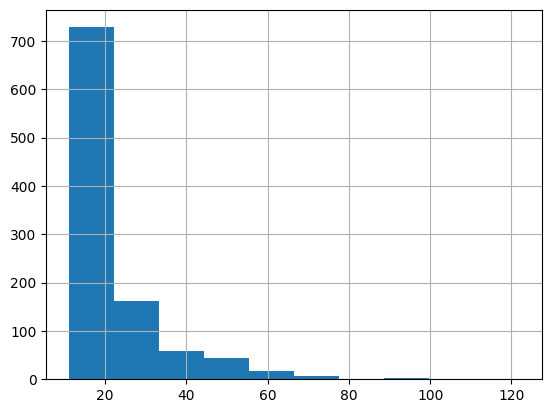

In [71]:
df_final[df_final["qtd_total_fechado_a_vista"]>10].qtd_total_fechado_a_vista.hist()

In [72]:
## Id base
df_final[["cpf_cnpj","id_base","base_carne","base_cartao"]].sample(10)
df_cartao[df_cartao["cpf_cnpj"]==9614139994][["cpf_cnpj","base_cartao"]]

,cpf_cnpj,base_cartao


In [73]:
df_carne[df_carne["cpf_cnpj"]==9614139994][["cpf_cnpj","base_carne"]]

,cpf_cnpj,base_carne


In [74]:
#65205090944 (carne e cartao) # 45985847268 (cartao) # 10311896960 (carne) # 9614139994 (nenhum)

In [75]:
# Criar variáveis:
# Último pagamento (Qual foi o ultimo pagamento do cliente)
# tempo do primeiro até o ultimo contrato (Aqui teriamos que pegar a última parcela que a pessoa pagou)
# tempo desde a última inadimplência - Contratos inadimplentes qual foi a data do último pagamento
# Frequencia de contratos por ano
# Há intersecção entre contratos
# Seguro
#Obs: Para a variavel dias de atraso do Cartão e Carnê considerar o maior valor
# Clientes que nem pagam o contrato mais já ficam em renegociação
# servicos_financeiros
# medias de atraso em dias antes de ser inadimplente (médias altas é um indicativo de que o cliente ficará em situação de inadimplência))

# Validação - Inadimplentes e clientes em reneg

In [76]:
teste = df_final[(df_final["qtd_contratos_regular"] > 0) | (df_final["qtd_contratos_atraso"] > 5)]
teste=teste[["cpf_cnpj","inad_e_reneg",'qtd_em_atraso_fechado_emprestimo','qtd_em_atraso_fechado_financiamento','qtd_em_atraso_fechado_reneg_emprestimo','qtd_em_atraso_fechado_reneg_financiamento',
    'qtd_em_atraso_aberto_emprestimo', 'qtd_em_atraso_aberto_financiamento','qtd_em_atraso_aberto_reneg_emprestimo','qtd_em_atraso_aberto_reneg_financiamento'
                ]]
teste=teste[(teste["inad_e_reneg"] == "SIM")]
#teste.sample(n=20, random_state=42)

In [77]:
teste[teste["cpf_cnpj"]==80068461976]

,cpf_cnpj,inad_e_reneg,qtd_em_atraso_fechado_emprestimo,qtd_em_atraso_fechado_financiamento,qtd_em_atraso_fechado_reneg_emprestimo,qtd_em_atraso_fechado_reneg_financiamento,qtd_em_atraso_aberto_emprestimo,qtd_em_atraso_aberto_financiamento,qtd_em_atraso_aberto_reneg_emprestimo,qtd_em_atraso_aberto_reneg_financiamento
34,80068461976.00,SIM,1.00,0.00,1.00,0.00,0.00,0.00,6.00,0.00


In [78]:
df_cartao[df_cartao["cpf_cnpj"]==80068461976]

,cpf_cnpj,numero_contrato,ano_mes_movimento,data_movimento,data_contrato,modalidade,tipo_acordo,dias_carencia,taxa_juros,cet,saldo_contabil,dias_maior_atraso_aberto,dias_maior_atraso,media_atraso,qtd_parcelas,qtd_parcelas_abertas,qtd_parcelas_pagas,valor_pago,data_ultimo_pagamento,juros_pagos_atraso,valor_parcela,data_vencimento_prox_parcela,data_vencimento_ultima_parcela,valor_calculado,valor_desconto,principal_total,valor_financiado,tipo_operacao,flag_renegociacao,creditos_a_vencer,creditos_vencidos,produto,ind_reneg,valor_da_parcela_aberto,valor_principal_total_aberto,valor_pago_nr,valor_principal_total_reneg,valor_principal_total_nr,ind_tipo_acordo,ind_rotativo,qtd_parcelas_pagas_nr,base_cartao,avg_dias_maior_atraso,sum_ind_tipo_acordo_i,sum_ind_rotativo,diff_data_pag_ult_parc
86138,80068461976.00,12522198.00,2025-07,2025-07-31,2022-06-15,5,NaN,30,14.90,17.60,0.00,0,31,31.00,1,0,1,497.63,2022-08-15,0.00,497.63,NaT,2022-07-15,0.00,0.00,433.10,497.63,ROTATIVO,SIM,0.00,0.00,RENEG_EMPRESTIMO,1,0.00,0.00,0.00,433.10,0.00,0,1,0,1,51.19,0,1,-31.00
127562,80068461976.00,2133178.00,2025-07,2025-07-31,2022-05-07,1,NaN,39,0.00,0.00,0.00,0,0,0.00,1,0,1,190.00,2022-06-15,0.00,190.00,NaT,2022-06-15,0.00,0.00,190.00,190.00,AVISTA,NAO,0.00,0.00,FINANCIAMENTO,0,0.00,0.00,190.00,0.00,190.00,0,0,1,1,51.19,0,1,0.00
230997,80068461976.00,357496.00,2025-07,2025-07-31,2024-02-16,4,R,28,2.20,2.38,361.60,411,80,49.00,23,20,3,54.24,2024-06-03,0.00,18.08,2024-06-15,2026-01-15,316.54,0.00,316.54,415.84,ACORDO,SIM,108.48,253.12,RENEG_EMPRESTIMO,1,18.08,316.54,0.00,316.54,0.00,0,0,0,1,51.19,0,1,12.00
353486,80068461976.00,389891.00,2025-07,2025-07-31,2024-06-04,4,R,11,2.20,2.36,976.12,411,0,0.00,23,23,0,0.00,NaT,0.00,42.44,2024-06-15,2026-04-15,743.15,0.00,743.15,976.12,ACORDO,SIM,381.96,594.16,RENEG_EMPRESTIMO,1,42.44,743.15,0.00,743.15,0.00,0,0,0,1,51.19,0,1,NaN
372349,80068461976.00,205664.00,2025-07,2025-07-31,2022-08-15,4,R,31,7.99,8.16,0.00,0,28,26.00,6,0,6,729.12,2023-02-09,0.00,121.52,NaT,2023-02-15,556.04,0.00,556.04,729.12,ACORDO,SIM,0.00,0.00,RENEG_EMPRESTIMO,1,0.00,0.00,0.00,556.04,0.00,0,0,0,1,51.19,0,1,6.00
412161,80068461976.00,219294.00,2025-07,2025-07-31,2022-10-17,4,R,29,7.99,8.32,0.00,0,28,28.00,2,0,2,246.46,2022-12-13,0.00,123.23,NaT,2022-12-15,218.22,0.00,218.22,246.46,ACORDO,SIM,0.00,0.00,RENEG_EMPRESTIMO,1,0.00,0.00,0.00,218.22,0.00,0,0,0,1,51.19,0,1,2.00
432991,80068461976.00,352062.00,2025-07,2025-07-31,2024-02-01,4,R,14,2.20,2.37,314.83,411,80,49.00,23,19,4,66.28,2024-06-03,0.00,16.57,2024-06-15,2025-12-15,290.11,0.00,290.11,381.11,ACORDO,SIM,82.85,231.98,RENEG_EMPRESTIMO,1,16.57,290.11,0.00,290.11,0.00,0,0,0,1,51.19,0,1,12.00
440875,80068461976.00,332593.00,2025-07,2025-07-31,2023-11-28,4,R,0,2.99,3.29,517.32,411,80,35.00,13,6,7,667.32,2024-06-03,0.00,86.22,2024-06-15,2024-11-15,946.82,0.00,946.82,1034.64,ACORDO,SIM,0.00,517.32,RENEG_EMPRESTIMO,1,86.22,946.82,0.00,946.82,0.00,0,0,0,1,51.19,0,1,12.00
459229,80068461976.00,231681.00,2025-07,2025-07-31,2022-12-13,4,R,3,4.90,5.08,456.47,411,104,37.00,25,7,18,1208.57,2024-06-03,0.00,65.21,2024-06-15,2024-12-15,1018.23,35.55,982.68,1565.04,ACORDO,SIM,0.00,456.47,RENEG_EMPRESTIMO,1,65.21,982.68,0.00,982.68,0.00,0,0,0,1,51.19,0,1,12.00
461857,80068461976.00,2484748.00,2025-07,2025-07-31,2023-02-10,3,NaN,33,11.99,12.69,0.00,0,104,34.00,12,0,12,1226.52,2024-02-15,0.00,102.21,NaT,2024-02-15,0.00,0.00,600.00,1226.52,EMPRESTIMO,NAO,0.00,0.00,EMPRESTIMO,0,0.00,0.00,1226.52,0.00,600.00,0,0,12,1,51.19,0,1,0.00


In [79]:
df_carne[df_carne["cpf_cnpj"]==80068461976]

,cpf_cnpj,id_contrato,anomes,conceito,id_financeira,data,id_agente,dias_carencia,taxajuros,cet,saldo_contabil,dias_maior_atraso,dias_maior_atraso_aberto,media_atraso,qtd_parcelas,qtd_parcelas_abertas,qtd_parcelas_pagas,valor_entrada,valor_pago,valor_pago_atraso,valor_parcela,data_vencimento_prox_parcela,data_vencimento_ultima_parcela,principal_total,servicos_financeiros,flag_renegociacao,creditos_a_vencer,creditos_vencidos,parceladatapagto,produto,ind_reneg,valor_da_parcela_aberto,valor_principal_total_aberto,valor_pago_nr,valor_principal_total_reneg,valor_principal_total_nr,valor_entrada_nr,qtd_parcelas_pagas_nr,base_carne,cpf_digitos,qtd_digitos
370077,80068461976.00,11767822002.00,2025/07,4,3328760.00,2022-04-20,005 KREDILIG (CP),30,9.75,10.88,0.00,53,0,16.00,14,0,14,0.00,680.50,39.65,46.00,NaT,2023-06-20,340.49,0.00,NAO,0.00,0.00,2023-06-22,EMPRESTIMO,0,0.00,0.00,680.50,0.00,340.49,0.00,14,1,80068461976,11


In [80]:
df_final[df_final["cpf_cnpj"]==80068461976]

,ano_mes_movimento,data_movimento,cpf_cnpj,sexo,idade,estado_civil,grau_escolaridade,profissao,natureza_ocupacao,renda_digitada,renda_valida,nacionalidade,uf_nascimento,cidade_nascimento,uf_residencia,cidade_residencia,filial,tempo_relacionamento_kredilig,tempo_inatividade_conta_cartao,tempo_inatividade_conta_carne,blacklist,data_abertura_conta,situacao_conta,motivo_situacao_conta,canal_origem,nivel_de_risco,score,origem_score,limite_total,limite_a_vista,limite_saque,limite_mensal,limite_total_utilizado,limite_a_vista_utilizado,limite_saque_utilizado,limite_mensal_utilizado,limite_total_disponivel,limite_a_vista_disponivel,limite_saque_disponivel,limite_mensal_disponivel,data_ultima_alteracao_limite,origem_alteracao_limite,historico_alteracao,situacao_fatura,historico_cobranca,qtd_total_fechado_emprestimo,qtd_total_fechado_financiamento,qtd_total_fechado_reneg_emprestimo,qtd_total_fechado_reneg_financiamento,qtd_em_atraso_fechado_emprestimo,qtd_em_atraso_fechado_financiamento,qtd_em_atraso_fechado_reneg_emprestimo,qtd_em_atraso_fechado_reneg_financiamento,qtd_total_aberto_emprestimo,qtd_total_aberto_financiamento,qtd_total_aberto_reneg_emprestimo,qtd_total_aberto_reneg_financiamento,qtd_em_atraso_aberto_emprestimo,qtd_em_atraso_aberto_financiamento,qtd_em_atraso_aberto_reneg_emprestimo,qtd_em_atraso_aberto_reneg_financiamento,mean_media_atraso,first_data,last_data,sum_qtd_parcelas_pagas,sum_qtd_parcelas_abertas,sum_valor_da_parcela_aberto,sum_valor_principal_total_aberto,sum_principal_total,sum_creditos_a_vencer,sum_creditos_vencidos,sum_valor_pago_nr,sum_valor_principal_total_reneg,max_dias_maior_atraso,max_dias_maior_atraso_aberto,sum_valor_principal_total_nr,max_data_ultimo_pagamento,sum_qtd_parcelas_pagas_nr,data_ultimo_atraso,media_meses_entre_contratos_combinado,media_meses_entre_contratos_reneg,data_reneg_aberto,valor_entrada_nr,conceito,base_carne,base_cartao,qtd_contratos_regular,qtd_contratos_atraso,qtd_contratos,qtd_contratos_nr,FINANCIAMENTO_regular,EMPRESTIMO_regular,RENEG_regular,FINANCIAMENTO_atraso,EMPRESTIMO_atraso,RENEG_atraso,FINANCIAMENTO,EMPRESTIMO,RENEG,FINANCIAMENTO_aberto,EMPRESTIMO_aberto,RENEG_aberto,qtd_contratos_aberto_atraso,qtd_contratos_aberto_regular,qtd_contratos_fechado_atraso,qtd_contratos_fechado_regular,qtd_reneg_aberto_atraso,qtd_reneg_aberto_regular,qtd_reneg_fechado_atraso,qtd_reneg_fechado_regular,valor_da_parcela_aberto,principal_total_aberto,principal_total_fechado,qtd_parcelas_pagas,qtd_parcelas_pagas_nr,qtd_parcelas_aberta,creditos_a_vencer,creditos_vencidos,valor_pago_nr,valor_principal_total_reneg,valor_principal_total_nr,amortizacao,FIN_valor_medio_entrada_nr,media_atraso_dias,dias_maior_atraso,dias_maior_atraso_aberto,inad_e_reneg,inad,produtos,produtos_ativos,qtd_total_fechado_a_vista,id_base,data_ultimo_contrato,data_primeiro_contrato,ultimo_dia_fechamento,meses_ultimo_pagamento,meses_entre_primeiro_e_ultimo_pagamento,meses_entre_primeiro_e_ultimo_fechamento,tempo_ultimo_atraso_meses,tempo_relacionamento_kredilig_meses
34,2025-07,2025-07-31,80068461976.00,M,43,SOLTEIRO,NaN,OPERADOR DE PRODUCAO,"EMPREGADO SETOR PRIVADO,EXCETO INSTITUICAO FINANC",3424.00,0.00,ESTRANGEIRO,XX,REPUBLICA DO HAITI,SC,CRICIUMA,26,1251,423,770,NAO,NaT,Bloqueada,ATRASO B,Fisico,N12,555.00,"EXTERNO, SPC",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaT,Alteracao,REDUCAO DE LIMITES,A,NaN,1.00,3.00,5.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6.00,0.00,28.47,2022-04-20,2024-06-04,85.00,81.00,260.06,3501.40,7082.73,573.29,2242.29,2376.02,5673.24,104.00,411.00,1409.49,2024-06-03,29.00,2024-02-16,2.47,2.18,2024-06-04,0.00,4,1.00,16.00,9.00,8.00,17.00,5.00,1,1,1,0,1,1,1,1,1,0,1,1,0.00,0.00,1.00,4.00,6.00,0.00,1.00,5.00,260.06,3501.40,3581.33,85.00,29.00,81.00,573.29,2242.29,2376.02,5673.24,1409.49,-3297.22,0.00,28.47,104.00,411.00,SIM,NAO,EMPRESTIMO/FINANCIAMENTO,EMPRESTIMO,3.00,base_carne/base_cartao,2024-06-04,2022-04-20,2025-07-31,14.00,26.00,40.00,18.00,42.00


# Excluir campos

In [81]:
# Drop de colunas que não serão mais utilizadas
colunas_para_remover = [
"ano_mes_movimento","uf_nascimento","cidade_nascimento",

'qtd_total_fechado_emprestimo', 'qtd_total_fechado_financiamento','qtd_total_fechado_reneg_emprestimo','qtd_total_fechado_reneg_financiamento',
'qtd_em_atraso_fechado_emprestimo','qtd_em_atraso_fechado_financiamento','qtd_em_atraso_fechado_reneg_emprestimo','qtd_em_atraso_fechado_reneg_financiamento',
'qtd_total_aberto_emprestimo', 'qtd_total_aberto_financiamento','qtd_total_aberto_reneg_emprestimo','qtd_total_aberto_reneg_financiamento',
'qtd_em_atraso_aberto_emprestimo', 'qtd_em_atraso_aberto_financiamento','qtd_em_atraso_aberto_reneg_emprestimo','qtd_em_atraso_aberto_reneg_financiamento', 

"EMPRESTIMO_aberto", "FINANCIAMENTO_aberto",     

'mean_media_atraso','first_data', 'last_data', 'sum_qtd_parcelas_pagas','sum_qtd_parcelas_abertas', 'sum_valor_da_parcela_aberto',
'sum_valor_principal_total_aberto', 'sum_principal_total','sum_creditos_a_vencer', 'sum_creditos_vencidos', 'sum_valor_pago_nr',
'sum_valor_principal_total_reneg', 'max_dias_maior_atraso',"max_dias_maior_atraso_aberto",'sum_valor_principal_total_nr', 'data_ultimo_atraso', 
"sum_qtd_parcelas_pagas_nr",

"base_carne","base_cartao","valor_entrada_nr","qtd_de_contratos_nr_basecarne","tempo_relacionamento_kredilig"
]

df_final.drop(columns=[col for col in colunas_para_remover if col in df_final.columns], inplace=True)

In [82]:
df_final.head()

,data_movimento,cpf_cnpj,sexo,idade,estado_civil,grau_escolaridade,profissao,natureza_ocupacao,renda_digitada,renda_valida,nacionalidade,uf_residencia,cidade_residencia,filial,tempo_inatividade_conta_cartao,tempo_inatividade_conta_carne,blacklist,data_abertura_conta,situacao_conta,motivo_situacao_conta,canal_origem,nivel_de_risco,score,origem_score,limite_total,limite_a_vista,limite_saque,limite_mensal,limite_total_utilizado,limite_a_vista_utilizado,limite_saque_utilizado,limite_mensal_utilizado,limite_total_disponivel,limite_a_vista_disponivel,limite_saque_disponivel,limite_mensal_disponivel,data_ultima_alteracao_limite,origem_alteracao_limite,historico_alteracao,situacao_fatura,historico_cobranca,max_data_ultimo_pagamento,media_meses_entre_contratos_combinado,media_meses_entre_contratos_reneg,data_reneg_aberto,conceito,qtd_contratos_regular,qtd_contratos_atraso,qtd_contratos,qtd_contratos_nr,FINANCIAMENTO_regular,EMPRESTIMO_regular,RENEG_regular,FINANCIAMENTO_atraso,EMPRESTIMO_atraso,RENEG_atraso,FINANCIAMENTO,EMPRESTIMO,RENEG,RENEG_aberto,qtd_contratos_aberto_atraso,qtd_contratos_aberto_regular,qtd_contratos_fechado_atraso,qtd_contratos_fechado_regular,qtd_reneg_aberto_atraso,qtd_reneg_aberto_regular,qtd_reneg_fechado_atraso,qtd_reneg_fechado_regular,valor_da_parcela_aberto,principal_total_aberto,principal_total_fechado,qtd_parcelas_pagas,qtd_parcelas_pagas_nr,qtd_parcelas_aberta,creditos_a_vencer,creditos_vencidos,valor_pago_nr,valor_principal_total_reneg,valor_principal_total_nr,amortizacao,FIN_valor_medio_entrada_nr,media_atraso_dias,dias_maior_atraso,dias_maior_atraso_aberto,inad_e_reneg,inad,produtos,produtos_ativos,qtd_total_fechado_a_vista,id_base,data_ultimo_contrato,data_primeiro_contrato,ultimo_dia_fechamento,meses_ultimo_pagamento,meses_entre_primeiro_e_ultimo_pagamento,meses_entre_primeiro_e_ultimo_fechamento,tempo_ultimo_atraso_meses,tempo_relacionamento_kredilig_meses
0,2025-07-31,11522898700.00,M,36,SOLTEIRO,ENSINO MEDIO 2º GRAU COM,ELETRICISTA DE INSTALACOES,AUTONOMO SEM VINCULO EMPREGO,3000.00,0.00,BRASILEIRO,SC,LAGUNA,33,701,701,NAO,2018-08-09,Bloqueada,ATRASO B,Fisico,N6,803.00,"EXTERNO, SPC",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2023-01-02,Alteracao,ATUALIZACAO DE SALDO,A,NaN,NaT,NaN,NaN,NaT,NaN,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,0.00,0.00,0.00,NAO,NAO,NENHUM,NENHUM,0.00,nenhum,NaT,NaT,2025-07-31,NaN,NaN,NaN,NaN,84.00
1,2025-07-31,60975377949.00,M,64,CASADO,ENSINO MEDIO 2º GRAU COM,ENGENHEIRO AGRONOMO,"EMPREGADO SETOR PRIVADO,EXCETO INSTITUICAO FINANC",10780.30,0.00,BRASILEIRO,SC,FLORIANOPOLIS,5,399,1237,NAO,2022-12-03,Ativa,PAGTO,Fisico,A2,942.00,BEHAVIOR,12000.00,2160.00,4800.00,885.00,0.00,0.00,0.00,0.00,12000.00,2160.00,4800.00,885.00,NaT,Alteracao,REDUCAO DE LIMITES,L,NaN,2023-02-08,NaN,NaN,NaT,NaN,1.00,0.00,1.00,1.00,1,0,0,0,0,0,1,0,0,0,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,4463.40,10.00,10.00,0.00,0.00,0.00,4463.40,0.00,4463.40,4463.40,0.00,2.00,4.00,0.00,NAO,NAO,FINANCIAMENTO,NENHUM,0.00,base_cartao,2022-03-12,2022-03-12,2025-07-31,30.00,11.00,41.00,NaN,41.00
2,2025-07-31,2752237952.00,F,71,CASADO,ENSINO FUNDAMENTA 1º GRAU COMP,AUXILIAR DE PESSOAL,APOSENTADO EMPRESA PRIVADA,2500.00,0.00,BRASILEIRO,SC,JARAGUA DO SUL,49,26,26,NAO,NaT,Ativa,NaN,Fisico,A2,945.00,BEHAVIOR,7260.00,1307.00,2541.00,476.00,680.00,68.00,0.00,68.00,6580.00,1239.00,2541.00,408.00,2025-05-07,Alteracao,ATUALIZACAO DE SALDO,L,NaN,2025-06-08,8.93,NaN,NaT,10,6.00,0.00,6.00,5.00,1,1,1,0,0,0,1,1,1,0,0.00,1.00,0.00,4.00,0.00,0.00,0.00,1.00,68.00,564.00,8250.05,34.00,33.00,10.00,680.00,0.00,6929.45,1699.90,7114.15,5229.55,0.00,0.50,6.00,0.00,NAO,NAO,EMPRESTIMO/FINANCIAMENTO,FINANCIAMENTO,1.00,base_carne/base_cartao,2025-07-05,2022-07-29,2025-07-31,2.00,35.00,37.00,NaN,37.00
3,2025-07-31,24645605968.00,M,71,CASADO,ENSINO MEDIO 2º GRAU COM,APOSENTADO,APOSENTADO EMPRESA PUBLICA,3365.92,0.00,BRASI

# Validação - Renda CAGED

In [83]:
#df_final.drop(columns=["CAGED"], inplace=True)

In [84]:
# Tabela de Rendas por profissões
import unicodedata # Tirar acentos das profissões

# Função para remover acentos
def remover_acentos(texto):
    if isinstance(texto, str):
        return ''.join(
            c for c in unicodedata.normalize('NFKD', texto)
            if not unicodedata.combining(c)
        )
    return texto

caminho= "C:/Users/fernando.monteiro/deep-torch-example/KAB/Relatórios/Nova_Renda_salarios_caged_2025.xlsx"
df_renda = pd.read_excel(
    caminho, sheet_name="entrar_python"
)

# Dicionário com mapeamentos
mapeamento = {
        "TÉCNICO DE INFORMÁTICA":"TECNICODE INFORMATICA",
        "TÉCNICO EM RADIOLOGIA E IMAGEM":"TECNICO EM RADIOLOGIA E IMAGENOLOGIA",
        "COSTUREIRA ROUPAS COURO. PELE. MAQCONFER":"COSTROUPAS COURO. PELE. MAQCONFER",
        "MOTOCICLISTA. MOTOBOY. MOTOTAXISTA":"MOTOCICLISTA. MOTO-BOY. MOTO-TAXISTA",
        "PROFESSOR DE EDUCAÇÃO ENSINO FUNDAM(1A-4ASERIE)":"PROFESEDUCENSINO FUNDAM(1A-4ASERIE)",
        "AGENTE DE SEGURANÇA PENITENCIARIA - CARCEREIRO":"AGENTE DE SEGURANCA PENITENCIARIA - CARCEIREIRO",
        "SUPERVISOR DE DESENVOLVIMENTO DE SISTEMAS DA INFORMAÇÃO":"SUPERVISOR DE DESENVOLVIMENTO DE SISTEMAS DA INF",
        "COBRADOR TRANSPORTE COLETIVOS(EXCETO TREM)":"COBRADOR TRANSPCOLETIVOS(EXCETO TREM)",
        "TECNDESPORTO INDIV./COLET(EXCFUTEBOL)":"TECNDESPORTO INDIV/COLET(EXCFUTEBOL)",
        "CAMINHONEIRO AUTONÔMO(ROTAS REGINTERNAC)":"CAMINHAUTONOMO(ROTAS REGINTERNAC)",
        "GERENTE DE LOGÍSTICA (ARMAZÉM E DISTR)":"GERENTE DE LOGISTICA (ARMAZEN E DISTR)",
        "REPARADOR APARELHO ELETRÔNICOS E TELECOMUNIÇÃO":"REPARADOR APAREL ELETRONICOS E TELECOMUN",
        "AUXILIAR LABORATÓRIO ANALISES FÍSICO-QUIM":"AUXLABORATORIO ANALISES FISICO-QUIM",
        "ANALISTA CREDITO (Instituições Financeiras)":"ANALISTA CREDITO",
        "ANALISTA DE COBRANÇA (Instituições Financeiras)":"ANALISTA COBRANCA",
        "AUXILIAR RADIOLÓGIA E OPERADOR RX":"AUXRADIOLOGIA E OPERADOR RX",
        "OFICIAL DA POLICIA MILITAR":"OFICIAL DA POLICIA MITITAR",
        "CRIADOR DE CAMARÕES MEXILHÕES. OSTRAS. PEIXES":"CRIADOR DE CAMAROES.MEXILHOES. OSTRAS. PEIXES",
        "SALGADOR DE ALIMENTOS":"SALGADOR DE ALIMENTOS",
        "GERENTE DE PROJETOS DE TÉCNOLOGIA INFORMAÇÃO":"GERENTE DE PROJETOS DE TECNOLINFORMACAO",
        "SUPERVISOR TESOURARIA FINANCEIRO":"SUPERVISOR TESOURARIA FINANC",
        "GERENTE DE PRODUÇÃO DE TÉCNOLOGIA DA INFORMAÇÃO":"GERENTE DE PRODDE TECNOL DA INFORMACAO",
        "OPERADOR DE EQUIPAMENTOS MÉDICOS":"OPERADOR DE EQUIP MEDICOS",
        "CINEGRAFISTA":"CINEFRAFISTA",
        "CONFECCIONADOR DE INSTRUMENTOS":"CONFECCIONADORDE INSTRUMENTOS",
        "TÉCNICO MANUTENÇÃO INSTRUMENTO MEDIÇÃO. PRECISÃO":"TECMANUTINSTRUMMEDICAO. PRECISAO",
        "MARTELEIRO":"MARTELETEIRO",
        "TÉCNICO MANUTENÇÃO EQUIPAMENTO INSTRUMENTO MÉDICO-HOSPIT":"TECMANUTEQUIPINSTRUMMEDICO-HOSPIT",
        "SALSICHA(FABRICAÇÃO LINGUIÇA SALSICHA. PROXIMAL)":"SALSIC(FABRICLINGSALSICHA. PRODIMIL)",
}

df_renda['cargo'] = df_renda['cargo'].replace(mapeamento)

df_renda['cargo_sem_acento'] = df_renda['cargo'].apply(remover_acentos)
df_renda['cargo_sem_acento'] = df_renda['cargo_sem_acento'].str.strip()
df_renda = df_renda.rename(columns={'cargo_sem_acento': 'profissao'})
df_renda=df_renda[['profissao','CAGED']]
df_renda['CAGED'] = pd.to_numeric(df_renda['CAGED'], errors='coerce')

# Join do df_final com a tabela de rendas
df_renda['profissao'] = df_renda['profissao'].str.strip()
df_final = df_final.merge(df_renda, on="profissao", how="left")

In [85]:
df_final.head(5)

,data_movimento,cpf_cnpj,sexo,idade,estado_civil,grau_escolaridade,profissao,natureza_ocupacao,renda_digitada,renda_valida,nacionalidade,uf_residencia,cidade_residencia,filial,tempo_inatividade_conta_cartao,tempo_inatividade_conta_carne,blacklist,data_abertura_conta,situacao_conta,motivo_situacao_conta,canal_origem,nivel_de_risco,score,origem_score,limite_total,limite_a_vista,limite_saque,limite_mensal,limite_total_utilizado,limite_a_vista_utilizado,limite_saque_utilizado,limite_mensal_utilizado,limite_total_disponivel,limite_a_vista_disponivel,limite_saque_disponivel,limite_mensal_disponivel,data_ultima_alteracao_limite,origem_alteracao_limite,historico_alteracao,situacao_fatura,historico_cobranca,max_data_ultimo_pagamento,media_meses_entre_contratos_combinado,media_meses_entre_contratos_reneg,data_reneg_aberto,conceito,qtd_contratos_regular,qtd_contratos_atraso,qtd_contratos,qtd_contratos_nr,FINANCIAMENTO_regular,EMPRESTIMO_regular,RENEG_regular,FINANCIAMENTO_atraso,EMPRESTIMO_atraso,RENEG_atraso,FINANCIAMENTO,EMPRESTIMO,RENEG,RENEG_aberto,qtd_contratos_aberto_atraso,qtd_contratos_aberto_regular,qtd_contratos_fechado_atraso,qtd_contratos_fechado_regular,qtd_reneg_aberto_atraso,qtd_reneg_aberto_regular,qtd_reneg_fechado_atraso,qtd_reneg_fechado_regular,valor_da_parcela_aberto,principal_total_aberto,principal_total_fechado,qtd_parcelas_pagas,qtd_parcelas_pagas_nr,qtd_parcelas_aberta,creditos_a_vencer,creditos_vencidos,valor_pago_nr,valor_principal_total_reneg,valor_principal_total_nr,amortizacao,FIN_valor_medio_entrada_nr,media_atraso_dias,dias_maior_atraso,dias_maior_atraso_aberto,inad_e_reneg,inad,produtos,produtos_ativos,qtd_total_fechado_a_vista,id_base,data_ultimo_contrato,data_primeiro_contrato,ultimo_dia_fechamento,meses_ultimo_pagamento,meses_entre_primeiro_e_ultimo_pagamento,meses_entre_primeiro_e_ultimo_fechamento,tempo_ultimo_atraso_meses,tempo_relacionamento_kredilig_meses,CAGED
0,2025-07-31,11522898700.00,M,36,SOLTEIRO,ENSINO MEDIO 2º GRAU COM,ELETRICISTA DE INSTALACOES,AUTONOMO SEM VINCULO EMPREGO,3000.00,0.00,BRASILEIRO,SC,LAGUNA,33,701,701,NAO,2018-08-09,Bloqueada,ATRASO B,Fisico,N6,803.00,"EXTERNO, SPC",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2023-01-02,Alteracao,ATUALIZACAO DE SALDO,A,NaN,NaT,NaN,NaN,NaT,NaN,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,0.00,0.00,0.00,NAO,NAO,NENHUM,NENHUM,0.00,nenhum,NaT,NaT,2025-07-31,NaN,NaN,NaN,NaN,84.00,2088.00
1,2025-07-31,60975377949.00,M,64,CASADO,ENSINO MEDIO 2º GRAU COM,ENGENHEIRO AGRONOMO,"EMPREGADO SETOR PRIVADO,EXCETO INSTITUICAO FINANC",10780.30,0.00,BRASILEIRO,SC,FLORIANOPOLIS,5,399,1237,NAO,2022-12-03,Ativa,PAGTO,Fisico,A2,942.00,BEHAVIOR,12000.00,2160.00,4800.00,885.00,0.00,0.00,0.00,0.00,12000.00,2160.00,4800.00,885.00,NaT,Alteracao,REDUCAO DE LIMITES,L,NaN,2023-02-08,NaN,NaN,NaT,NaN,1.00,0.00,1.00,1.00,1,0,0,0,0,0,1,0,0,0,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,4463.40,10.00,10.00,0.00,0.00,0.00,4463.40,0.00,4463.40,4463.40,0.00,2.00,4.00,0.00,NAO,NAO,FINANCIAMENTO,NENHUM,0.00,base_cartao,2022-03-12,2022-03-12,2025-07-31,30.00,11.00,41.00,NaN,41.00,5467.00
2,2025-07-31,2752237952.00,F,71,CASADO,ENSINO FUNDAMENTA 1º GRAU COMP,AUXILIAR DE PESSOAL,APOSENTADO EMPRESA PRIVADA,2500.00,0.00,BRASILEIRO,SC,JARAGUA DO SUL,49,26,26,NAO,NaT,Ativa,NaN,Fisico,A2,945.00,BEHAVIOR,7260.00,1307.00,2541.00,476.00,680.00,68.00,0.00,68.00,6580.00,1239.00,2541.00,408.00,2025-05-07,Alteracao,ATUALIZACAO DE SALDO,L,NaN,2025-06-08,8.93,NaN,NaT,10,6.00,0.00,6.00,5.00,1,1,1,0,0,0,1,1,1,0,0.00,1.00,0.00,4.00,0.00,0.00,0.00,1.00,68.00,564.00,8250.05,34.00,33.00,10.00,680.00,0.00,6929.45,1699.90,7114.15,5229.55,0.00,0.50,6.00,0.00,NAO,NAO,EMPRESTIMO/FINANCIAMENTO,FINANCIAMENTO,1.00,base_carne/base_cartao,2025-07-05,2022-07-29,2025-07-31,2.00,35.00,37.00,NaN,37.00,2178.52
3,2025-07-31,24645605968.00,M,71,CASADO,ENSINO MEDIO 2º GRAU COM,APOSENTADO,APOSENTADO EMPR

In [86]:
df_final[df_final["CAGED"].isnull()].profissao.value_counts(dropna=False)

profissao
NaN    3834
Name: count, dtype: int64

In [87]:
df_final[df_final["CAGED"].isnull()]["profissao"].unique().tolist()

[nan]

In [88]:
# Regra 1: dividir por 100 renda valida maior que 30mil
df_final["renda_valida_new"] = np.where(
    (df_final["renda_valida"] > 30000),
    df_final["renda_valida"] / 100,
    df_final["renda_valida"])

# Regra 2: Considerar o menor valor entre a renda valida e a renda digitada - para renda valida entre 10mil e 30mil
df_final["renda_valida_new"] = np.where(
    ((df_final["renda_valida"] >= 10000) & (df_final["renda_valida"] <= 30000)),
    df_final[["renda_digitada","renda_valida"]].min(axis=1, skipna=True),
    df_final["renda_valida_new"])

# Regra 3: Se a renda Valida for igual a zero tras a renda CAGED se não mantem a mesmo valor de renda
df_final["renda_valida_new"] = np.where(
    (df_final["renda_valida"] == 0),
    df_final["CAGED"],
    df_final["renda_valida_new"])

# Regra 4: Se a renda CAGED for maior que a renda válida, considera a renda CAGED, caso contrário, mantêm o mesmo valor VALIDAR
df_final["renda_valida_new"] = df_final[["renda_valida_new","CAGED"]].max(axis=1, skipna=True)

In [89]:
df_final[(df_final["renda_valida"] >= 10000) & (df_final["renda_valida"] <= 30000)][["cpf_cnpj","profissao","renda_digitada","renda_valida","renda_valida_new","CAGED"]].sample(10)

,cpf_cnpj,profissao,renda_digitada,renda_valida,renda_valida_new,CAGED
79137,4348440042.00,AUXILIAR DE ESCRITORIO. EM GERAL,26111.28,26111.28,26111.28,1940.00
130520,8244270926.00,ADVOGADO,10000.00,10000.00,10000.00,4864.00
505523,74760920900.00,SECRETARIO,10000.00,10000.00,10000.00,2245.10
542053,9909262908.00,EMPRESARIO,10000.00,10000.00,10000.00,1804.00
447833,79925596904.00,MICROEMPRESARIO,25000.00,25000.00,25000.00,1879.00
363966,25236261953.00,TECNICO DE COMUNICACAO DE DADOS,20500.00,15424.00,15424.00,2303.00
517411,88840263934.00,ADMINISTRADOR,15000.00,15000.00,15000.00,3268.11
82273,1976821975.00,LOCADOR(ALUGUEIS DE IMOVEIS),20000.00,20000.00,20000.00,2194.08
260608,5255484598.00,TRABALHADOR AGROPECUARIO OU AGRICOLA EM GERAL,150.00,15000.00,1653.00,1653.00
191111,68651384904.00,SUBTENENTE BOMBEIRO MILITAR,14000.00,11235.00,11235.00,9450.00


In [90]:
teste=df_final[df_final["cpf_cnpj"]==95197966904][["renda_valida_new","renda_valida","CAGED","profissao","renda_digitada","natureza_ocupacao"]]

In [91]:
teste

,renda_valida_new,renda_valida,CAGED,profissao,renda_digitada,natureza_ocupacao
9945,21460.00,21460.00,7600.00,CORONEL BOMBEIRO MILITAR,21460.00,"APOSENTADO MILITAR, MILITAR RESERVA OU REFORMADO"


In [92]:
df_final[df_final["renda_valida_new"]==0].profissao.value_counts(dropna=False)

Series([], Name: count, dtype: int64)

In [93]:
# renda comprometida - imputação dessa variável pode ser feita como o valor da parcela e a renda imputada
df_final["renda_comprometida"] = np.where(
    df_final["renda_valida_new"].notna() & (df_final["renda_valida_new"] != 0),
    np.round((df_final["valor_da_parcela_aberto"].fillna(0) / df_final["renda_valida_new"]) * 100, 2),
    np.nan
)
df_final[df_final["renda_comprometida"].isnull()].profissao.value_counts(dropna=False)

profissao
NaN    3718
Name: count, dtype: int64

In [94]:
df_final[["renda_comprometida","valor_da_parcela_aberto","renda_valida_new"]].sample(10) # 124% da sua renda comprometida: 62879

,renda_comprometida,valor_da_parcela_aberto,renda_valida_new
252700,0.00,0.00,2000.00
485689,0.00,0.00,1525.00
441940,4.14,100.00,2418.00
73244,0.00,0.00,4301.00
53248,21.74,401.00,1844.32
391916,0.00,0.00,1892.52
65165,0.00,0.00,1853.00
264032,0.00,0.00,1484.00
314128,8.79,218.03,2480.41
68584,8.17,207.84,2542.96


In [95]:
df_final=df_final.drop(columns=["CAGED","renda_digitada","renda_valida"])

In [96]:
df_final.renda_valida_new.describe()

count   545259.00
mean      2098.98
std        811.42
min        508.20
25%       1558.70
50%       1888.00
75%       2200.00
max      30000.00
Name: renda_valida_new, dtype: float64

In [97]:
df_cad[df_cad["cpf_cnpj"]==28864778934]

,ano_mes_movimento,data_movimento,cpf_cnpj,sexo,idade,estado_civil,grau_escolaridade,profissao,natureza_ocupacao,renda_digitada,renda_valida,nacionalidade,uf_nascimento,cidade_nascimento,uf_residencia,cidade_residencia,filial,tempo_relacionamento_kredilig,tempo_inatividade_conta_cartao,tempo_inatividade_conta_carne,blacklist,data_abertura_conta,situacao_conta,motivo_situacao_conta,canal_origem,nivel_de_risco,score,origem_score,limite_total,limite_a_vista,limite_saque,limite_mensal,limite_total_utilizado,limite_a_vista_utilizado,limite_saque_utilizado,limite_mensal_utilizado,limite_total_disponivel,limite_a_vista_disponivel,limite_saque_disponivel,limite_mensal_disponivel,data_ultima_alteracao_limite,origem_alteracao_limite,historico_alteracao,situacao_fatura,historico_cobranca
17950,2025-07,2025-07-31,28864778934.00,M,68,NaN,NaN,NaN,APOSENTADO EMPRESA PUBLICA ESTADUAL,13000.00,10314.00,BRASILEIRO,SC,NaN,SC,SAO JOSE,1000,259,24,24,NAO,NaT,Ativa,NaN,Digital,N10,671.00,"EXTERNO, SPC",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2025-07-07,Alteracao,ATUALIZACAO DE SALDO,NaN,NaN


In [98]:
df_final[df_final["cpf_cnpj"]==28864778934]

,data_movimento,cpf_cnpj,sexo,idade,estado_civil,grau_escolaridade,profissao,natureza_ocupacao,nacionalidade,uf_residencia,cidade_residencia,filial,tempo_inatividade_conta_cartao,tempo_inatividade_conta_carne,blacklist,data_abertura_conta,situacao_conta,motivo_situacao_conta,canal_origem,nivel_de_risco,score,origem_score,limite_total,limite_a_vista,limite_saque,limite_mensal,limite_total_utilizado,limite_a_vista_utilizado,limite_saque_utilizado,limite_mensal_utilizado,limite_total_disponivel,limite_a_vista_disponivel,limite_saque_disponivel,limite_mensal_disponivel,data_ultima_alteracao_limite,origem_alteracao_limite,historico_alteracao,situacao_fatura,historico_cobranca,max_data_ultimo_pagamento,media_meses_entre_contratos_combinado,media_meses_entre_contratos_reneg,data_reneg_aberto,conceito,qtd_contratos_regular,qtd_contratos_atraso,qtd_contratos,qtd_contratos_nr,FINANCIAMENTO_regular,EMPRESTIMO_regular,RENEG_regular,FINANCIAMENTO_atraso,EMPRESTIMO_atraso,RENEG_atraso,FINANCIAMENTO,EMPRESTIMO,RENEG,RENEG_aberto,qtd_contratos_aberto_atraso,qtd_contratos_aberto_regular,qtd_contratos_fechado_atraso,qtd_contratos_fechado_regular,qtd_reneg_aberto_atraso,qtd_reneg_aberto_regular,qtd_reneg_fechado_atraso,qtd_reneg_fechado_regular,valor_da_parcela_aberto,principal_total_aberto,principal_total_fechado,qtd_parcelas_pagas,qtd_parcelas_pagas_nr,qtd_parcelas_aberta,creditos_a_vencer,creditos_vencidos,valor_pago_nr,valor_principal_total_reneg,valor_principal_total_nr,amortizacao,FIN_valor_medio_entrada_nr,media_atraso_dias,dias_maior_atraso,dias_maior_atraso_aberto,inad_e_reneg,inad,produtos,produtos_ativos,qtd_total_fechado_a_vista,id_base,data_ultimo_contrato,data_primeiro_contrato,ultimo_dia_fechamento,meses_ultimo_pagamento,meses_entre_primeiro_e_ultimo_pagamento,meses_entre_primeiro_e_ultimo_fechamento,tempo_ultimo_atraso_meses,tempo_relacionamento_kredilig_meses,renda_valida_new,renda_comprometida
17950,2025-07-31,28864778934.00,M,68,NaN,NaN,NaN,APOSENTADO EMPRESA PUBLICA ESTADUAL,BRASILEIRO,SC,SAO JOSE,1000,24,24,NAO,NaT,Ativa,NaN,Digital,N10,671.00,"EXTERNO, SPC",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2025-07-07,Alteracao,ATUALIZACAO DE SALDO,NaN,NaN,2025-06-12,NaN,NaN,2024-11-11,1,1.00,0.00,1.00,0.00,1,0,1,0,0,0,1,0,1,1,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,203.00,3441.15,0.00,8.00,0.00,16.00,3248.00,0.00,0.00,3441.15,0.00,-3441.15,0.00,8.00,28.00,0.00,SIM,NAO,FINANCIAMENTO,FINANCIAMENTO,0.00,base_carne,2024-11-11,2024-11-11,2025-07-31,2.00,7.00,9.00,NaN,9.00,10314.00,1.97


In [99]:
med_sal=df_final.groupby("profissao").agg({
    "renda_valida_new":"mean"
    })
med_sal = med_sal.reset_index()


In [100]:
#med_sal.to_excel("C:/Users/fernando.monteiro/deep-torch-example/KAB/Relatórios/med_sal.xlsx", index=False)

# Validação media dos maiores atrasos até 60 dias

In [101]:
caminho= r"C:\Users\fernando.monteiro\deep-torch-example\KAB\Behavior_KAB\media_maior_atraso_202507.csv"
df_media_maior_atraso_carne = pd.read_csv(
    caminho,
    sep=";"
)
df_final = df_final.merge(df_media_maior_atraso_carne, on="cpf_cnpj", how="left")

In [102]:
df_final.head(5)

,data_movimento,cpf_cnpj,sexo,idade,estado_civil,grau_escolaridade,profissao,natureza_ocupacao,nacionalidade,uf_residencia,cidade_residencia,filial,tempo_inatividade_conta_cartao,tempo_inatividade_conta_carne,blacklist,data_abertura_conta,situacao_conta,motivo_situacao_conta,canal_origem,nivel_de_risco,score,origem_score,limite_total,limite_a_vista,limite_saque,limite_mensal,limite_total_utilizado,limite_a_vista_utilizado,limite_saque_utilizado,limite_mensal_utilizado,limite_total_disponivel,limite_a_vista_disponivel,limite_saque_disponivel,limite_mensal_disponivel,data_ultima_alteracao_limite,origem_alteracao_limite,historico_alteracao,situacao_fatura,historico_cobranca,max_data_ultimo_pagamento,media_meses_entre_contratos_combinado,media_meses_entre_contratos_reneg,data_reneg_aberto,conceito,qtd_contratos_regular,qtd_contratos_atraso,qtd_contratos,qtd_contratos_nr,FINANCIAMENTO_regular,EMPRESTIMO_regular,RENEG_regular,FINANCIAMENTO_atraso,EMPRESTIMO_atraso,RENEG_atraso,FINANCIAMENTO,EMPRESTIMO,RENEG,RENEG_aberto,qtd_contratos_aberto_atraso,qtd_contratos_aberto_regular,qtd_contratos_fechado_atraso,qtd_contratos_fechado_regular,qtd_reneg_aberto_atraso,qtd_reneg_aberto_regular,qtd_reneg_fechado_atraso,qtd_reneg_fechado_regular,valor_da_parcela_aberto,principal_total_aberto,principal_total_fechado,qtd_parcelas_pagas,qtd_parcelas_pagas_nr,qtd_parcelas_aberta,creditos_a_vencer,creditos_vencidos,valor_pago_nr,valor_principal_total_reneg,valor_principal_total_nr,amortizacao,FIN_valor_medio_entrada_nr,media_atraso_dias,dias_maior_atraso,dias_maior_atraso_aberto,inad_e_reneg,inad,produtos,produtos_ativos,qtd_total_fechado_a_vista,id_base,data_ultimo_contrato,data_primeiro_contrato,ultimo_dia_fechamento,meses_ultimo_pagamento,meses_entre_primeiro_e_ultimo_pagamento,meses_entre_primeiro_e_ultimo_fechamento,tempo_ultimo_atraso_meses,tempo_relacionamento_kredilig_meses,renda_valida_new,renda_comprometida,mean_dias_maior_atraso
0,2025-07-31,11522898700.00,M,36,SOLTEIRO,ENSINO MEDIO 2º GRAU COM,ELETRICISTA DE INSTALACOES,AUTONOMO SEM VINCULO EMPREGO,BRASILEIRO,SC,LAGUNA,33,701,701,NAO,2018-08-09,Bloqueada,ATRASO B,Fisico,N6,803.00,"EXTERNO, SPC",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2023-01-02,Alteracao,ATUALIZACAO DE SALDO,A,NaN,NaT,NaN,NaN,NaT,NaN,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,0.00,0.00,0.00,NAO,NAO,NENHUM,NENHUM,0.00,nenhum,NaT,NaT,2025-07-31,NaN,NaN,NaN,NaN,84.00,2088.00,0.00,NaN
1,2025-07-31,60975377949.00,M,64,CASADO,ENSINO MEDIO 2º GRAU COM,ENGENHEIRO AGRONOMO,"EMPREGADO SETOR PRIVADO,EXCETO INSTITUICAO FINANC",BRASILEIRO,SC,FLORIANOPOLIS,5,399,1237,NAO,2022-12-03,Ativa,PAGTO,Fisico,A2,942.00,BEHAVIOR,12000.00,2160.00,4800.00,885.00,0.00,0.00,0.00,0.00,12000.00,2160.00,4800.00,885.00,NaT,Alteracao,REDUCAO DE LIMITES,L,NaN,2023-02-08,NaN,NaN,NaT,NaN,1.00,0.00,1.00,1.00,1,0,0,0,0,0,1,0,0,0,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,4463.40,10.00,10.00,0.00,0.00,0.00,4463.40,0.00,4463.40,4463.40,0.00,2.00,4.00,0.00,NAO,NAO,FINANCIAMENTO,NENHUM,0.00,base_cartao,2022-03-12,2022-03-12,2025-07-31,30.00,11.00,41.00,NaN,41.00,5467.00,0.00,4.00
2,2025-07-31,2752237952.00,F,71,CASADO,ENSINO FUNDAMENTA 1º GRAU COMP,AUXILIAR DE PESSOAL,APOSENTADO EMPRESA PRIVADA,BRASILEIRO,SC,JARAGUA DO SUL,49,26,26,NAO,NaT,Ativa,NaN,Fisico,A2,945.00,BEHAVIOR,7260.00,1307.00,2541.00,476.00,680.00,68.00,0.00,68.00,6580.00,1239.00,2541.00,408.00,2025-05-07,Alteracao,ATUALIZACAO DE SALDO,L,NaN,2025-06-08,8.93,NaN,NaT,10,6.00,0.00,6.00,5.00,1,1,1,0,0,0,1,1,1,0,0.00,1.00,0.00,4.00,0.00,0.00,0.00,1.00,68.00,564.00,8250.05,34.00,33.00,10.00,680.00,0.00,6929.45,1699.90,7114.15,5229.55,0.00,0.50,6.00,0.00,NAO,NAO,EMPRESTIMO/FINANCIAMENTO,FINANCIAMENTO,1.00,base_carne/base_cartao,2025-07-05,2022-07-29,2025-07-31,2.00,35.00,37.00,NaN,37.00,2178.52,3.12,2.06
3,2025-07-31,24645605968.00,M,71,CASADO,ENSINO MEDIO 2º GRAU COM,APOSENTADO,A

# Validação Limites

In [103]:
caminho = "C:/Users/fernando.monteiro/OneDrive - BHS/KAB/Base Behavior/Limites/Primeiro Mês Limite Total Não Zerado.xlsx"
df_limite_prim = pd.read_excel(
    caminho, sheet_name="Sheet1"
)

caminho = "C:/Users/fernando.monteiro/OneDrive - BHS/KAB/Base Behavior/Limites/Último Mês Limite Total Não Zerado.xlsx"
df_limite_ult = pd.read_excel(
    caminho, sheet_name="Sheet1"
)

In [104]:
df_limite_prim=df_limite_prim[["Cliente CPF","Limite Total"]]
df_limite_prim=df_limite_prim.rename(columns={"Cliente CPF":"cpf_cnpj","Limite Total":"limite_total_primeiro_mes"})

In [105]:
df_limite_ult.columns

Index(['Cliente CPF', 'Cliente_NOME', 'Mês & Ano', 'Situação Conta Atual',
       'Nível de Risco Atual', 'Nível de Risco Histórico', 'Regional', 'Loja',
       'Tipo Limite Total', 'Limite Total', 'Limite Total Disponível',
       '% Limite Total Utilizado', 'Limite Saque', 'Limite Disponível Saque',
       '% Limite Saque Utilizado', 'Limite Parcelado Mensal',
       'Limite Parcelado Mensal Disponível', '% Limite Mensal Utilizado',
       'Limite À vista', 'Limite À vista Disponível',
       '% Limite  À vista Utilizado'],
      dtype='object')

In [106]:
df_limite_ult=df_limite_ult[["Cliente CPF","Limite Total","Limite Saque","Limite À vista","Limite Parcelado Mensal"]]
df_limite_ult=df_limite_ult.rename(columns={"Cliente CPF":"cpf_cnpj",
                                            "Limite Total":"limite_total_ultimo_mes",
                                            "Limite Saque":"Limite_saque_ultimo_mes",
                                            "Limite À vista":"Limite_a_vista_ultimo_mes",
                                            "Limite Parcelado Mensal":"Limite_parcelado_mensal_ultimo_mes"
                                            })

In [107]:
df_final = df_final.merge(df_limite_prim, on="cpf_cnpj", how="left")
df_final = df_final.merge(df_limite_ult, on="cpf_cnpj", how="left")

In [108]:
df_final["situacao_alteracao_limite"] = np.select(
    [
        df_final["limite_total_primeiro_mes"] > df_final["limite_total_ultimo_mes"],   
        df_final["limite_total_primeiro_mes"] < df_final["limite_total_ultimo_mes"],   
        df_final["limite_total_primeiro_mes"] == df_final["limite_total_ultimo_mes"]  
    ],
    [
        "Diminuiu",    
        "Aumentou",      
        "Manteve"       
    ],
    default="Indefinido"
)
df_final["situacao_alteracao_limite"]=df_final["situacao_alteracao_limite"].astype("category")

In [109]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548977 entries, 0 to 548976
Columns: 105 entries, data_movimento to situacao_alteracao_limite
dtypes: category(22), datetime64[ns](8), float64(58), int64(14), object(3)
memory usage: 359.8+ MB


# Validação Região

In [110]:
df_rg=pd.read_csv("C:/Users/fernando.monteiro/OneDrive - BHS/KAB/Base Behavior/Mesoregiao/Base_Microregiao.csv", sep=";", header=0, index_col=None)

In [111]:
#df_rg=pd.DataFrame()  

In [112]:
df_rg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   NM_MUN_S_ACENTO  5572 non-null   object
 1   NM_MESO          5572 non-null   object
 2   NM_MICRO         5572 non-null   object
 3   SIGLA_UF         5572 non-null   object
dtypes: object(4)
memory usage: 174.3+ KB


In [113]:
df_rg=df_rg.rename(columns={"NM_MUN_S_ACENTO": "cidade_residencia","SIGLA_UF":"uf_residencia"}).copy()

In [114]:
df_rg.head(5)

,cidade_residencia,NM_MESO,NM_MICRO,uf_residencia
0,ALTA FLORESTA D'OESTE,Leste Rondoniense,Cacoal,RO
1,ARIQUEMES,Leste Rondoniense,Ariquemes,RO
2,CABIXI,Leste Rondoniense,Colorado do Oeste,RO
3,CACOAL,Leste Rondoniense,Cacoal,RO
4,CEREJEIRAS,Leste Rondoniense,Colorado do Oeste,RO


In [115]:
df_final = df_final.merge(df_rg, on=["uf_residencia","cidade_residencia"], how="inner")

In [116]:
df_final.NM_MICRO.value_counts()

NM_MICRO
Florianópolis       151998
Joinville           109215
Itajaí               75002
Blumenau             46075
Tubarão              43064
                     ...  
Frutal                   1
Ariquemes                1
Baixo Jaguaribe          1
Baixo Cotinguiba         1
Mossoró                  1
Name: count, Length: 396, dtype: int64

In [117]:
# Dicionário de mapeamento UF -> Região
mapa_regioes = {
    # Norte
    "AC": "Norte_Centro", "AP": "Norte_Centro", "AM": "Norte_Centro", "PA": "Norte_Centro",
    "RO": "Norte_Centro", "RR": "Norte_Centro", "TO": "Norte_Centro",

    # Nordeste
    "AL": "Norte_Centro", "BA": "Norte_Centro", "CE": "Norte_Centro", "MA": "Norte_Centro",
    "PB": "Norte_Centro", "PE": "Norte_Centro", "PI": "Norte_Centro", "RN": "Norte_Centro",
    "SE": "Norte_Centro",

    # Centro-Oeste
    "DF": "Norte_Centro", "GO": "Norte_Centro", "MT": "Norte_Centro", "MS": "Norte_Centro",

    # Sudeste
    "ES": "Sudeste", "MG": "Sudeste", "RJ": "Sudeste", "SP": "Sudeste",

    # Sul
    "PR": "Sul", "RS": "Sul", "SC": "Sul"
}

# Criar nova coluna de região
df_final["REGIAO"] = df_final["uf_residencia"].map(mapa_regioes)

In [118]:
df_final.REGIAO.value_counts()

REGIAO
Sul             545264
Sudeste           1780
Norte_Centro      1547
Name: count, dtype: int64

In [119]:
df_final["REGIAO_NOVO"]=np.where(df_final["uf_residencia"]=="SC",
                                 df_final["NM_MESO"],
                                 df_final["REGIAO"])

In [120]:
df_final[["REGIAO_NOVO","REGIAO","NM_MESO","uf_residencia"]].sample(10)

,REGIAO_NOVO,REGIAO,NM_MESO,uf_residencia
544265,Grande Florianópolis,Sul,Grande Florianópolis,SC
455767,Norte Catarinense,Sul,Norte Catarinense,SC
84063,Vale do Itajaí,Sul,Vale do Itajaí,SC
194171,Norte Catarinense,Sul,Norte Catarinense,SC
206216,Vale do Itajaí,Sul,Vale do Itajaí,SC
373394,Grande Florianópolis,Sul,Grande Florianópolis,SC
53742,Vale do Itajaí,Sul,Vale do Itajaí,SC
463204,Norte Catarinense,Sul,Norte Catarinense,SC
246648,Grande Florianópolis,Sul,Grande Florianópolis,SC
540173,Norte Catarinense,Sul,Norte Catarinense,SC


In [121]:
df_final.REGIAO_NOVO.value_counts()

REGIAO_NOVO
Grande Florianópolis    164340
Vale do Itajaí          131113
Norte Catarinense       128529
Sul Catarinense          96610
Serrana                  15419
Oeste Catarinense         5634
Sul                       3619
Sudeste                   1780
Norte_Centro              1547
Name: count, dtype: int64

# Validação Antecipação

In [122]:
qtd_cartao_antecipacao.head(5)

,CPF_CNPJ,qtd_cartao_antecipacao
0,3813908.00,2
1,4034902.00,4
2,4093917.00,2
3,4538978.00,2
4,4646940.00,4


In [123]:
# fazendo um merge das qtd_cartao_antecipacao com a base final
qtd_cartao_antecipacao = qtd_cartao_antecipacao.rename(columns={"CPF_CNPJ": "cpf_cnpj"})
df_final = df_final.merge(qtd_cartao_antecipacao, on="cpf_cnpj", how="left")

In [124]:
df_final[df_final["qtd_cartao_antecipacao"]>0].sample(1,random_state=2025)

,data_movimento,cpf_cnpj,sexo,idade,estado_civil,grau_escolaridade,profissao,natureza_ocupacao,nacionalidade,uf_residencia,cidade_residencia,filial,tempo_inatividade_conta_cartao,tempo_inatividade_conta_carne,blacklist,data_abertura_conta,situacao_conta,motivo_situacao_conta,canal_origem,nivel_de_risco,score,origem_score,limite_total,limite_a_vista,limite_saque,limite_mensal,limite_total_utilizado,limite_a_vista_utilizado,limite_saque_utilizado,limite_mensal_utilizado,limite_total_disponivel,limite_a_vista_disponivel,limite_saque_disponivel,limite_mensal_disponivel,data_ultima_alteracao_limite,origem_alteracao_limite,historico_alteracao,situacao_fatura,historico_cobranca,max_data_ultimo_pagamento,media_meses_entre_contratos_combinado,media_meses_entre_contratos_reneg,data_reneg_aberto,conceito,qtd_contratos_regular,qtd_contratos_atraso,qtd_contratos,qtd_contratos_nr,FINANCIAMENTO_regular,EMPRESTIMO_regular,RENEG_regular,FINANCIAMENTO_atraso,EMPRESTIMO_atraso,RENEG_atraso,FINANCIAMENTO,EMPRESTIMO,RENEG,RENEG_aberto,qtd_contratos_aberto_atraso,qtd_contratos_aberto_regular,qtd_contratos_fechado_atraso,qtd_contratos_fechado_regular,qtd_reneg_aberto_atraso,qtd_reneg_aberto_regular,qtd_reneg_fechado_atraso,qtd_reneg_fechado_regular,valor_da_parcela_aberto,principal_total_aberto,principal_total_fechado,qtd_parcelas_pagas,qtd_parcelas_pagas_nr,qtd_parcelas_aberta,creditos_a_vencer,creditos_vencidos,valor_pago_nr,valor_principal_total_reneg,valor_principal_total_nr,amortizacao,FIN_valor_medio_entrada_nr,media_atraso_dias,dias_maior_atraso,dias_maior_atraso_aberto,inad_e_reneg,inad,produtos,produtos_ativos,qtd_total_fechado_a_vista,id_base,data_ultimo_contrato,data_primeiro_contrato,ultimo_dia_fechamento,meses_ultimo_pagamento,meses_entre_primeiro_e_ultimo_pagamento,meses_entre_primeiro_e_ultimo_fechamento,tempo_ultimo_atraso_meses,tempo_relacionamento_kredilig_meses,renda_valida_new,renda_comprometida,mean_dias_maior_atraso,limite_total_primeiro_mes,limite_total_ultimo_mes,Limite_saque_ultimo_mes,Limite_a_vista_ultimo_mes,Limite_parcelado_mensal_ultimo_mes,situacao_alteracao_limite,NM_MESO,NM_MICRO,REGIAO,REGIAO_NOVO,qtd_cartao_antecipacao
344681,2025-07-31,88744922949.00,F,77,CASADO,ENSINO MEDIO 2º GRAU COM,APOSENTADO,APOSENTADO EMPRESA PRIVADA,BRASILEIRO,SC,BALNEARIO ARROIO DO SILVA,43,909,1765,NAO,NaT,Ativa,NaN,Fisico,N8,739.00,"EXTERNO, SPC",5280.00,950.00,0.00,220.00,0.00,0.00,0.00,0.00,5280.00,950.00,0.00,220.00,2025-03-07,Alteracao,REDUCAO DE LIMITES,L,NaN,2022-12-20,NaN,NaN,NaT,NaN,1.00,0.00,1.00,0.00,0,1,1,0,0,0,0,1,1,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,432.04,1.00,0.00,0.00,0.00,0.00,0.00,432.04,0.00,-432.04,NaN,0.00,0.00,0.00,NAO,NAO,EMPRESTIMO,NENHUM,0.00,base_cartao,2022-12-21,2022-12-21,2025-07-31,32.00,0.00,32.00,NaN,59.00,1525.00,0.00,0.00,5280.00,5280.00,0.00,950.00,220.00,Manteve,Sul Catarinense,Araranguá,Sul,Sul Catarinense,1.00


# Filtro - Clientes com e sem histórico

In [ ]:
# Filtro dos clientes com histórico de cobrança e fraude
conceito_filt = [
    "50","51","52","58","92","63"
]
df_clientes_BK_HC = df_final[(df_final["blacklist"]=="SIM") | 
                              (df_final["historico_cobranca"].notnull()) |
                              (df_final["conceito"].isin(conceito_filt))]

# Filtro dos clientes com histórico de contratos
df_clientes_historico = df_final[(df_final["qtd_contratos_regular"] > 0) | (df_final["qtd_contratos_atraso"] > 0)]
df_clientes_historico = df_clientes_historico[~((df_final["blacklist"]=="SIM") | 
                              (df_final["historico_cobranca"].notnull()) |
                              (df_final["conceito"].isin(conceito_filt)))]

# Filtro dos clientes sem histórico de contratos
df_clientes_sem_historico = df_final[(df_final["qtd_contratos_regular"] == 0) & (df_final["qtd_contratos_atraso"] == 0)]
df_clientes_sem_historico = df_clientes_sem_historico[~((df_final["blacklist"]=="SIM") | 
                              (df_final["historico_cobranca"].notnull()) |
                              (df_final["conceito"].isin(conceito_filt)))]

# Contagem 
total_BK_HC = len(df_clientes_BK_HC)
total_sem_historico = len(df_clientes_sem_historico)
total_historico = len(df_clientes_historico)
print(f"Número de clientes na Black List ou com histórico de cobrança : {total_BK_HC}")
print(f"Número de clientes com histórico: {total_historico}")
print(f"Número de clientes sem histórico: {total_sem_historico}")

In [115]:
# Exportar para Excel
'''df_clientes_sem_historico.to_csv("clientes_sem_historico.csv", index=False)
df_clientes_sem_historico.to_parquet("clientes_sem_historico.parquet")
df_clientes_BK_HC.to_csv("clientes_blacklist_cobranca.csv", index=False)
df_clientes_BK_HC.to_parquet("clientes_blacklist_cobranca.parquet")'''

'df_clientes_sem_historico.to_csv("clientes_sem_historico.csv", index=False)\ndf_clientes_sem_historico.to_parquet("clientes_sem_historico.parquet")\ndf_clientes_BK_HC.to_csv("clientes_blacklist_cobranca.csv", index=False)\ndf_clientes_BK_HC.to_parquet("clientes_blacklist_cobranca.parquet")'

In [126]:
df_final.head(5)

,data_movimento,cpf_cnpj,sexo,idade,estado_civil,grau_escolaridade,profissao,natureza_ocupacao,nacionalidade,uf_residencia,cidade_residencia,filial,tempo_inatividade_conta_cartao,tempo_inatividade_conta_carne,blacklist,data_abertura_conta,situacao_conta,motivo_situacao_conta,canal_origem,nivel_de_risco,score,origem_score,limite_total,limite_a_vista,limite_saque,limite_mensal,limite_total_utilizado,limite_a_vista_utilizado,limite_saque_utilizado,limite_mensal_utilizado,limite_total_disponivel,limite_a_vista_disponivel,limite_saque_disponivel,limite_mensal_disponivel,data_ultima_alteracao_limite,origem_alteracao_limite,historico_alteracao,situacao_fatura,historico_cobranca,max_data_ultimo_pagamento,media_meses_entre_contratos_combinado,media_meses_entre_contratos_reneg,data_reneg_aberto,conceito,qtd_contratos_regular,qtd_contratos_atraso,qtd_contratos,qtd_contratos_nr,FINANCIAMENTO_regular,EMPRESTIMO_regular,RENEG_regular,FINANCIAMENTO_atraso,EMPRESTIMO_atraso,RENEG_atraso,FINANCIAMENTO,EMPRESTIMO,RENEG,RENEG_aberto,qtd_contratos_aberto_atraso,qtd_contratos_aberto_regular,qtd_contratos_fechado_atraso,qtd_contratos_fechado_regular,qtd_reneg_aberto_atraso,qtd_reneg_aberto_regular,qtd_reneg_fechado_atraso,qtd_reneg_fechado_regular,valor_da_parcela_aberto,principal_total_aberto,principal_total_fechado,qtd_parcelas_pagas,qtd_parcelas_pagas_nr,qtd_parcelas_aberta,creditos_a_vencer,creditos_vencidos,valor_pago_nr,valor_principal_total_reneg,valor_principal_total_nr,amortizacao,FIN_valor_medio_entrada_nr,media_atraso_dias,dias_maior_atraso,dias_maior_atraso_aberto,inad_e_reneg,inad,produtos,produtos_ativos,qtd_total_fechado_a_vista,id_base,data_ultimo_contrato,data_primeiro_contrato,ultimo_dia_fechamento,meses_ultimo_pagamento,meses_entre_primeiro_e_ultimo_pagamento,meses_entre_primeiro_e_ultimo_fechamento,tempo_ultimo_atraso_meses,tempo_relacionamento_kredilig_meses,renda_valida_new,renda_comprometida,mean_dias_maior_atraso,limite_total_primeiro_mes,limite_total_ultimo_mes,Limite_saque_ultimo_mes,Limite_a_vista_ultimo_mes,Limite_parcelado_mensal_ultimo_mes,situacao_alteracao_limite,NM_MESO,NM_MICRO,REGIAO,REGIAO_NOVO,qtd_cartao_antecipacao
0,2025-07-31,11522898700.00,M,36,SOLTEIRO,ENSINO MEDIO 2º GRAU COM,ELETRICISTA DE INSTALACOES,AUTONOMO SEM VINCULO EMPREGO,BRASILEIRO,SC,LAGUNA,33,701,701,NAO,2018-08-09,Bloqueada,ATRASO B,Fisico,N6,803.00,"EXTERNO, SPC",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2023-01-02,Alteracao,ATUALIZACAO DE SALDO,A,NaN,NaT,NaN,NaN,NaT,NaN,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,0.00,0.00,0.00,NAO,NAO,NENHUM,NENHUM,0.00,nenhum,NaT,NaT,2025-07-31,NaN,NaN,NaN,NaN,84.00,2088.00,0.00,NaN,1100.00,1100.00,0.00,300.00,90.00,Manteve,Sul Catarinense,Tubarão,Sul,Sul Catarinense,NaN
1,2025-07-31,60975377949.00,M,64,CASADO,ENSINO MEDIO 2º GRAU COM,ENGENHEIRO AGRONOMO,"EMPREGADO SETOR PRIVADO,EXCETO INSTITUICAO FINANC",BRASILEIRO,SC,FLORIANOPOLIS,5,399,1237,NAO,2022-12-03,Ativa,PAGTO,Fisico,A2,942.00,BEHAVIOR,12000.00,2160.00,4800.00,885.00,0.00,0.00,0.00,0.00,12000.00,2160.00,4800.00,885.00,NaT,Alteracao,REDUCAO DE LIMITES,L,NaN,2023-02-08,NaN,NaN,NaT,NaN,1.00,0.00,1.00,1.00,1,0,0,0,0,0,1,0,0,0,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,4463.40,10.00,10.00,0.00,0.00,0.00,4463.40,0.00,4463.40,4463.40,0.00,2.00,4.00,0.00,NAO,NAO,FINANCIAMENTO,NENHUM,0.00,base_cartao,2022-03-12,2022-03-12,2025-07-31,30.00,11.00,41.00,NaN,41.00,5467.00,0.00,4.00,12000.00,12000.00,4800.00,2160.00,885.00,Manteve,Grande Florianópolis,Florianópolis,Sul,Grande Florianópolis,NaN
2,2025-07-31,2752237952.00,F,71,CASADO,ENSINO FUNDAMENTA 1º GRAU COMP,AUXILIAR DE PESSOAL,APOSENTADO EMPRESA PRIVADA,BRASILEIRO,SC,JARAGUA DO SUL,49,26,26,NAO,NaT,Ativa,NaN,Fisico,A2,945.00,BEHAVIOR,7260.00,1307.00,2541.00,476.00,680.00,68.00,0.00,68.00,6580.00,1239.00,2541.00,408.00,2025-05-07,Alteracao,ATUALIZACAO DE SALDO,L,NaN,2025-06-08,8.93,N

In [127]:
#df_clientes_historico.head()
df_clientes_historico.columns
#df_clientes_sem_historico.head()
#df_clientes_sem_historico.info()

Index(['data_movimento', 'cpf_cnpj', 'sexo', 'idade', 'estado_civil',
       'grau_escolaridade', 'profissao', 'natureza_ocupacao', 'nacionalidade',
       'uf_residencia',
       ...
       'limite_total_ultimo_mes', 'Limite_saque_ultimo_mes',
       'Limite_a_vista_ultimo_mes', 'Limite_parcelado_mensal_ultimo_mes',
       'situacao_alteracao_limite', 'NM_MESO', 'NM_MICRO', 'REGIAO',
       'REGIAO_NOVO', 'qtd_cartao_antecipacao'],
      dtype='object', length=110)

In [128]:
df_clientes_historico.inad_e_reneg.value_counts()

inad_e_reneg
NAO    257728
SIM     99420
Name: count, dtype: int64

In [129]:
df_clientes_historico.head(5)

,data_movimento,cpf_cnpj,sexo,idade,estado_civil,grau_escolaridade,profissao,natureza_ocupacao,nacionalidade,uf_residencia,cidade_residencia,filial,tempo_inatividade_conta_cartao,tempo_inatividade_conta_carne,blacklist,data_abertura_conta,situacao_conta,motivo_situacao_conta,canal_origem,nivel_de_risco,score,origem_score,limite_total,limite_a_vista,limite_saque,limite_mensal,limite_total_utilizado,limite_a_vista_utilizado,limite_saque_utilizado,limite_mensal_utilizado,limite_total_disponivel,limite_a_vista_disponivel,limite_saque_disponivel,limite_mensal_disponivel,data_ultima_alteracao_limite,origem_alteracao_limite,historico_alteracao,situacao_fatura,historico_cobranca,max_data_ultimo_pagamento,media_meses_entre_contratos_combinado,media_meses_entre_contratos_reneg,data_reneg_aberto,conceito,qtd_contratos_regular,qtd_contratos_atraso,qtd_contratos,qtd_contratos_nr,FINANCIAMENTO_regular,EMPRESTIMO_regular,RENEG_regular,FINANCIAMENTO_atraso,EMPRESTIMO_atraso,RENEG_atraso,FINANCIAMENTO,EMPRESTIMO,RENEG,RENEG_aberto,qtd_contratos_aberto_atraso,qtd_contratos_aberto_regular,qtd_contratos_fechado_atraso,qtd_contratos_fechado_regular,qtd_reneg_aberto_atraso,qtd_reneg_aberto_regular,qtd_reneg_fechado_atraso,qtd_reneg_fechado_regular,valor_da_parcela_aberto,principal_total_aberto,principal_total_fechado,qtd_parcelas_pagas,qtd_parcelas_pagas_nr,qtd_parcelas_aberta,creditos_a_vencer,creditos_vencidos,valor_pago_nr,valor_principal_total_reneg,valor_principal_total_nr,amortizacao,FIN_valor_medio_entrada_nr,media_atraso_dias,dias_maior_atraso,dias_maior_atraso_aberto,inad_e_reneg,inad,produtos,produtos_ativos,qtd_total_fechado_a_vista,id_base,data_ultimo_contrato,data_primeiro_contrato,ultimo_dia_fechamento,meses_ultimo_pagamento,meses_entre_primeiro_e_ultimo_pagamento,meses_entre_primeiro_e_ultimo_fechamento,tempo_ultimo_atraso_meses,tempo_relacionamento_kredilig_meses,renda_valida_new,renda_comprometida,mean_dias_maior_atraso,limite_total_primeiro_mes,limite_total_ultimo_mes,Limite_saque_ultimo_mes,Limite_a_vista_ultimo_mes,Limite_parcelado_mensal_ultimo_mes,situacao_alteracao_limite,NM_MESO,NM_MICRO,REGIAO,REGIAO_NOVO,qtd_cartao_antecipacao
1,2025-07-31,60975377949.00,M,64,CASADO,ENSINO MEDIO 2º GRAU COM,ENGENHEIRO AGRONOMO,"EMPREGADO SETOR PRIVADO,EXCETO INSTITUICAO FINANC",BRASILEIRO,SC,FLORIANOPOLIS,5,399,1237,NAO,2022-12-03,Ativa,PAGTO,Fisico,A2,942.00,BEHAVIOR,12000.00,2160.00,4800.00,885.00,0.00,0.00,0.00,0.00,12000.00,2160.00,4800.00,885.00,NaT,Alteracao,REDUCAO DE LIMITES,L,NaN,2023-02-08,NaN,NaN,NaT,NaN,1.00,0.00,1.00,1.00,1,0,0,0,0,0,1,0,0,0,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,4463.40,10.00,10.00,0.00,0.00,0.00,4463.40,0.00,4463.40,4463.40,0.00,2.00,4.00,0.00,NAO,NAO,FINANCIAMENTO,NENHUM,0.00,base_cartao,2022-03-12,2022-03-12,2025-07-31,30.00,11.00,41.00,NaN,41.00,5467.00,0.00,4.00,12000.00,12000.00,4800.00,2160.00,885.00,Manteve,Grande Florianópolis,Florianópolis,Sul,Grande Florianópolis,NaN
2,2025-07-31,2752237952.00,F,71,CASADO,ENSINO FUNDAMENTA 1º GRAU COMP,AUXILIAR DE PESSOAL,APOSENTADO EMPRESA PRIVADA,BRASILEIRO,SC,JARAGUA DO SUL,49,26,26,NAO,NaT,Ativa,NaN,Fisico,A2,945.00,BEHAVIOR,7260.00,1307.00,2541.00,476.00,680.00,68.00,0.00,68.00,6580.00,1239.00,2541.00,408.00,2025-05-07,Alteracao,ATUALIZACAO DE SALDO,L,NaN,2025-06-08,8.93,NaN,NaT,10,6.00,0.00,6.00,5.00,1,1,1,0,0,0,1,1,1,0,0.00,1.00,0.00,4.00,0.00,0.00,0.00,1.00,68.00,564.00,8250.05,34.00,33.00,10.00,680.00,0.00,6929.45,1699.90,7114.15,5229.55,0.00,0.50,6.00,0.00,NAO,NAO,EMPRESTIMO/FINANCIAMENTO,FINANCIAMENTO,1.00,base_carne/base_cartao,2025-07-05,2022-07-29,2025-07-31,2.00,35.00,37.00,NaN,37.00,2178.52,3.12,2.06,7920.00,7260.00,2541.00,1307.00,476.00,Diminuiu,Norte Catarinense,Joinville,Sul,Norte Catarinense,3.00
3,2025-07-31,24645605968.00,M,71,CASADO,ENSINO MEDIO 2º GRAU COM,APOSENTADO,APOSENTADO EMPRESA PUBLICA,BRASILEIRO,SC,SAO JOSE,100,1,421,NAO,2017-06-07,Ativa,NaN,Fisico,A14,931.00,INTERNO,12000.00,2160.00,4800.00,500.00,0.00,0.00,0.00,0.00,12

In [130]:
df_clientes_historico["fx_score"]=pd.qcut(df_clientes_historico.score,q=20)

In [131]:
pd.crosstab(df_clientes_historico["fx_score"],df_clientes_historico["inad_e_reneg"])

inad_e_reneg,NAO,SIM
fx_score,,
"(-0.001, 446.0]",6491,11440
"(446.0, 569.0]",8685,9170
"(569.0, 655.0]",8981,8864
"(655.0, 705.0]",10179,7890
"(705.0, 744.0]",10835,6869
"(744.0, 780.0]",11559,6676
"(780.0, 811.0]",11311,6126
"(811.0, 842.0]",12884,5217
"(842.0, 871.0]",14076,4032


In [132]:
df_clientes_historico[df_clientes_historico['situacao_alteracao_limite']=="Indefinido"].shape

(10003, 111)

In [133]:
# Selecão de variáveis para o clutering
df_cluster_select=df_clientes_historico[[
"cpf_cnpj","sexo","idade","estado_civil","grau_escolaridade","natureza_ocupacao","profissao",
"nacionalidade","uf_residencia","filial","tempo_relacionamento_kredilig_meses","tempo_inatividade_conta_cartao","tempo_inatividade_conta_carne",
"situacao_conta","motivo_situacao_conta","canal_origem","situacao_fatura",
"limite_total","limite_total_utilizado","data_ultima_alteracao_limite",
"media_meses_entre_contratos_combinado",
"media_meses_entre_contratos_reneg",
"qtd_contratos_regular",
'FINANCIAMENTO_atraso', 'EMPRESTIMO_atraso', 'RENEG_atraso','FINANCIAMENTO', 'EMPRESTIMO', 'RENEG',
"qtd_contratos_atraso",
"qtd_contratos_aberto_atraso",
"qtd_contratos_aberto_regular",
"qtd_contratos_fechado_atraso",
"qtd_contratos_fechado_regular",
"qtd_reneg_aberto_atraso",
"qtd_reneg_aberto_regular",
"qtd_reneg_fechado_atraso",
"qtd_reneg_fechado_regular",
"valor_da_parcela_aberto",
"principal_total_aberto",
"principal_total_fechado",
"qtd_parcelas_pagas",
"qtd_parcelas_aberta",
"creditos_a_vencer",
"creditos_vencidos",
"media_atraso_dias",
"inad_e_reneg",
"inad",
'RENEG_aberto',
"meses_ultimo_pagamento","meses_entre_primeiro_e_ultimo_pagamento","meses_entre_primeiro_e_ultimo_fechamento","tempo_ultimo_atraso_meses",
"valor_pago_nr","valor_principal_total_reneg","valor_principal_total_nr", "FIN_valor_medio_entrada_nr", "id_base",
"produtos_ativos","dias_maior_atraso",'renda_valida_new', 'renda_comprometida', "amortizacao",'produtos',
"qtd_total_fechado_a_vista",'mean_dias_maior_atraso',"qtd_contratos",
"limite_total_primeiro_mes", "limite_total_ultimo_mes","situacao_alteracao_limite", 
"nivel_de_risco","fx_score","REGIAO_NOVO","dias_maior_atraso_aberto", "data_reneg_aberto", "qtd_contratos_nr","qtd_cartao_antecipacao",
"qtd_parcelas_pagas_nr"
#"limite_a_vista","limite_saque","limite_mensal","Limite_saque_ultimo_mes","Limite_a_vista_ultimo_mes","Limite_parcelado_mensal_ultimo_mes"
#"conceito","blacklist","historico_cobranca"
]].copy()

In [139]:
df_cluster_select["profissao"]=df_cluster_select["profissao"].astype("category")
df_cluster_select["qtd_contratos_regular"]=df_cluster_select["qtd_contratos_regular"].astype("int64")
df_cluster_select["qtd_contratos"]=df_cluster_select["qtd_contratos"].astype("int64")
df_cluster_select["qtd_contratos_nr"]=df_cluster_select["qtd_contratos_nr"].astype("int64")
df_cluster_select["qtd_contratos_atraso"]=df_cluster_select["qtd_contratos_atraso"].astype("int64")
df_cluster_select["qtd_contratos_aberto_atraso"]=df_cluster_select["qtd_contratos_aberto_atraso"].astype("int64")
df_cluster_select["qtd_contratos_aberto_regular"]=df_cluster_select["qtd_contratos_aberto_regular"].astype("int64")
df_cluster_select["qtd_contratos_fechado_atraso"]=df_cluster_select["qtd_contratos_fechado_atraso"].astype("int64")
df_cluster_select["qtd_contratos_fechado_regular"]=df_cluster_select["qtd_contratos_fechado_regular"].astype("int64")
df_cluster_select["qtd_reneg_aberto_atraso"]=df_cluster_select["qtd_reneg_aberto_atraso"].astype("int64")
df_cluster_select["qtd_reneg_fechado_atraso"]=df_cluster_select["qtd_reneg_fechado_atraso"].astype("int64")
df_cluster_select["qtd_reneg_fechado_regular"]=df_cluster_select["qtd_reneg_fechado_regular"].astype("int64")
df_cluster_select["qtd_reneg_aberto_regular"]=df_cluster_select["qtd_reneg_aberto_regular"].astype("int64")
df_cluster_select["qtd_reneg_aberto_regular"]=df_cluster_select["qtd_reneg_aberto_regular"].astype("int64")
df_cluster_select["qtd_parcelas_pagas"]=df_cluster_select["qtd_parcelas_pagas"].astype("int64")
df_cluster_select["qtd_parcelas_aberta"]=df_cluster_select["qtd_parcelas_aberta"].astype("int64")
df_cluster_select["qtd_total_fechado_a_vista"]=df_cluster_select["qtd_total_fechado_a_vista"].astype("int64")
#df_cluster_select["meses_ultimo_contrato"]=df_cluster_select["dias_ultimo_contrato"].astype("int64")
#df_cluster_select["meses_entre_primeiro_e_ultimo_fechamento"]=df_cluster_select["meses_entre_primeiro_e_ultimo_fechamento"].astype("int64")
#df_cluster_select["meses_entre_primeiro_e_ultimo_contrato"]=df_cluster_select["meses_entre_primeiro_e_ultimo_contrato"].astype("int64")
#df_cluster_select["tempo_ultimo_atraso_meses"]=df_cluster_select["tempo_ultimo_atraso"].astype("int64")
df_cluster_select["dias_maior_atraso"]=df_cluster_select["dias_maior_atraso"].astype("int64")
df_cluster_select["dias_maior_atraso_aberto"]=df_cluster_select["dias_maior_atraso_aberto"].astype("int64")
df_cluster_select["fx_score"]=df_cluster_select["fx_score"].astype("str")
df_cluster_select["nivel_de_risco"]=df_cluster_select["nivel_de_risco"].astype("category")
df_cluster_select["REGIAO_NOVO"]=df_cluster_select["REGIAO_NOVO"].astype("category")
df_cluster_select["qtd_parcelas_pagas_nr"]=df_cluster_select["qtd_parcelas_pagas_nr"].astype("int64")

In [140]:
df_cluster_select.info()

<class 'pandas.core.frame.DataFrame'>
Index: 357148 entries, 1 to 548590
Data columns (total 78 columns):
 #   Column                                    Non-Null Count   Dtype         
---  ------                                    --------------   -----         
 0   cpf_cnpj                                  357148 non-null  float64       
 1   sexo                                      357148 non-null  category      
 2   idade                                     357148 non-null  int64         
 3   estado_civil                              331708 non-null  category      
 4   grau_escolaridade                         310144 non-null  category      
 5   natureza_ocupacao                         357148 non-null  category      
 6   profissao                                 355186 non-null  category      
 7   nacionalidade                             357127 non-null  category      
 8   uf_residencia                             357148 non-null  object        
 9   filial              

In [141]:
## salvar arquivo
df_cluster_select.to_parquet("df_select.parquet")
#df_cluster_select.to_csv("df_select.csv", index=False)

In [142]:
df_cluster_select[df_cluster_select["mean_dias_maior_atraso"].isnull()]

,cpf_cnpj,sexo,idade,estado_civil,grau_escolaridade,natureza_ocupacao,profissao,nacionalidade,uf_residencia,filial,tempo_relacionamento_kredilig_meses,tempo_inatividade_conta_cartao,tempo_inatividade_conta_carne,situacao_conta,motivo_situacao_conta,canal_origem,situacao_fatura,limite_total,limite_total_utilizado,data_ultima_alteracao_limite,media_meses_entre_contratos_combinado,media_meses_entre_contratos_reneg,qtd_contratos_regular,FINANCIAMENTO_atraso,EMPRESTIMO_atraso,RENEG_atraso,FINANCIAMENTO,EMPRESTIMO,RENEG,qtd_contratos_atraso,qtd_contratos_aberto_atraso,qtd_contratos_aberto_regular,qtd_contratos_fechado_atraso,qtd_contratos_fechado_regular,qtd_reneg_aberto_atraso,qtd_reneg_aberto_regular,qtd_reneg_fechado_atraso,qtd_reneg_fechado_regular,valor_da_parcela_aberto,principal_total_aberto,principal_total_fechado,qtd_parcelas_pagas,qtd_parcelas_aberta,creditos_a_vencer,creditos_vencidos,media_atraso_dias,inad_e_reneg,inad,RENEG_aberto,meses_ultimo_pagamento,meses_entre_primeiro_e_ultimo_pagamento,meses_entre_primeiro_e_ultimo_fechamento,tempo_ultimo_atraso_meses,valor_pago_nr,valor_principal_total_reneg,valor_principal_total_nr,FIN_valor_medio_entrada_nr,id_base,produtos_ativos,dias_maior_atraso,renda_valida_new,renda_comprometida,amortizacao,produtos,qtd_total_fechado_a_vista,mean_dias_maior_atraso,qtd_contratos,limite_total_primeiro_mes,limite_total_ultimo_mes,situacao_alteracao_limite,nivel_de_risco,fx_score,REGIAO_NOVO,dias_maior_atraso_aberto,data_reneg_aberto,qtd_contratos_nr,qtd_cartao_antecipacao,qtd_parcelas_pagas_nr
220,2935184084.00,F,33,NaN,NaN,SERVIDOR PUBLICO MUNICIPAL,AJUDANTE EM GERAL,BRASILEIRO,SC,1000,40.00,395,1207,Bloqueada,ATRASO B,Digital,L,0.00,0.00,2023-05-10,0.07,NaN,0,0,1,0,0,1,0,2,0,0,2,0,0,0,0,0,0.00,0.00,250.00,10,0,0.00,0.00,46.00,NAO,NAO,0,33.00,7.00,40.00,40.00,385.56,0.00,250.00,NaN,base_cartao,NENHUM,97,1995.00,0.00,385.56,EMPRESTIMO,0,NaN,2,1236.00,1236.00,Manteve,N13,"(446.0, 569.0]",Grande Florianópolis,0,NaT,2,NaN,10
570,5102194976.00,F,40,SOLTEIRO,ENSINO MEDIO 2º GRAU COM,AUTONOMO SEM VINCULO EMPREGO,COSTUREIRA,BRASILEIRO,SC,189,16.00,117,468,Bloqueada,ATRASO B,Fisico,A,0.00,0.00,2025-03-07,NaN,NaN,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0.00,0.00,2582.00,10,0,0.00,0.00,21.00,NAO,NAO,0,4.00,12.00,16.00,16.00,2582.00,0.00,2582.00,0.00,base_cartao,NENHUM,63,1914.00,0.00,2582.00,FINANCIAMENTO,0,NaN,1,7200.00,2514.00,Diminuiu,A14,"(-0.001, 446.0]",Sul Catarinense,0,NaT,1,NaN,10
1082,549287965.00,F,89,CASADO,NaN,APOSENTADO EMPRESA PRIVADA,COSTUREIRO NA CONFECCAO EM SERIE FACCIONISTA,BRASILEIRO,SC,32,62.00,633,841,Bloqueada,ATRASO B,Fisico,L,0.00,0.00,NaT,NaN,NaN,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0.00,0.00,2492.47,18,0,0.00,0.00,44.00,NAO,NAO,0,21.00,20.00,41.00,41.00,3276.00,0.00,2492.47,0.00,base_cartao,NENHUM,148,1914.00,0.00,3276.00,FINANCIAMENTO,0,NaN,1,3996.00,3996.00,Manteve,N11,"(569.0, 655.0]",Sul Catarinense,0,NaT,1,NaN,18
1611,94986614991.00,M,48,CASADO,ENSINO MEDIO 2º GRAU COM,"EMPREGADO SETOR PRIVADO,EXCETO INSTITUICAO FINANC",COBRADOR TRANSPCOLETIVOS(EXCETO TREM),BRASILEIRO,SC,157,88.00,10,1298,Bloqueada,ATRASO B,Fisico,L,0.00,0.00,2022-09-07,1.65,NaN,1,1,0,0,1,1,1,3,0,0,3,0,0,1,0,0,163.64,6247.75,6737.00,56,24,3927.36,0.00,174.75,SIM,NAO,1,0.00,41.00,41.00,24.00,6737.00,6247.75,6737.00,0.00,base_cartao,EMPRESTIMO,391,1765.06,9.27,489.25,EMPRESTIMO/FINANCIAMENTO,0,NaN,4,13128.00,13128.00,Manteve,A5,"(971.0, 977.0]",Grande Florianópolis,0,2023-08-07,3,NaN,32
1841,89202082049.00,M,50,NaN,NaN,APOSENTADO EMPRESA PUBLICA,GARCOM,BRASILEIRO,SC,1000,24.00,566,735,Bloqueada,ATRASO B,Digital,A,0.00,0.00,2024-11-07,NaN,NaN,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,81.00,358.00,0.00,3,3,0.00,243.00,35.00,SIM,SIM,0,19.00,5.00,24.00,24.00,243.00,0.00,358.00,0.00,base_cartao,FINANCIAMENTO,66,1865.60,4.34,243.00,FINANCIAMENTO,0,NaN,1,1000.00,1000.00,Manteve,N9,"(705.0, 744.0]",Grande Florianópolis,540,NaT,1,NaN,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [143]:
df_cluster_select[df_cluster_select["cpf_cnpj"]==2935184084]

,cpf_cnpj,sexo,idade,estado_civil,grau_escolaridade,natureza_ocupacao,profissao,nacionalidade,uf_residencia,filial,tempo_relacionamento_kredilig_meses,tempo_inatividade_conta_cartao,tempo_inatividade_conta_carne,situacao_conta,motivo_situacao_conta,canal_origem,situacao_fatura,limite_total,limite_total_utilizado,data_ultima_alteracao_limite,media_meses_entre_contratos_combinado,media_meses_entre_contratos_reneg,qtd_contratos_regular,FINANCIAMENTO_atraso,EMPRESTIMO_atraso,RENEG_atraso,FINANCIAMENTO,EMPRESTIMO,RENEG,qtd_contratos_atraso,qtd_contratos_aberto_atraso,qtd_contratos_aberto_regular,qtd_contratos_fechado_atraso,qtd_contratos_fechado_regular,qtd_reneg_aberto_atraso,qtd_reneg_aberto_regular,qtd_reneg_fechado_atraso,qtd_reneg_fechado_regular,valor_da_parcela_aberto,principal_total_aberto,principal_total_fechado,qtd_parcelas_pagas,qtd_parcelas_aberta,creditos_a_vencer,creditos_vencidos,media_atraso_dias,inad_e_reneg,inad,RENEG_aberto,meses_ultimo_pagamento,meses_entre_primeiro_e_ultimo_pagamento,meses_entre_primeiro_e_ultimo_fechamento,tempo_ultimo_atraso_meses,valor_pago_nr,valor_principal_total_reneg,valor_principal_total_nr,FIN_valor_medio_entrada_nr,id_base,produtos_ativos,dias_maior_atraso,renda_valida_new,renda_comprometida,amortizacao,produtos,qtd_total_fechado_a_vista,mean_dias_maior_atraso,qtd_contratos,limite_total_primeiro_mes,limite_total_ultimo_mes,situacao_alteracao_limite,nivel_de_risco,fx_score,REGIAO_NOVO,dias_maior_atraso_aberto,data_reneg_aberto,qtd_contratos_nr,qtd_cartao_antecipacao,qtd_parcelas_pagas_nr
220,2935184084.00,F,33,NaN,NaN,SERVIDOR PUBLICO MUNICIPAL,AJUDANTE EM GERAL,BRASILEIRO,SC,1000,40.00,395,1207,Bloqueada,ATRASO B,Digital,L,0.00,0.00,2023-05-10,0.07,NaN,0,0,1,0,0,1,0,2,0,0,2,0,0,0,0,0,0.00,0.00,250.00,10,0,0.00,0.00,46.00,NAO,NAO,0,33.00,7.00,40.00,40.00,385.56,0.00,250.00,NaN,base_cartao,NENHUM,97,1995.00,0.00,385.56,EMPRESTIMO,0,NaN,2,1236.00,1236.00,Manteve,N13,"(446.0, 569.0]",Grande Florianópolis,0,NaT,2,NaN,10


In [144]:
df_cartao[df_cartao["cpf_cnpj"]==2935184084]

,cpf_cnpj,numero_contrato,ano_mes_movimento,data_movimento,data_contrato,modalidade,tipo_acordo,dias_carencia,taxa_juros,cet,saldo_contabil,dias_maior_atraso_aberto,dias_maior_atraso,media_atraso,qtd_parcelas,qtd_parcelas_abertas,qtd_parcelas_pagas,valor_pago,data_ultimo_pagamento,juros_pagos_atraso,valor_parcela,data_vencimento_prox_parcela,data_vencimento_ultima_parcela,valor_calculado,valor_desconto,principal_total,valor_financiado,tipo_operacao,flag_renegociacao,creditos_a_vencer,creditos_vencidos,produto,ind_reneg,valor_da_parcela_aberto,valor_principal_total_aberto,valor_pago_nr,valor_principal_total_reneg,valor_principal_total_nr,ind_tipo_acordo,ind_rotativo,qtd_parcelas_pagas_nr,base_cartao,avg_dias_maior_atraso,sum_ind_tipo_acordo_i,sum_ind_rotativo,diff_data_pag_ult_parc
96280,2935184084.00,2094231.00,2025-07,2025-07-31,2022-04-11,3,NaN,60,11.50,11.83,0.00,0,97,41.00,6,0,6,163.08,2022-11-11,0.00,27.18,NaT,2022-11-10,0.00,0.00,100.00,163.08,EMPRESTIMO,NAO,0.00,0.00,EMPRESTIMO,0,0.00,0.00,163.08,0.00,100.00,0,0,6,1,97.00,0,0,-1.00
369671,2935184084.00,2098485.00,2025-07,2025-07-31,2022-04-13,3,NaN,58,12.00,12.36,0.00,0,97,51.00,4,0,4,222.48,2022-09-15,0.00,55.62,NaT,2022-09-10,0.00,0.00,150.00,222.48,EMPRESTIMO,NAO,0.00,0.00,EMPRESTIMO,0,0.00,0.00,222.48,0.00,150.00,0,0,4,1,97.00,0,0,-5.00


### Distribuição dados

In [145]:
## Pandas 
import pandas as pd
import numpy as np
import seaborn as sns # Alternativa pra gerar gráficos
import matplotlib.pyplot as plot
from dfply import *
from math import sqrt
import random # semente

pd.set_option('display.max_columns', None) # permite a vizualiçaõ de todas as colunas

# permite a vizualiçaõ de números flutuantes com duas casas decimais
pd.set_option('display.float_format', '{:.2f}'.format)

# Monitoramento de drift de dados
from evidently import ColumnMapping
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset


np.random.seed(2025)
random.seed(2025)

In [131]:
'''# Configuração Evidently
column_mapping = ColumnMapping()
column_mapping.numerical_features = ['renda_valida_new'] 

# Configuração do relatório
report = Report(metrics=[
    DataDriftPreset(),
])

df_ref = pd.read_parquet('df_select20250813.parquet')  
report.run(current_data=df_cluster_select, reference_data=df_ref,column_mapping=column_mapping) # Gerar relatório de drift'''

"# Configuração Evidently\ncolumn_mapping = ColumnMapping()\ncolumn_mapping.numerical_features = ['renda_valida_new'] \n\n# Configuração do relatório\nreport = Report(metrics=[\n    DataDriftPreset(),\n])\n\ndf_ref = pd.read_parquet('df_select20250813.parquet')  \nreport.run(current_data=df_cluster_select, reference_data=df_ref,column_mapping=column_mapping) # Gerar relatório de drift"

In [ ]:
from evidently.metric_preset import DataQualityPreset

# Cria o relatório de qualidade dos dados
report2 = Report(metrics=[
    DataQualityPreset()
])

# Gera o relatório
report2.run(current_data=df_cluster_select, reference_data=df_cluster_select)

# Exibe o relatório como HTML (em Jupyter)
#report2.show()

In [147]:
timestamp = pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')
report2.path=f'resumo_dados_saida ED.html'
report2.save_html(report2.path)